In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

In [8]:
class conv2DNet(nn.Module):
    
    def __init__(self, Nchannels, Nsamples, output_units):
        """Initializes neural network with 3 convolutional layers and 1 fully-connected layer.
        
        Args:
            - Nchannels (int): number of EEG channels
            - Nsamples (int): number of time points in each EEG signal
            - output_units (int): number of output units, e.g. 1 for training with loss torch.nn.BCELoss or 2 with 
            loss torch.nn.CrossEntropyLoss            
            
            """
        super(conv2DNet, self).__init__()
        # Layer 1
        l1_channels = 16  
        self.conv1 = nn.Conv2d(1, l1_channels, (Nchannels, 1), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(l1_channels, False) # final size bsize x 1 x l1_channels x Nsamples

        # Layer 2
        l2_channels = 4
        l2_temp_window = 32
        l2_l1channel_overlap = 2
        self.padding1 = nn.ZeroPad2d((l2_temp_window // 2, l2_temp_window // 2 - 1, l2_l1channel_overlap//2-1, l2_l1channel_overlap//2)) # left, right, top, bottom
        self.conv2 = nn.Conv2d(1, l2_channels, (l2_l1channel_overlap, l2_temp_window))  # does not change size if combined with above padding
        self.batchnorm2 = nn.BatchNorm2d(l2_channels, False)
        self.pooling2 = nn.MaxPool2d((2, 4)) # final size bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        l3_channels = 4
        l3_temp_window = 4
        l3_l2channel_overlap = 8
        self.padding2 = nn.ZeroPad2d((l3_temp_window//2, l3_temp_window//2-1, l3_l2channel_overlap//2, l3_l2channel_overlap//2-1))
        self.conv3 = nn.Conv2d(l2_channels, l3_channels, (l3_l2channel_overlap, l3_temp_window))
        self.batchnorm3 = nn.BatchNorm2d(l3_channels, False)
        self.pooling3 = nn.MaxPool2d((2, 4)) # final size bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # FC Layer
        fc_inputs = l3_channels * (l1_channels//4) * (Nsamples//16)
        self.fc1 = nn.Linear(fc_inputs, output_units)
        
        
    def forward(self, x):
        """Applies forward pass consisting of 3 convolutional layers followed by a fully-connected linear layer.
        
        Args:
            - x (torch.autograd.Variable): the input batch. It has dimension batch_size x Nchannel x Nsamples x 1,
            where Nchannel is the number of EEG channels and Nsamples the number of time points.
        
        Returns:
            - (torch.autograd.Variable) of size either batch_size x output_units   
        
        """
        x = x.permute(0, 3, 1, 2)             # bsize x 1 x Nchannels x Nsamples
        
        # Layer 1
        x = F.elu(self.conv1(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.3)
        x = x.permute(0, 2, 1, 3)             # bsize x 1 x l1_channels x Nsamples

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))              # bsize x l2_channels x l1_channels x Nsamples
        x = self.batchnorm2(x)       
        x = F.dropout(x, 0.3)
        x = self.pooling2(x)                  # bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))              # bsize x l3_channels x floor(l1_channels/2) x floor(Nsamples/4)
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.3)
        x = self.pooling3(x)                  # bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # Fully-connected Layer
        x = x.view(-1, self.fc1.in_features)  # bsize x (l3_channels*floor(l1_channels/4)*floor(Nsamples/16))
        x = F.sigmoid(self.fc1(x))            # bisze x self.fc1.out_features  
        
        if self.fc1.out_features == 1:
            x = x.view(-1)                     # bsize (1D if 1 output unit)
        
        return x

def compute_nb_errors(model, data_input, data_target):
    batch_size = 35  # not as crucial as in training. Just a matter of memory.
    nb_errors = 0
    Ndata = data_input.size(0)
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        
        print(batch_output)
        
        if(batch_output < 0.5)
        
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [9]:
def whiteNoise(input_data):
    noise_tensor = np.zeros(input_data.shape)

    for i in range (input_data.shape[0]):
        noiseIntensity = 0.25*np.max(input_data[i,:,:])
        noise_tensor[i , :, :] = noise(input_data[i,:,:], noiseIntensity)

    return noise_tensor

In [10]:
import torch.optim as optim
import math
import numpy as np
from utility import * 

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(train_input_1000, train_target_1000, False, False)
preprocessed_input_test = preprocessing_test(test_input_100, False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = test_target_100
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])
print(Ntrain)

train_input = Variable(preprocessed_input_train.view(Ntrain, Nchannels, Nsamples_100, 1))
test_input = Variable(test_input_100.view(Ntest, Nchannels, Nsamples_100, 1))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, Nchannels, Nsamples_100, 1))
print(validation_input.shape)

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

if isinstance(criterion, nn.BCELoss):
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float())
    test_target = Variable(labels_test.float())
    Noutputs = 1

elif isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    test_target = Variable(labels_test)
    validation_target = Variable(labels_validation)
    Noutputs = 2
        
model = conv2DNet(Nchannels, Nsamples_100, Noutputs)
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.90, nesterov=False)
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
batch_size = 40
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
Nrep = 1
train_errors = torch.Tensor(Nepochs).zero_()
test_errors = torch.Tensor(Nepochs).zero_()
valid_errors = torch.Tensor(Nepochs).zero_()
ep_loss = torch.Tensor(Nepochs).zero_()

for i_rep in range(Nrep):
    for i_ep in range(2, Nepochs):
        changeLearningRate = False
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))
            ep_loss[i_ep] += batch_loss.data[0]
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        nb_train_errs = compute_nb_errors(model, train_input, train_target)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target) #!!!!!!!!!!!!!!!!
        #nb_validation_errs = compute_nb_errors(model, test_input, test_target)
        
        train_errors[i_ep] = nb_train_errs
        valid_errors[i_ep] = nb_validation_errs
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) #!!!!!!!!!!!!!!!!
        #print("\t Validation accuracy ",(100*(Ntest-nb_validation_errs)/Ntest))
        
        if i_ep > 30:
            print((np.abs(ep_loss[i_ep] - ep_loss[i_ep-1])+np.abs(ep_loss[i_ep-1] - ep_loss[i_ep-2])+np.abs(ep_loss[i_ep-2] - ep_loss[i_ep-3])+np.abs(ep_loss[i_ep-3] - ep_loss[i_ep-4])))
            changeLearningRate = True
            
            #decrease the learning rate
            if(changeLearningRate):
                optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.90, nesterov=False)
                print("New Learning Rate")
                changeLearningRate = False                
       
    # Evaluate on test data
    nb_test_errs = compute_nb_errors(model, test_input, test_target)
    print("\n Train accuracy {} Test accuracy {}".format((Ntrain-nb_train_errs)/Ntrain, (Ntest-nb_test_errs)/Ntest))    

train (2701, 28, 50)
test (100, 28, 50)
validation (144, 28, 50)
2701
torch.Size([144, 28, 50, 1])
Variable containing:
 0.4311
 0.5111
 0.3853
 0.4440
 0.2276
 0.4527
 0.4848
 0.4239
 0.4478
 0.2903
 0.6404
 0.3599
 0.3461
 0.6184
 0.4653
 0.5041
 0.5559
 0.4003
 0.4066
 0.3259
 0.6692
 0.5039
 0.4865
 0.3967
 0.4673
 0.6680
 0.4062
 0.8276
 0.4665
 0.5891
 0.5284
 0.3918
 0.6665
 0.5069
 0.3950
[torch.FloatTensor of size 35]

Variable containing:
 0.4492
 0.4014
 0.5350
 0.6843
 0.3509
 0.4233
 0.4519
 0.5755
 0.8005
 0.3055
 0.3156
 0.3869
 0.5159
 0.6498
 0.3572
 0.2925
 0.6565
 0.3019
 0.3952
 0.4849
 0.5476
 0.6832
 0.3420
 0.5849
 0.4813
 0.3723
 0.3608
 0.5626
 0.5176
 0.3474
 0.2934
 0.4850
 0.3504
 0.4991
 0.4030
[torch.FloatTensor of size 35]

Variable containing:
 0.4197
 0.7277
 0.3300
 0.5131
 0.4333
 0.3183
 0.5675
 0.4674
 0.6970
 0.3978
 0.7413
 0.7382
 0.5475
 0.5086
 0.5150
 0.4108
 0.6283
 0.8001
 0.3774
 0.4538
 0.5051
 0.4264
 0.3462
 0.4225
 0.4867
 0.3032
 0.530

Variable containing:
 0.8276
 0.3110
 0.2833
 0.3902
 0.5417
 0.6614
 0.3341
 0.2670
 0.6460
 0.3254
 0.4368
 0.4000
 0.5411
 0.6689
 0.3420
 0.4318
 0.5361
 0.4837
 0.3770
 0.3904
 0.5103
 0.5228
 0.3786
 0.2248
 0.4756
 0.3406
 0.4018
 0.4417
 0.6849
 0.5440
 0.4480
 0.3666
 0.6433
 0.4773
 0.6460
[torch.FloatTensor of size 35]

Variable containing:
 0.4037
 0.7578
 0.7932
 0.5463
 0.5199
 0.5374
 0.3854
 0.6809
 0.8017
 0.3445
 0.5151
 0.4790
 0.5458
 0.5035
 0.3442
 0.4222
 0.5743
 0.3005
 0.4978
 0.6328
 0.5693
 0.3460
 0.6646
 0.4214
 0.6303
 0.6209
 0.6607
 0.3634
 0.1882
 0.5340
 0.6182
 0.4355
 0.3887
 0.5499
 0.5431
[torch.FloatTensor of size 35]

Variable containing:
 0.3882
 0.3835
 0.7876
 0.5563
 0.5706
 0.4977
 0.5766
 0.4804
 0.4498
 0.4703
 0.3184
 0.2887
 0.3791
 0.4337
 0.4774
 0.4138
 0.5874
 0.5001
 0.4235
 0.5000
 0.4969
 0.4343
 0.6763
 0.3569
 0.6786
 0.4632
 0.4827
 0.3723
 0.2292
 0.4468
 0.3402
 0.3327
 0.6596
 0.4313
 0.3702
[torch.FloatTensor of size 35]

V

Variable containing:
 0.6457
 0.4779
 0.4512
 0.3942
 0.5501
 0.6871
 0.3258
 0.4247
 0.4224
 0.5638
 0.7958
 0.3204
 0.2994
 0.3934
 0.6426
 0.3601
 0.2689
 0.6507
 0.3256
 0.4014
 0.4815
 0.5358
 0.7115
 0.3424
 0.4408
 0.4771
 0.3766
 0.3566
 0.5827
 0.4931
 0.3594
 0.2438
 0.4879
 0.3681
 0.4961
[torch.FloatTensor of size 35]

Variable containing:
 0.3989
 0.4052
 0.7242
 0.3472
 0.5215
 0.4295
 0.3214
 0.5617
 0.4613
 0.6660
 0.4203
 0.7111
 0.7251
 0.5448
 0.4794
 0.5409
 0.3973
 0.6215
 0.7753
 0.3478
 0.4663
 0.4532
 0.5296
 0.4125
 0.4956
 0.4351
 0.3571
 0.5433
 0.5801
 0.4937
 0.3725
 0.6528
 0.4200
 0.5874
 0.6298
[torch.FloatTensor of size 35]

Variable containing:
 0.6088
 0.3504
 0.1713
 0.5356
 0.5597
 0.4635
 0.4377
 0.5236
 0.5039
 0.3839
 0.3795
 0.8478
 0.5641
 0.5796
 0.6187
 0.5965
 0.5430
 0.4905
 0.3013
 0.4413
 0.4765
 0.4381
 0.3014
 0.2463
 0.3665
 0.4532
 0.4309
 0.3823
 0.6366
 0.4766
 0.5032
 0.5709
 0.4856
 0.4379
 0.3428
[torch.FloatTensor of size 35]

V

Variable containing:
 0.5996
 0.6123
 0.4639
 0.3107
 0.4750
 0.2429
 0.4053
 0.3936
 0.5682
 0.6233
 0.4276
 0.3843
 0.7749
 0.6458
 0.5543
 0.8266
 0.3005
 0.6684
 0.3835
 0.2753
 0.1361
 0.3788
 0.4200
 0.4286
 0.2565
 0.5979
 0.6504
 0.5063
 0.2504
 0.4265
 0.2075
 0.4844
 0.5385
 0.5545
 0.3729
[torch.FloatTensor of size 35]

Variable containing:
 0.3839
 0.2678
 0.4441
 0.7099
 0.2607
 0.2107
 0.6157
 0.4896
 0.3129
 0.6296
 0.4094
 0.5692
 0.1409
 0.1144
 0.7694
 0.4635
 0.4012
 0.3124
 0.3957
 0.3248
 0.6244
 0.4288
 0.4157
 0.1996
 0.5746
 0.3792
 0.6592
 0.3289
 0.4899
 0.1204
 0.7453
 0.2509
 0.3731
 0.3018
 0.5631
[torch.FloatTensor of size 35]

Variable containing:
 0.6379
 0.3270
 0.3968
 0.4553
 0.4529
 0.4763
 0.6659
 0.4212
 0.4091
 0.2804
 0.5987
 0.3684
 0.3488
 0.1873
 0.2798
 0.6567
 0.5369
 0.5616
 0.4938
 0.7388
 0.5493
 0.6244
 0.6309
 0.4196
 0.9272
 0.4545
 0.1021
 0.6147
 0.6113
 0.4969
 0.7405
 0.2173
 0.6636
 0.4213
 0.5871
[torch.FloatTensor of size 35]

V

Variable containing:
 0.5826
 0.5181
 0.3690
 0.7093
 0.4842
 0.3244
 0.7412
 0.5434
 0.1873
 0.4629
 0.4433
 0.6090
 0.5743
 0.2972
 0.4495
 0.6472
 0.1821
 0.3237
 0.5426
 0.5463
 0.6181
 0.7038
 0.4851
 0.6114
 0.6141
 0.5586
 0.4698
 0.5976
 0.6115
 0.4989
 0.3140
 0.4323
 0.2762
 0.4694
 0.3830
[torch.FloatTensor of size 35]

Variable containing:
 0.5556
 0.6057
 0.4270
 0.3525
 0.7663
 0.6029
 0.5257
 0.8261
 0.3249
 0.6645
 0.3721
 0.2910
 0.1431
 0.3398
 0.4263
 0.4410
 0.2454
 0.5958
 0.6659
 0.5005
 0.1858
 0.4387
 0.1876
 0.5488
 0.4808
 0.5298
 0.4526
 0.5503
 0.3618
 0.3647
 0.2233
 0.4045
 0.2699
 0.7265
 0.2186
[torch.FloatTensor of size 35]

Variable containing:
 0.2422
 0.7440
 0.4851
 0.3337
 0.6326
 0.4161
 0.5671
 0.1559
 0.1339
 0.7627
 0.4945
 0.4081
 0.3275
 0.3894
 0.3277
 0.6198
 0.4394
 0.4354
 0.2645
 0.5565
 0.4161
 0.6629
 0.3141
 0.4948
 0.1331
 0.7494
 0.2622
 0.3567
 0.3119
 0.5288
 0.6968
 0.3158
 0.5026
 0.3362
 0.4777
[torch.FloatTensor of size 35]

V

Variable containing:
 0.5468
 0.4135
 0.5691
 0.4142
 0.2664
 0.4191
 0.3166
 0.6975
 0.2672
 0.2263
 0.7406
 0.4679
 0.3062
 0.6261
 0.3985
 0.1601
 0.1054
 0.7828
 0.4452
 0.3668
 0.3030
 0.2782
 0.3342
 0.6150
 0.4215
 0.4130
 0.2248
 0.5335
 0.3837
 0.6437
 0.2912
 0.4063
 0.1206
 0.7956
 0.2481
[torch.FloatTensor of size 35]

Variable containing:
 0.3769
 0.3243
 0.5438
 0.6548
 0.3245
 0.4214
 0.3778
 0.4594
 0.4728
 0.6297
 0.4832
 0.4299
 0.3079
 0.6234
 0.3515
 0.2806
 0.1833
 0.3118
 0.7651
 0.5572
 0.4595
 0.4561
 0.7694
 0.5548
 0.6375
 0.5181
 0.8067
 0.4400
 0.1101
 0.6017
 0.6074
 0.5092
 0.7794
 0.2041
 0.6632
[torch.FloatTensor of size 35]

Variable containing:
 0.4885
 0.7031
 0.4867
 0.6822
 0.1181
 0.5859
 0.5590
 0.6610
 0.1823
 0.6227
 0.6100
 0.6819
 0.5547
 0.6308
 0.5622
 0.7916
 0.1431
 0.8152
 0.5205
 0.5854
 0.1572
 0.4582
 0.2512
 0.4620
 0.5476
 0.5528
 0.6236
 0.4585
 0.4800
 0.1205
 0.9220
 0.7055
 0.4071
 0.1673
 0.3649
[torch.FloatTensor of size 35]

V

Variable containing:
 0.3671
 0.8710
 0.7260
 0.6453
 0.8087
 0.7150
 0.4052
 0.8508
 0.4412
 0.9803
 0.1980
 0.0926
 0.3959
 0.1526
 0.5511
 0.2183
 0.6953
 0.6223
 0.9703
 0.6905
 0.8560
 0.2972
 0.7115
 0.6916
 0.7211
 0.4618
 0.9573
 0.9871
 0.7168
 0.9420
 0.6152
 0.4160
 0.4540
 0.9475
 0.1121
[torch.FloatTensor of size 35]

Variable containing:
 0.9792
 0.1991
 0.8000
 0.4114
 0.0500
 0.2001
 0.5245
 0.2762
 0.5567
 0.5472
 0.4948
 0.0484
 0.5839
 0.7793
 0.9637
 0.3019
 0.2491
 0.0638
 0.8187
 0.2435
 0.2459
 0.3708
 0.3427
 0.0424
 0.3691
 0.9600
 0.0516
 0.1910
 0.1159
 0.6934
 0.2436
 0.5535
 0.7027
 0.6850
 0.5462
[torch.FloatTensor of size 35]

Variable containing:
 0.1608
 0.8198
 0.2949
 0.9603
 0.4054
 0.4568
 0.7616
 0.8226
 0.8227
 0.7573
 0.6897
 0.5066
 0.7399
 0.1350
 0.8793
 0.2276
 0.1583
 0.2613
 0.8522
 0.0862
 0.1834
 0.2426
 0.2161
 0.0857
 0.4303
 0.6778
 0.5119
 0.3559
 0.9090
 0.0771
 0.5387
 0.5972
 0.7623
 0.6229
 0.3140
[torch.FloatTensor of size 35]

V

Variable containing:
 0.9286
 0.2704
 0.6940
 0.1591
 0.7970
 0.4548
 0.3023
 0.7674
 0.2745
 0.0244
 0.7700
 0.4427
 0.9305
 0.1961
 0.4710
 0.9049
 0.2440
 0.2242
 0.1201
 0.0713
 0.1589
 0.4845
 0.6155
 0.2208
 0.2670
 0.2203
 0.6659
 0.5706
 0.0669
 0.0374
 0.4231
 0.8828
 0.0369
 0.1159
 0.3909
[torch.FloatTensor of size 35]

Variable containing:
 0.5542
 0.4817
 0.8781
 0.6004
 0.4702
 0.1184
 0.3186
 0.6975
 0.5135
 0.1737
 0.7308
 0.0873
 0.0843
 0.1282
 0.4973
 0.9161
 0.6976
 0.7579
 0.8666
 0.8588
 0.6270
 0.7895
 0.4253
 0.2308
 0.1670
 0.6429
 0.1380
 0.6339
 0.2705
 0.8617
 0.7180
 0.6911
 0.8745
 0.1719
 0.7065
[torch.FloatTensor of size 35]

Variable containing:
 0.6266
 0.5494
 0.4112
 0.9700
 0.9795
 0.6891
 0.9026
 0.7421
 0.5247
 0.5990
 0.9475
 0.1384
 0.9722
 0.1829
 0.7431
 0.4022
 0.0412
 0.1445
 0.4936
 0.2086
 0.4411
 0.4515
 0.3310
 0.2061
 0.5605
 0.7570
 0.9550
 0.2227
 0.5707
 0.2788
 0.0711
 0.7614
 0.4416
 0.2848
 0.2877
[torch.FloatTensor of size 35]

V

Variable containing:
 0.8465
 0.5772
 0.2450
 0.9266
 0.0112
 0.7111
 0.1572
 0.1188
 0.0495
 0.0842
 0.9771
 0.2672
 0.8915
 0.7967
 0.3803
 0.7374
 0.0552
 0.4230
 0.0039
 0.0058
 0.6429
 0.5004
 0.6882
 0.0171
 0.1571
 0.3226
 0.1202
 0.0313
 0.9583
 0.9988
 0.8949
 0.2842
 0.9690
 0.3495
 0.0508
[torch.FloatTensor of size 35]

Variable containing:
 0.2271
 0.0212
 0.8306
 0.0935
 0.1707
 0.2267
 0.2055
 0.8693
 0.4560
 0.4908
 0.2292
 0.0854
 0.0512
 0.5680
 0.7676
 0.1337
 0.6614
 0.0293
 0.1320
 0.1851
 0.5725
 0.9771
 0.1993
 0.1528
 0.0159
 0.8952
 0.4650
 0.7683
 0.1080
 0.0066
 0.0494
 0.8712
 0.0025
 0.7115
 0.0027
[torch.FloatTensor of size 35]

Variable containing:
 0.3155
 0.1741
 0.0533
 0.0288
 0.6963
 0.1116
 0.9997
 0.9780
 0.8619
 0.3000
 0.7667
 0.9945
 0.9940
 0.9232
 0.7941
 0.8311
 0.9984
 0.9994
 0.4425
 0.7668
 0.6942
 0.3001
 0.9382
 0.9403
 0.6838
 0.0676
 0.0372
 0.9137
 0.3696
 0.0348
 0.5295
 0.3562
 0.9654
 0.8685
 0.9486
[torch.FloatTensor of size 35]

V

Variable containing:
 0.0070
 0.0340
 0.1258
 0.7830
 0.0076
 0.0271
 0.2712
 0.2857
 0.6073
 0.1593
 0.3608
 0.7010
 0.0152
 0.8330
 0.1196
 0.7062
 0.1630
 0.9061
 0.3791
 0.0072
 0.0199
 0.6638
 0.1671
 0.7449
 0.9324
 0.7900
 0.7518
 0.9283
 0.8311
 0.6829
 0.5976
 0.0844
 0.0180
 0.0194
 0.8695
[torch.FloatTensor of size 35]

Variable containing:
 0.0651
 0.6015
 0.2305
 0.6395
 0.2527
 0.9900
 0.2606
 0.7774
 0.0885
 0.2719
 0.3990
 0.7839
 0.9910
 0.6061
 0.8713
 0.8866
 0.6190
 0.5257
 0.8555
 0.0372
 0.9958
 0.0108
 0.3086
 0.0022
 0.0304
 0.1481
 0.1135
 0.0753
 0.3716
 0.5103
 0.6693
 0.0006
 0.9130
 0.9778
 0.9848
[torch.FloatTensor of size 35]

Variable containing:
 0.0196
 0.4739
 0.0953
 0.0075
 0.9620
 0.4837
 0.0100
 0.0180
 0.1662
 0.0024
 0.0958
 0.9813
 0.0004
 0.0208
 0.0191
 0.3693
 0.2459
 0.2156
 0.9428
 0.2576
 0.2371
 0.1711
 0.7323
 0.9889
 0.2445
 0.2552
 0.8254
 0.9929
 0.9954
 0.9183
 0.0706
 0.6398
 0.8950
 0.6144
 0.1282
[torch.FloatTensor of size 35]

V

Variable containing:
 0.9657
 0.0815
 0.0975
 0.0356
 0.1646
 0.8465
 0.5835
 0.0928
 0.6316
 0.5857
 0.0599
 0.4335
 0.0134
 0.5511
 0.0775
 0.6914
 0.8937
 0.5987
 0.9832
 0.8744
 0.8199
 0.0636
 0.4454
 0.0186
 0.9191
 0.2309
 0.8192
 0.0938
 0.0137
 0.9155
 0.5023
 0.9740
 0.0968
 0.2475
 0.9850
[torch.FloatTensor of size 35]

Variable containing:
 0.1896
 0.0541
 0.0092
 0.0276
 0.0146
 0.8572
 0.1444
 0.0442
 0.7259
 0.3112
 0.0101
 0.0568
 0.2533
 0.8787
 0.0023
 0.0115
 0.1831
 0.1262
 0.8358
 0.3133
 0.8234
 0.0153
 0.2842
 0.1539
 0.6521
 0.1794
 0.8869
 0.3880
 0.0107
 0.0310
 0.4266
 0.2620
 0.9080
 0.9313
 0.9143
[torch.FloatTensor of size 35]

Variable containing:
 0.6441
 0.8862
 0.7836
 0.2904
 0.4672
 0.9986
 0.0804
 0.0132
 0.0165
 0.7488
 0.0370
 0.5654
 0.1764
 0.5833
 0.1092
 0.9945
 0.2861
 0.7894
 0.0286
 0.2870
 0.8095
 0.4405
 0.9891
 0.9917
 0.7683
 0.9287
 0.8692
 0.6853
 0.5318
 0.9213
 0.0146
 0.9973
 0.0007
 0.9796
 0.0025
[torch.FloatTensor of size 35]

V

Variable containing:
 0.6742
 0.9629
 0.8912
 0.4952
 0.1315
 0.1182
 0.2186
 0.8007
 0.1358
 0.9576
 0.6656
 0.9121
 0.9485
 0.9489
 0.6970
 0.7203
 0.5154
 0.5078
 0.3825
 0.0181
 0.0040
 0.2377
 0.5069
 0.2324
 0.3481
 0.3504
 0.9811
 0.1482
 0.5981
 0.0779
 0.0745
 0.9767
 0.5675
 0.5484
 0.8194
[torch.FloatTensor of size 35]

Variable containing:
 0.6411
 0.1660
 0.8026
 0.7791
 0.8645
 0.0530
 0.9676
 0.3837
 0.0895
 0.4120
 0.3897
 0.7166
 0.0143
 0.0286
 0.9960
 0.0562
 0.0173
 0.1712
 0.1142
 0.0246
 0.4252
 0.8939
 0.7331
 0.0706
 0.0990
 0.5336
 0.6654
 0.0065
 0.0811
 0.1832
 0.9784
 0.0930
 0.0038
 0.1638
 0.7935
[torch.FloatTensor of size 35]

Variable containing:
 0.7472
 0.5806
 0.3360
 0.5691
 0.1724
 0.0400
 0.0278
 0.2684
 0.5625
 0.2082
 0.4613
 0.0210
 0.0051
 0.0014
 0.6822
 0.0795
 0.9616
 0.4905
 0.3309
 0.5864
 0.3385
 0.6104
 0.9425
 0.3671
 0.7598
 0.1969
 0.0082
 0.1479
 0.9571
 0.0408
 0.9597
 0.4595
 0.9404
 0.4376
 0.9749
[torch.FloatTensor of size 35]

V

Variable containing:
 0.4833
 0.9385
 0.7794
 0.7786
 0.9042
 0.4753
 0.9263
 0.9116
 0.4632
 0.3140
 0.7572
 0.5812
 0.9677
 0.8700
 0.5123
 0.0592
 0.0884
 0.2405
 0.8001
 0.1327
 0.6823
 0.7459
 0.9529
 0.9432
 0.7066
 0.8363
 0.5554
 0.4031
 0.4230
 0.0229
 0.0029
 0.1725
 0.2705
 0.2758
 0.3132
[torch.FloatTensor of size 35]

Variable containing:
 0.3373
 0.9536
 0.0490
 0.5428
 0.0628
 0.0753
 0.7935
 0.9938
 0.7085
 0.9465
 0.5320
 0.5997
 0.7263
 0.1783
 0.8112
 0.0279
 0.8398
 0.8567
 0.0381
 0.9587
 0.2541
 0.0840
 0.3890
 0.2943
 0.7293
 0.0073
 0.0275
 0.9970
 0.0508
 0.0244
 0.2395
 0.0634
 0.0246
 0.4363
 0.9908
[torch.FloatTensor of size 35]

Variable containing:
 0.6605
 0.0932
 0.1547
 0.5901
 0.6277
 0.0070
 0.1470
 0.3123
 0.9909
 0.0639
 0.0023
 0.1577
 0.8122
 0.8100
 0.4094
 0.4654
 0.2359
 0.1265
 0.1036
 0.6250
 0.2949
 0.1723
 0.4864
 0.0124
 0.0028
 0.8218
 0.2006
 0.9589
 0.5439
 0.3098
 0.3678
 0.9039
 0.4248
 0.9729
 0.2562
[torch.FloatTensor of size 35]

V

Variable containing:
 0.4894
 0.4731
 0.6925
 0.2057
 0.0222
 0.5018
 0.9970
 0.1927
 0.7475
 0.6009
 0.5243
 0.2208
 0.0140
 0.8139
 0.1829
 0.1231
 0.0651
 0.7419
 0.7735
 0.1731
 0.1067
 0.0890
 0.9466
 0.5675
 0.6700
 0.7784
 0.1096
 0.1829
 0.7854
 0.5811
 0.0789
 0.3882
 0.9815
 0.7475
 0.7249
[torch.FloatTensor of size 35]

Variable containing:
 0.1619
 0.1258
 0.0212
 0.8708
 0.9526
 0.9248
 0.1157
 0.9019
 0.9568
 0.2422
 0.5501
 0.5684
 0.4217
 0.8864
 0.5395
 0.7299
 0.1018
 0.0438
 0.0044
 0.3440
 0.0212
 0.8919
 0.3390
 0.9332
 0.0385
 0.8671
 0.9384
 0.2422
 0.4688
 0.8671
 0.4878
 0.7839
 0.3665
 0.8429
 0.3126
[torch.FloatTensor of size 35]

Variable containing:
 0.0038
 0.0067
 0.4810
 0.3803
 0.0793
 0.4725
 0.3138
 0.1122
 0.1298
 0.1262
 0.6654
 0.9854
 0.3710
 0.0391
 0.0199
 0.0314
 0.0668
 0.2246
 0.6555
 0.4558
 0.9600
 0.0362
 0.7625
 0.6758
 0.6024
 0.9837
 0.0155
 0.9837
 0.2593
 0.1092
 0.1774
 0.2953
 0.1133
 0.0362
 0.5631
[torch.FloatTensor of size 35]

V

Variable containing:
 0.1035
 0.8226
 0.0189
 0.1609
 0.8999
 0.0277
 0.0857
 0.8570
 0.8712
 0.0511
 0.1247
 0.1921
 0.5200
 0.8218
 0.0180
 0.0170
 0.0456
 0.0487
 0.0323
 0.5941
 0.5219
 0.0943
 0.9731
 0.5894
 0.7592
 0.0814
 0.5061
 0.5844
 0.8299
 0.8449
 0.9456
 0.6246
 0.0111
 0.0170
 0.3654
[torch.FloatTensor of size 35]

Variable containing:
 0.2537
 0.9964
 0.5715
 0.6114
 0.4682
 0.8578
 0.5874
 0.9703
 0.4035
 0.9792
 0.0534
 0.0103
 0.3923
 0.0552
 0.9140
 0.5737
 0.9105
 0.3827
 0.9931
 0.9531
 0.1290
 0.0236
 0.1801
 0.1971
 0.7366
 0.0888
 0.9924
 0.9946
 0.4949
 0.9755
 0.8960
 0.9647
 0.2911
 0.9974
 0.0243
[torch.FloatTensor of size 35]

Variable containing:
 0.7204
 0.0297
 0.9699
 0.0779
 0.0532
 0.0603
 0.2447
 0.0683
 0.3537
 0.9622
 0.9090
 0.1372
 0.9899
 0.7169
 0.9688
 0.5086
 0.0116
 0.0263
 0.9675
 0.8083
 0.3356
 0.3032
 0.7259
 0.0239
 0.6315
 0.9837
 0.0186
 0.1920
 0.0059
 0.5486
 0.0463
 0.3715
 0.9094
 0.6386
 0.3672
[torch.FloatTensor of size 35]

V

Variable containing:
 0.1340
 0.9352
 0.9991
 0.7491
 0.0047
 0.2375
 0.2619
 0.8909
 0.9981
 0.3511
 0.9963
 0.8757
 0.8068
 0.9776
 0.8651
 0.9659
 0.4257
 0.0133
 0.0048
 0.6527
 0.8102
 0.3141
 0.0731
 0.7273
 0.6665
 0.1213
 0.1428
 0.1028
 0.0980
 0.6353
 0.2304
 0.3375
 0.1526
 0.9774
 0.7336
[torch.FloatTensor of size 35]

Variable containing:
 0.9557
 0.1410
 0.8404
 0.1196
 0.8290
 0.8417
 0.0884
 0.9917
 0.3845
 0.1102
 0.9518
 0.8712
 0.8233
 0.0022
 0.0923
 0.8691
 0.0416
 0.1506
 0.9170
 0.0332
 0.0759
 0.8672
 0.8616
 0.1478
 0.3147
 0.1804
 0.3447
 0.6273
 0.0134
 0.0281
 0.0224
 0.9932
 0.0405
 0.0245
 0.0106
[torch.FloatTensor of size 35]

Variable containing:
 0.7850
 0.0883
 0.7577
 0.4911
 0.6410
 0.0409
 0.4850
 0.6563
 0.7765
 0.5271
 0.9228
 0.0020
 0.0068
 0.3036
 0.1274
 0.9997
 0.7218
 0.8738
 0.8412
 0.8675
 0.8054
 0.9672
 0.5030
 0.0340
 0.0090
 0.4324
 0.0649
 0.9065
 0.3898
 0.9816
 0.5693
 0.9282
 0.1160
 0.0106
 0.1650
[torch.FloatTensor of size 35]

V

Variable containing:
 5.0156e-02
 8.5476e-01
 2.2351e-01
 9.9243e-01
 8.6686e-02
 8.6530e-01
 4.6897e-01
 1.6461e-01
 5.0084e-03
 1.3406e-01
 9.9995e-01
 5.2847e-03
 9.9743e-01
 9.9057e-01
 7.6318e-01
 4.7195e-01
 9.5498e-05
 3.9293e-02
 4.8803e-04
 3.4361e-04
 9.4564e-01
 9.9690e-01
 9.9869e-01
 7.9696e-03
 1.6307e-03
 8.8338e-03
 1.8166e-03
 3.9331e-04
 1.2115e-01
 7.9187e-08
 9.9988e-01
 9.5833e-01
 9.9995e-01
 9.5531e-01
 8.4830e-01
[torch.FloatTensor of size 35]

Variable containing:
 0.8977
 0.0290
 0.3606
 0.1005
 0.9816
 0.1852
 0.0835
 0.9991
 0.0017
 0.6030
 0.8498
 0.0002
 0.9991
 0.6294
 0.8310
 0.0562
 0.9744
 0.0223
 0.1213
 0.8241
 0.0156
 0.9946
 0.0562
 0.0316
 0.0049
 0.9322
 0.0019
 0.2517
 0.2952
 0.0021
 0.0285
 0.9923
 0.0000
 0.9902
 0.0004
[torch.FloatTensor of size 35]

Variable containing:
 1.6641e-02
 1.7850e-03
 4.1760e-04
 3.4094e-09
 9.9974e-01
 2.6346e-01
 9.9639e-01
 5.0764e-01
 9.0310e-01
 9.1450e-03
 9.9469e-01
 9.9999e-01
 9.9092e-01
 8.5450e-01
 6.43

Variable containing:
 0.8486
 0.0002
 0.9988
 0.2268
 0.0009
 0.0425
 0.0516
 0.0004
 0.0167
 0.9998
 0.3973
 0.0027
 0.8384
 0.9682
 0.9850
 0.1109
 0.0028
 0.0005
 0.6516
 0.9981
 0.0020
 0.0015
 0.9933
 0.0023
 0.0060
 0.9137
 0.0001
 0.1108
 0.0003
 0.7034
 0.0909
 0.5971
 0.9976
 0.9955
 0.2143
[torch.FloatTensor of size 35]

Variable containing:
 0.2737
 0.9768
 0.9660
 0.9931
 0.1675
 0.4421
 0.0020
 0.5036
 0.8393
 0.9983
 0.1174
 0.8411
 0.9664
 0.0002
 0.9988
 0.0202
 0.0670
 0.0256
 0.0000
 0.0005
 0.0434
 0.0002
 0.0034
 0.0005
 0.4222
 0.0049
 0.9488
 0.2984
 0.9795
 0.0170
 0.9157
 0.3605
 0.9993
 0.0349
 0.0144
[torch.FloatTensor of size 35]

Variable containing:
 0.3028
 0.9999
 0.0116
 0.3962
 0.9968
 0.9942
 0.9739
 0.6246
 0.0002
 0.0287
 0.0001
 0.0002
 0.9454
 0.9837
 0.9970
 0.0060
 0.0002
 0.0385
 0.0054
 0.0003
 0.0786
 0.0001
 0.9999
 0.8958
 1.0000
 0.9968
 0.7446
 0.7485
 0.0117
 0.3414
 0.1243
 0.9570
 0.1522
 0.0587
 0.9992
[torch.FloatTensor of size 35]

V

Variable containing:
 0.0007
 0.0090
 0.9979
 0.9752
 0.7928
 0.9858
 0.0041
 0.9999
 0.0037
 0.0010
 0.0005
 0.7879
 0.9999
 0.1684
 0.9750
 0.9993
 0.0530
 0.9998
 0.9715
 0.9981
 0.7421
 0.9867
 0.0012
 0.9431
 0.0003
 0.9993
 0.0120
 0.0014
 0.0027
 0.0861
 0.0000
 0.0968
 0.9974
 0.9516
 0.1227
[torch.FloatTensor of size 35]

Variable containing:
 0.0339
 0.6901
 0.7198
 0.9767
 0.0614
 0.9645
 0.0071
 0.0008
 0.2133
 0.9821
 0.0004
 0.0003
 0.9986
 0.0096
 0.0461
 0.6882
 0.0003
 0.0840
 0.0003
 0.7083
 0.1291
 0.0378
 0.9992
 0.9773
 0.2379
 0.1216
 0.9888
 0.9544
 0.9894
 0.1038
 0.2414
 0.0065
 0.9155
 0.9945
 0.9985
[torch.FloatTensor of size 35]

Variable containing:
 0.0876
 0.9147
 0.9946
 0.0002
 0.9992
 0.0326
 0.0197
 0.0132
 0.0001
 0.0032
 0.0001
 0.0082
 0.0002
 0.0012
 0.0002
 0.3699
 0.0140
 0.9579
 0.0836
 0.9912
 0.0430
 0.9884
 0.4764
 0.9998
 0.0424
 0.0087
 0.4250
 0.9999
 0.0062
 0.9992
 0.9965
 0.8543
 0.6524
 0.0001
 0.0353
[torch.FloatTensor of size 35]

V

Variable containing:
 5.9731e-04
 3.6863e-01
 2.4793e-07
 4.7616e-02
 1.4902e-02
 7.2679e-01
 9.8086e-01
 9.6129e-01
 1.0363e-04
 8.6557e-02
 4.0605e-02
 9.9122e-01
 9.2893e-01
 4.0555e-01
 1.5707e-01
 1.0805e-05
 1.1550e-04
 7.6089e-01
 8.3922e-04
 9.9943e-01
 9.2765e-01
 5.3312e-01
 9.4686e-01
 9.3349e-01
 9.7880e-01
 2.9739e-02
 9.9898e-01
 2.7986e-02
 9.0584e-04
 7.0377e-03
 9.9627e-01
 1.4771e-02
 9.9366e-01
 6.7830e-01
 9.9560e-01
[torch.FloatTensor of size 35]

Variable containing:
 0.0037
 1.0000
 0.8742
 0.0026
 0.0016
 0.0015
 0.8370
 0.9999
 0.1499
 0.9796
 0.9997
 0.0344
 0.9999
 0.9693
 0.9937
 0.9988
 0.0019
 0.8224
 0.0007
 0.9993
 0.0281
 0.0026
 0.0059
 0.1848
 0.0003
 0.0397
 0.9982
 0.9634
 0.2271
 0.0083
 0.9838
 0.9961
 0.0217
 0.0007
 0.0002
[torch.FloatTensor of size 35]

Variable containing:
 0.2386
 0.9890
 0.0020
 0.0001
 0.0676
 0.2061
 0.4168
 0.0008
 0.1251
 0.0007
 0.8817
 0.1708
 0.0702
 0.9967
 0.9297
 0.4116
 0.0726
 0.9655
 0.8754
 0.1147
 0.4194
 0.00

Variable containing:
 0.6224
 1.0000
 0.7857
 0.0303
 0.9999
 0.9996
 0.4955
 0.0125
 0.0150
 0.4867
 0.0003
 0.0023
 0.9996
 0.9780
 0.9107
 0.0043
 0.1747
 0.8004
 0.0006
 0.0028
 0.5057
 0.6223
 0.9990
 0.9855
 1.0000
 0.9993
 0.9876
 0.9976
 0.0222
 0.7000
 0.1194
 0.7866
 0.0437
 0.0585
 1.0000
[torch.FloatTensor of size 35]

Variable containing:
 0.9869
 0.9677
 0.9114
 0.0016
 0.9789
 0.9839
 0.9874
 0.0182
 0.9967
 0.0798
 0.6452
 0.4296
 0.2117
 0.9134
 0.0002
 0.9970
 0.9000
 0.0017
 0.9982
 0.0852
 0.2871
 0.6372
 0.0002
 0.0012
 0.9933
 0.0020
 0.0003
 0.1537
 0.0092
 0.0660
 0.9996
 0.9775
 0.7589
 0.4467
 0.1045
[torch.FloatTensor of size 35]

Variable containing:
 0.0361
 0.9996
 0.9504
 0.9981
 0.4544
 0.7199
 0.7552
 0.7889
 0.9498
 0.9038
 0.1982
 0.1698
 0.2375
 0.7472
 0.9962
 0.9998
 0.9999
 0.2778
 0.9537
 0.9892
 0.1437
 0.0019
 0.7512
 0.4765
 0.9051
 0.9978
 0.9981
 0.0385
 0.9847
 0.9245
 0.7904
 0.0521
 0.0034
 0.0038
 0.6214
[torch.FloatTensor of size 35]

V

Variable containing:
 0.0001
 0.0040
 0.9999
 0.9747
 0.9871
 0.0014
 0.2514
 0.0002
 0.0015
 0.7168
 0.6590
 0.9963
 0.8948
 1.0000
 0.9993
 0.9835
 0.9972
 0.0128
 0.8484
 0.5311
 0.0267
 0.1043
 1.0000
 0.8457
 0.9802
 0.9591
 0.0011
 0.7692
 0.9792
 0.9976
 0.0410
 0.9971
 0.0590
 0.5766
 0.9799
[torch.FloatTensor of size 35]

Variable containing:
 0.3228
 0.7968
 0.0004
 0.9754
 0.8101
 0.0016
 0.9546
 0.1476
 0.1864
 0.8080
 0.0002
 0.0030
 0.9947
 0.0002
 0.9450
 0.0003
 0.0048
 0.0001
 0.1054
 0.9985
 0.9918
 0.6951
 0.2424
 0.0951
 0.0759
 0.9992
 0.9881
 0.9935
 0.5000
 0.7783
 0.7697
 0.8914
 0.9713
 0.3058
 0.1270
[torch.FloatTensor of size 35]

Variable containing:
 0.3638
 0.7326
 0.9889
 0.9997
 0.9997
 0.3133
 0.9915
 0.9601
 0.1666
 0.0048
 0.4138
 0.5395
 0.8656
 0.9893
 0.9987
 0.0168
 0.9892
 0.2717
 0.7485
 0.2950
 0.0025
 0.0005
 0.2205
 0.0004
 0.9093
 0.9727
 0.9998
 0.9999
 0.9960
 0.0106
 0.9987
 0.9954
 0.1820
 0.0304
 0.9982
[torch.FloatTensor of size 35]

V

Variable containing:
 0.8711
 0.9691
 0.9218
 0.2483
 0.0554
 0.9915
 1.0000
 0.0111
 0.9991
 0.8267
 0.9966
 0.9887
 0.3368
 0.9999
 0.0081
 0.0024
 0.0005
 0.6650
 0.0887
 0.1360
 0.0005
 0.0185
 0.2203
 0.9586
 0.9835
 0.9807
 0.3705
 0.0081
 0.9307
 0.9528
 0.0001
 0.7240
 0.9998
 0.9991
 0.4584
[torch.FloatTensor of size 35]

Variable containing:
 0.0714
 0.9365
 0.0003
 0.0197
 0.9998
 1.0000
 0.6647
 0.9955
 1.0000
 0.1060
 0.4832
 0.0286
 0.0071
 0.9994
 0.8688
 0.3455
 0.9572
 0.6438
 0.0001
 0.8834
 0.0003
 0.9824
 0.0095
 0.9978
 0.0021
 0.9883
 1.0000
 0.1060
 0.9959
 0.9883
 0.1383
 0.9938
 0.7041
 0.9912
 0.6273
[torch.FloatTensor of size 35]

Variable containing:
 8.8336e-06
 2.3373e-05
 4.2186e-01
 8.0881e-01
 9.5206e-01
 1.9299e-01
 9.2056e-01
 2.3420e-03
 1.3648e-01
 4.2465e-03
 9.9798e-01
 9.9954e-01
 5.3773e-02
 4.0100e-04
 9.5247e-02
 4.1853e-04
 3.0528e-04
 4.6703e-02
 9.9186e-01
 5.3223e-01
 9.9949e-01
 4.9575e-02
 9.2828e-01
 8.8797e-01
 8.3712e-01
 8.6481e-01
 

Variable containing:
 8.3603e-04
 9.9950e-01
 9.8335e-01
 9.9976e-01
 3.0791e-03
 9.7937e-01
 4.0729e-01
 9.9871e-01
 9.4255e-01
 9.9999e-01
 1.8854e-02
 9.8525e-01
 9.9987e-01
 1.9740e-08
 9.9999e-01
 4.2344e-04
 5.9270e-05
 1.1110e-03
 2.5552e-06
 1.3946e-06
 7.1758e-05
 1.9051e-06
 8.7619e-07
 2.5218e-06
 6.4209e-02
 1.4781e-02
 8.4224e-01
 1.6556e-03
 9.9920e-01
 2.9963e-06
 9.9523e-01
 1.5669e-03
 9.9993e-01
 1.4828e-04
 1.2196e-03
[torch.FloatTensor of size 35]

Variable containing:
 8.2353e-01
 1.0000e+00
 1.0796e-04
 1.0825e-03
 9.8600e-01
 9.9991e-01
 9.9065e-01
 5.9946e-03
 1.0099e-08
 7.6234e-01
 5.3092e-07
 9.0787e-07
 9.9685e-01
 9.5577e-02
 8.2249e-01
 5.0993e-05
 2.0984e-02
 7.4069e-04
 6.0614e-05
 6.2602e-07
 2.3909e-04
 1.8399e-01
 9.9614e-01
 9.9907e-01
 1.0000e+00
 9.9997e-01
 9.9834e-01
 9.7502e-01
 1.5030e-03
 8.5210e-01
 1.7235e-04
 9.6299e-01
 1.8240e-03
 5.0348e-06
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9992e-01
 9.4605e-01
 9.2589e-

Variable containing:
 2.5650e-05
 2.1676e-03
 9.9925e-01
 9.7076e-01
 3.5656e-01
 9.8566e-01
 2.0925e-04
 1.0000e+00
 4.4776e-02
 1.1651e-04
 1.0499e-03
 9.5598e-01
 9.9998e-01
 2.6063e-02
 9.9918e-01
 9.9998e-01
 2.7500e-03
 9.9999e-01
 9.9995e-01
 1.2214e-01
 6.0568e-01
 9.9929e-01
 4.2378e-05
 9.9998e-01
 9.9548e-07
 9.9979e-01
 3.8108e-04
 1.8262e-04
 1.1571e-04
 3.0541e-03
 6.5372e-03
 4.4611e-04
 9.9998e-01
 9.9459e-01
 9.9687e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.1886e-04
 9.6118e-01
 9.9290e-01
 9.9995e-01
 9.5055e-04
 2.3336e-01
 3.5051e-05
 7.1644e-06
 9.9894e-01
 8.1438e-01
 4.4240e-04
 7.8909e-05
 9.9822e-01
 2.2116e-06
 3.3515e-04
 9.9241e-01
 5.4849e-07
 5.1627e-03
 1.8522e-06
 9.6272e-01
 1.7234e-03
 6.1410e-03
 9.9997e-01
 9.9318e-01
 2.8304e-03
 5.2477e-05
 9.9968e-01
 9.8859e-01
 9.9983e-01
 9.0112e-04
 8.7712e-01
 6.7835e-02
 1.0000e+00
 9.9967e-01
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.3691e-02
 9.8509e-01
 9.9997e-

Variable containing:
 1.0992e-03
 9.9842e-01
 9.9983e-01
 9.9318e-01
 3.7793e-04
 9.0866e-01
 4.0705e-04
 9.9782e-01
 7.4923e-01
 1.3941e-04
 9.9904e-01
 6.9306e-04
 1.8249e-02
 9.9794e-01
 7.5172e-01
 5.6849e-06
 1.1642e-03
 9.9995e-01
 1.2699e-04
 5.2224e-08
 6.0825e-04
 1.7829e-04
 1.0002e-02
 9.9997e-01
 9.3564e-01
 9.3416e-03
 3.7339e-04
 2.1515e-04
 1.3263e-01
 9.1959e-01
 9.2637e-07
 8.9788e-03
 1.7671e-04
 1.0000e+00
 5.1665e-05
[torch.FloatTensor of size 35]

Variable containing:
 3.0775e-07
 7.4233e-01
 2.6583e-04
 1.3718e-04
 4.8582e-03
 9.8918e-01
 9.8641e-01
 9.3078e-01
 1.1393e-06
 4.9708e-06
 1.8223e-03
 9.9667e-01
 9.9531e-01
 9.9890e-01
 1.2249e-03
 5.4624e-08
 2.3890e-08
 9.4074e-01
 4.2643e-06
 9.9995e-01
 9.2343e-01
 9.9857e-01
 9.9466e-01
 9.9443e-01
 9.0855e-01
 1.8245e-02
 9.9957e-01
 5.7844e-03
 2.7201e-05
 1.4713e-03
 9.9963e-01
 1.5462e-05
 9.9952e-01
 9.3998e-01
 9.9952e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.2218e-04
 1.0000e+00
 8.8474e-

Variable containing:
 1.0000e+00
 1.9832e-06
 9.8550e-01
 9.9184e-01
 1.0000e+00
 8.3121e-04
 1.0000e+00
 1.0403e-03
 1.0561e-04
 9.9850e-01
 9.9786e-01
 6.1646e-01
 1.4285e-08
 6.4498e-03
 1.0000e+00
 6.0408e-06
 4.3542e-06
 7.7026e-02
 2.2093e-05
 1.4601e-05
 9.9997e-01
 9.8114e-01
 4.0738e-02
 1.6651e-03
 1.1927e-06
 2.8821e-02
 9.9979e-01
 1.6625e-07
 3.9244e-06
 2.3470e-05
 1.0000e+00
 2.1417e-03
 5.8924e-08
 8.3616e-01
 3.8755e-03
[torch.FloatTensor of size 35]

Variable containing:
 2.0372e-04
 1.6019e-02
 9.9837e-01
 9.9901e-01
 2.7304e-01
 2.1951e-04
 9.4432e-06
 5.3541e-06
 9.9971e-01
 9.9904e-01
 9.9960e-01
 4.9303e-05
 1.1657e-08
 3.5656e-08
 9.7668e-01
 1.3399e-06
 9.9997e-01
 6.8296e-01
 9.6849e-01
 9.5486e-01
 9.9943e-01
 9.9600e-01
 1.0000e+00
 4.5957e-04
 9.9987e-01
 8.2989e-03
 2.4283e-04
 1.1602e-03
 1.0000e+00
 3.2476e-08
 9.9825e-01
 9.7608e-01
 9.9999e-01
 8.0267e-05
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9976e-01
 8.7385e-06
 1.5833e-

Variable containing:
 1.0848e-03
 1.0000e+00
 5.9188e-04
 1.7230e-03
 9.9978e-01
 9.9790e-01
 3.5886e-01
 1.8659e-08
 3.0216e-03
 1.0000e+00
 1.4108e-05
 3.6007e-06
 2.2973e-01
 2.3238e-05
 3.0413e-05
 9.9998e-01
 9.7070e-01
 1.5391e-02
 1.4730e-04
 6.2566e-06
 5.2263e-02
 9.9989e-01
 9.6211e-08
 2.5697e-05
 2.1087e-04
 1.0000e+00
 2.4120e-02
 3.6109e-07
 3.3918e-01
 2.9559e-03
 1.2960e-02
 1.9240e-04
 9.9858e-01
 9.3334e-01
 5.9731e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.5840e-04
 2.8462e-06
 9.9950e-01
 9.9968e-01
 9.9757e-01
 2.8928e-05
 1.6003e-08
 2.5662e-08
 9.9221e-01
 4.2555e-07
 9.9998e-01
 8.1594e-01
 9.7348e-01
 9.7130e-01
 9.9957e-01
 9.8022e-01
 1.0000e+00
 3.8728e-04
 1.0000e+00
 2.3910e-02
 6.1049e-04
 1.8157e-03
 1.0000e+00
 6.7972e-08
 9.9971e-01
 9.4324e-01
 1.0000e+00
 1.8354e-03
 1.0000e+00
 9.9998e-01
 6.4122e-06
 1.0665e-04
 6.3238e-06
 1.9303e-01
 9.9741e-01
[torch.FloatTensor of size 35]

Variable containing:
 8.1763e-04
 9.9155e-01
 2.2471e-

Variable containing:
 6.6502e-06
 9.1829e-06
 7.1397e-01
 8.5372e-06
 8.3896e-05
 9.8765e-01
 1.6041e-02
 7.5470e-05
 1.3025e-02
 9.9976e-01
 5.6780e-08
 8.2576e-06
 5.6890e-04
 1.0000e+00
 4.9865e-03
 2.6883e-07
 3.8842e-03
 4.2938e-04
 7.7242e-01
 8.9086e-01
 8.8434e-01
 1.9880e-04
 8.3211e-05
 2.2225e-04
 9.9933e-01
 9.9996e-01
 9.8543e-01
 1.4039e-04
 8.0815e-08
 1.4972e-08
 9.9109e-01
 1.1393e-05
 1.0000e+00
 7.7460e-01
 5.1460e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.9915e-01
 2.1633e-01
 9.1588e-01
 1.0000e+00
 4.7373e-04
 9.9995e-01
 2.8187e-03
 1.0616e-03
 1.1851e-02
 9.9999e-01
 2.7344e-08
 9.9266e-01
 9.5501e-01
 1.0000e+00
 1.2108e-04
 1.0000e+00
 9.9957e-01
 1.6206e-06
 2.0020e-04
 7.7990e-06
 8.6829e-01
 9.7081e-05
 9.9861e-01
 9.9998e-01
 9.2606e-06
 1.0000e+00
 1.0000e+00
 9.9976e-01
 9.6504e-01
 9.9996e-01
 9.3406e-04
 9.9999e-01
 2.7249e-09
 9.9998e-01
 4.2241e-05
[torch.FloatTensor of size 35]

Variable containing:
 4.7542e-03
 5.5341e-04
 1.4368e-

Variable containing:
 1.6534e-05
 9.7241e-06
 1.0000e+00
 9.9999e-01
 9.9782e-01
 8.8876e-06
 1.7443e-05
 1.2628e-04
 9.9997e-01
 9.9710e-01
 9.9986e-01
 2.6715e-03
 2.5436e-10
 5.3026e-08
 9.9651e-01
 6.3780e-08
 9.9999e-01
 9.8311e-01
 1.0000e+00
 9.9912e-01
 9.9999e-01
 9.9880e-01
 1.0000e+00
 1.1123e-03
 1.0000e+00
 7.1867e-04
 2.6807e-05
 5.0671e-04
 1.0000e+00
 1.6781e-06
 9.9855e-01
 9.9985e-01
 9.9997e-01
 8.7502e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.8215e-01
 1.8635e-05
 1.7532e-05
 2.4867e-05
 9.5802e-01
 2.6992e-03
 9.9602e-01
 1.0000e+00
 6.0487e-05
 9.9999e-01
 9.9999e-01
 9.9901e-01
 9.9967e-01
 9.9862e-01
 5.2159e-04
 1.0000e+00
 4.7278e-08
 9.9996e-01
 2.9696e-04
 1.9859e-05
 3.0627e-05
 6.3614e-05
 1.0872e-03
 6.5202e-05
 1.0000e+00
 9.9989e-01
 9.9967e-01
 1.9383e-03
 9.9852e-01
 1.0000e+00
 1.0000e+00
 1.0175e-05
 9.9278e-01
 3.1573e-07
 2.2572e-08
[torch.FloatTensor of size 35]

Variable containing:
 9.9967e-01
 9.9307e-01
 1.1040e-

Variable containing:
 1.1245e-06
 2.1663e-06
 9.9992e-01
 9.9907e-01
 9.9991e-01
 7.4055e-03
 6.9555e-10
 5.4627e-07
 9.9975e-01
 1.3358e-08
 1.0000e+00
 9.9673e-01
 1.0000e+00
 9.9848e-01
 1.0000e+00
 9.9732e-01
 1.0000e+00
 4.0757e-04
 1.0000e+00
 6.0645e-03
 1.6930e-04
 1.2320e-03
 9.9999e-01
 1.0734e-05
 9.9993e-01
 9.9925e-01
 9.9999e-01
 7.0323e-03
 1.0000e+00
 9.9532e-01
 1.7973e-04
 1.4310e-05
 4.3978e-06
 9.9887e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.7246e-02
 9.9784e-01
 9.4001e-04
 1.0000e+00
 9.9999e-01
 9.9960e-01
 9.8810e-01
 9.9993e-01
 3.8645e-04
 1.0000e+00
 6.2479e-08
 9.9947e-01
 5.5767e-06
 1.0930e-06
 2.3149e-04
 2.4998e-04
 4.4657e-03
 2.5017e-04
 1.0000e+00
 9.9974e-01
 9.9725e-01
 3.8060e-04
 1.0000e+00
 1.0000e+00
 3.1219e-05
 3.6893e-06
 6.9226e-08
 9.9995e-01
 9.9997e-01
 1.2718e-04
 1.0015e-05
 9.9876e-01
 6.3100e-03
 9.9975e-01
 8.8299e-12
[torch.FloatTensor of size 35]

Variable containing:
 1.0869e-02
 5.8424e-07
 9.9280e-

Variable containing:
 9.9971e-01
 1.6326e-04
 4.3972e-04
 1.1499e-08
 9.9496e-01
 9.8764e-01
 5.9824e-03
 4.0057e-03
 9.9587e-01
 9.9978e-01
 6.2582e-05
 1.0090e-03
 6.7049e-05
 1.7044e-02
 2.7394e-04
 1.0000e+00
 9.9750e-01
 1.0000e+00
 9.9999e-01
 9.9984e-01
 1.0000e+00
 8.2327e-08
 9.9979e-01
 2.1279e-04
 9.9761e-01
 2.3429e-04
 1.0000e+00
 5.0387e-04
 2.1835e-05
 9.9999e-01
 9.9994e-01
 9.9992e-01
 4.3849e-08
 4.9059e-03
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 4.5375e-06
 2.4075e-07
 1.0378e-01
 2.4686e-05
 8.1579e-04
 9.9988e-01
 2.6473e-03
 9.2983e-05
 3.4348e-02
 9.9769e-01
 1.5390e-08
 7.7278e-05
 2.0708e-05
 1.0000e+00
 1.0842e-05
 6.6126e-07
 9.7492e-06
 7.3129e-07
 9.9913e-01
 9.9615e-01
 9.9595e-01
 5.3302e-07
 1.0614e-06
 4.8450e-03
 9.9965e-01
 9.9806e-01
 9.9825e-01
 1.3238e-02
 1.4187e-10
 1.4243e-07
 9.2315e-01
 4.8620e-05
 1.0000e+00
 9.9472e-01
 9.8648e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.9998e-01
 9.9928e-01
 9.6090e-

Variable containing:
 3.5092e-02
 1.0000e+00
 8.0951e-05
 9.9996e-01
 1.3212e-07
 1.0000e+00
 1.9631e-04
 5.7716e-03
 1.4675e-06
 9.9679e-01
 1.0000e+00
 9.4503e-08
 8.6855e-01
 9.9999e-01
 6.5678e-01
 2.3291e-03
 8.9489e-11
 9.9676e-01
 3.9755e-08
 3.3956e-07
 8.8371e-01
 2.6422e-03
 1.0000e+00
 2.0202e-06
 8.3087e-06
 4.0411e-07
 9.8900e-06
 1.0654e-07
 7.7600e-04
 8.6329e-01
 9.9636e-01
 9.9996e-01
 1.0000e+00
 1.0000e+00
 9.9977e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.9982e-01
 9.4623e-04
 9.9106e-01
 3.0704e-05
 9.9940e-01
 2.1396e-05
 1.3708e-04
 1.0000e+00
 2.0725e-05
 3.6631e-01
 9.9345e-01
 9.7401e-07
 1.0000e+00
 1.0184e-01
 2.7433e-02
 1.6515e-02
 6.8906e-01
 9.8220e-06
 2.2270e-05
 9.9807e-01
 3.9686e-02
 1.0000e+00
 1.2612e-04
 5.0647e-06
 5.4690e-04
 9.9021e-01
 1.2549e-04
 2.5946e-05
 6.8087e-04
 5.1540e-05
 4.9097e-04
 9.8192e-01
 2.1767e-09
 9.9959e-01
 9.7144e-06
[torch.FloatTensor of size 35]

Variable containing:
 3.7342e-04
 2.4383e-07
 2.8111e-

Variable containing:
 6.3575e-10
 9.9449e-01
 9.9452e-01
 1.0000e+00
 9.9931e-01
 1.0000e+00
 1.1326e-01
 1.0000e+00
 4.3136e-03
 1.0000e+00
 9.7882e-04
 2.6090e-06
 1.2449e-02
 1.2026e-07
 9.9821e-01
 4.2194e-01
 9.9984e-01
 2.8910e-06
 1.0000e+00
 9.9599e-01
 3.9668e-03
 6.1005e-08
 2.4267e-04
 9.3387e-01
 1.0000e+00
 1.5333e-04
 9.9972e-01
 1.0000e+00
 3.3286e-05
 1.0000e+00
 1.0000e+00
 9.9970e-01
 5.3903e-01
 9.9987e-01
 2.3601e-08
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 3.3890e-08
 1.0000e+00
 2.9060e-03
 1.2444e-06
 2.3392e-05
 3.5740e-04
 6.6113e-03
 1.2901e-04
 9.9998e-01
 9.9978e-01
 4.6246e-07
 9.9947e-01
 1.0000e+00
 1.0000e+00
 2.5488e-05
 1.4068e-08
 2.7867e-09
 9.9992e-01
 1.0000e+00
 1.9953e-03
 9.7692e-03
 9.8525e-01
 1.0558e-09
 1.3963e-06
 9.9988e-01
 1.3550e-11
 1.0926e-05
 8.4542e-08
 9.9728e-01
 7.0783e-04
 7.6742e-03
 9.9996e-01
 9.9963e-01
 2.4220e-06
[torch.FloatTensor of size 35]

Variable containing:
 1.1559e-05
 9.9999e-01
 9.9955e-

Variable containing:
 6.1089e-01
 1.0000e+00
 1.1106e-06
 1.0000e+00
 1.0000e+00
 9.9950e-01
 9.7219e-01
 9.9997e-01
 8.1892e-01
 9.9999e-01
 5.2153e-09
 7.0695e-05
 5.7322e-03
 9.9992e-01
 9.9993e-01
 9.8398e-01
 2.9002e-06
 9.9965e-01
 9.9370e-01
 9.5871e-01
 1.2539e-05
 7.0619e-01
 5.0861e-07
 9.9995e-01
 9.5646e-01
 9.9952e-01
 1.1409e-05
 1.9743e-02
 4.2036e-05
 9.9830e-01
 6.2920e-03
 3.3889e-05
 9.4545e-06
 9.9036e-01
 1.5935e-09
[torch.FloatTensor of size 35]

Variable containing:
 4.8854e-02
 1.0000e+00
 9.9053e-01
 9.9946e-01
 9.9967e-01
 9.3735e-08
 6.4756e-01
 9.9994e-01
 4.0079e-01
 3.4356e-03
 9.9855e-01
 9.9997e-01
 9.9951e-01
 9.9999e-01
 9.9982e-01
 1.1077e-08
 2.0078e-04
 1.4221e-01
 1.2843e-04
 1.0000e+00
 1.7492e-07
 1.0000e+00
 1.0000e+00
 9.9951e-01
 9.4999e-01
 9.9960e-01
 9.9999e-01
 9.9999e-01
 7.7095e-03
 2.8027e-04
 1.1972e-08
 9.5962e-01
 9.9993e-01
 6.1670e-03
 8.6253e-05
[torch.FloatTensor of size 35]

Variable containing:
 9.9995e-01
 9.1489e-01
 2.3415e-

Variable containing:
 2.5936e-05
 7.7808e-04
 7.2056e-04
 5.0652e-05
 9.9999e-01
 9.9633e-01
 9.9914e-01
 9.9963e-01
 1.0000e+00
 1.0000e+00
 3.2079e-05
 7.4831e-01
 1.1666e-07
 3.6989e-09
 9.9991e-01
 1.0000e+00
 1.2573e-03
 1.7322e-01
 9.9969e-01
 9.8994e-10
 8.5724e-05
 9.9999e-01
 1.1560e-11
 5.7550e-05
 1.2074e-06
 9.9659e-01
 3.1118e-04
 1.2998e-03
 9.9996e-01
 9.9854e-01
 2.1823e-05
 1.0000e+00
 9.9996e-01
 9.9999e-01
 1.2212e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9983e-01
 2.9109e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.1291e-04
 9.1970e-01
 9.9998e-01
 5.6461e-11
 1.0000e+00
 2.8964e-06
 9.7599e-07
 2.8160e-03
 2.7077e-04
 4.4649e-07
 6.0316e-09
 5.4290e-05
 2.1503e-05
 2.9128e-08
 6.9671e-08
 4.3434e-02
 5.5433e-06
 9.8738e-01
 1.3619e-03
 9.9998e-01
 2.9430e-08
 1.0000e+00
 4.1316e-05
 1.0000e+00
 5.3670e-04
 3.3132e-05
 9.7863e-01
 1.0000e+00
 3.8673e-08
 2.2207e-03
[torch.FloatTensor of size 35]

Variable containing:
 9.9998e-01
 8.1697e-01
 3.2265e-

Variable containing:
 9.9996e-01
 7.6478e-06
 9.9211e-01
 9.9974e-01
 9.9867e-01
 3.5865e-04
 9.9928e-01
 7.7226e-04
 1.4870e-05
 9.9601e-01
 9.7742e-01
 9.9968e-01
 3.4118e-06
 1.9909e-03
 1.0000e+00
 5.2750e-05
 1.7395e-06
 3.5296e-04
 2.2770e-05
 6.8848e-04
 1.0000e+00
 9.4498e-01
 4.7811e-02
 2.6075e-03
 2.6469e-06
 4.1029e-02
 9.9728e-01
 9.1860e-08
 2.9620e-06
 2.2072e-04
 9.9991e-01
 2.8690e-05
 3.3034e-06
 9.6984e-01
 4.4843e-03
[torch.FloatTensor of size 35]

Variable containing:
 1.8417e-04
 2.3885e-01
 9.5341e-01
 9.9088e-01
 6.7405e-01
 7.1449e-05
 2.0642e-07
 3.5807e-04
 9.9993e-01
 9.9995e-01
 9.9985e-01
 1.4605e-04
 1.3130e-08
 4.3589e-08
 9.5888e-01
 8.9173e-07
 9.9946e-01
 9.9278e-01
 9.9212e-01
 8.2572e-01
 9.9922e-01
 8.8164e-01
 1.0000e+00
 1.0279e-02
 1.0000e+00
 8.3998e-03
 1.0026e-03
 1.2865e-02
 9.9999e-01
 1.2203e-06
 6.8368e-01
 6.8061e-01
 9.9957e-01
 3.4736e-03
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.4601e-01
 1.0208e-03
 2.9424e-

Variable containing:
 9.6011e-01
 1.0000e+00
 6.4850e-07
 1.0000e+00
 9.9873e-01
 9.9961e-01
 9.8515e-01
 3.2757e-01
 1.0000e+00
 9.9752e-01
 5.5632e-03
 1.1295e-04
 2.3358e-08
 9.9964e-01
 9.9720e-01
 3.2244e-01
 1.8647e-03
 9.9867e-01
 9.9747e-01
 2.6285e-04
 3.1353e-05
 3.7849e-04
 1.5231e-02
 7.2645e-04
 9.9999e-01
 8.6252e-01
 1.0000e+00
 9.9985e-01
 9.9996e-01
 9.9999e-01
 6.7193e-06
 9.9049e-01
 9.5898e-05
 9.9959e-01
 9.9535e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.8565e-04
 9.9896e-01
 1.2813e-04
 9.6845e-04
 9.9737e-01
 9.8059e-01
 9.9994e-01
 1.0735e-05
 1.7404e-03
 1.0000e+00
 8.9416e-05
 1.1864e-06
 5.4486e-04
 6.3364e-05
 1.4591e-03
 9.9998e-01
 9.8091e-01
 5.3779e-03
 3.0417e-02
 1.3827e-05
 9.4115e-03
 9.9356e-01
 1.5529e-07
 1.3337e-05
 1.0362e-02
 9.9995e-01
 1.0614e-03
 5.5662e-06
 8.4758e-01
 1.9299e-04
 2.0365e-04
 1.0350e-05
 4.8315e-01
 8.7868e-01
 8.9232e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.4664e-05
 1.5974e-06
 9.9899e-

Variable containing:
 9.9999e-01
 1.0569e-03
 9.9693e-01
 8.0022e-06
 9.3012e-01
 2.4800e-04
 8.8751e-05
 4.8904e-03
 3.8834e-01
 6.0638e-10
 7.0704e-03
 1.0000e+00
 9.9914e-01
 9.9902e-01
 9.9423e-01
 9.4540e-01
 9.1158e-01
 2.5175e-01
 4.2067e-01
 9.9998e-01
 9.9947e-01
 9.9617e-01
 9.9491e-01
 9.9753e-01
 5.4099e-06
 2.0327e-05
 1.3682e-03
 6.7898e-03
 9.9096e-01
 9.9999e-01
 1.0000e+00
 9.9879e-01
 9.9928e-01
 8.3580e-01
 9.9987e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.8439e-01
 8.0260e-03
 7.0328e-04
 1.3521e-07
 9.9880e-01
 9.2741e-01
 2.9105e-02
 2.3515e-02
 9.8823e-01
 9.9969e-01
 1.0209e-04
 1.9141e-04
 7.2451e-04
 8.3868e-02
 2.0974e-04
 9.9991e-01
 4.7236e-01
 9.9997e-01
 9.9986e-01
 9.9976e-01
 1.0000e+00
 2.3191e-06
 9.9793e-01
 1.4266e-04
 9.9137e-01
 3.1713e-05
 9.9663e-01
 1.3704e-04
 7.4052e-05
 9.9972e-01
 9.6436e-01
 9.9995e-01
 5.8577e-06
 1.8593e-03
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.1233e-05
 4.3139e-06
 3.1237e-

Variable containing:
 5.9794e-02
 9.9966e-01
 2.4240e-03
 9.9990e-01
 9.8923e-05
 9.9999e-01
 2.8273e-03
 6.7628e-02
 2.4258e-05
 8.3728e-01
 1.0000e+00
 6.1356e-06
 9.9987e-01
 9.9868e-01
 9.9583e-01
 7.5191e-02
 4.9620e-07
 9.9733e-01
 9.4276e-08
 3.7427e-03
 9.9985e-01
 1.3778e-03
 1.0000e+00
 2.4639e-05
 1.2469e-06
 9.6400e-04
 1.1638e-04
 1.0174e-07
 2.2665e-02
 7.8410e-12
 9.9800e-01
 1.0000e+00
 1.0000e+00
 9.9906e-01
 9.9265e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.9994e-01
 1.1939e-04
 9.9443e-01
 6.9774e-05
 9.9451e-01
 6.8798e-05
 3.3408e-01
 1.0000e+00
 1.1253e-03
 9.9873e-01
 9.9740e-01
 1.6872e-08
 1.0000e+00
 8.2921e-01
 3.1543e-04
 3.8913e-01
 9.9998e-01
 1.5752e-03
 3.7557e-04
 9.9995e-01
 4.3611e-05
 1.0000e+00
 5.9461e-03
 7.3454e-05
 1.4066e-03
 9.9703e-01
 1.1430e-05
 3.0135e-04
 1.4851e-02
 3.6271e-04
 8.1338e-03
 9.9899e-01
 5.0739e-08
 9.9997e-01
 1.7856e-04
[torch.FloatTensor of size 35]

Variable containing:
 1.3814e-03
 2.0438e-05
 1.7392e-

Variable containing:
 3.2573e-04
 9.9785e-01
 9.9982e-01
 9.9999e-01
 1.2737e-03
 9.8583e-01
 2.5332e-03
 9.9984e-01
 1.0000e+00
 1.0000e+00
 1.0460e-03
 8.4426e-01
 1.0000e+00
 4.3760e-06
 9.9999e-01
 1.4172e-03
 3.3030e-03
 6.5691e-05
 1.2197e-03
 6.9183e-03
 4.3832e-03
 2.8518e-06
 3.9863e-05
 1.4010e-04
 1.7292e-01
 6.2367e-03
 8.4401e-01
 1.0145e-03
 9.9963e-01
 7.0856e-06
 9.9996e-01
 4.8661e-04
 1.0000e+00
 3.4382e-03
 1.4579e-05
[torch.FloatTensor of size 35]

Variable containing:
 9.5274e-01
 1.0000e+00
 1.7421e-04
 5.1634e-03
 9.9991e-01
 9.8846e-01
 9.9947e-01
 4.4276e-01
 1.0266e-06
 9.9214e-01
 4.6458e-08
 4.5333e-04
 9.9979e-01
 2.3867e-03
 9.9999e-01
 3.7264e-05
 8.4422e-07
 2.3980e-02
 5.1415e-03
 9.0543e-10
 3.3132e-03
 2.1624e-09
 9.9631e-01
 9.9981e-01
 1.0000e+00
 9.9993e-01
 9.9820e-01
 9.9228e-01
 9.4989e-05
 9.6269e-01
 1.6282e-04
 9.8937e-01
 4.6141e-04
 6.2347e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9891e-01
 9.9448e-01
 9.7811e-

Variable containing:
 1.5279e-03
 3.2010e-04
 9.9992e-01
 9.9683e-01
 9.0917e-01
 9.9594e-01
 1.4526e-04
 1.0000e+00
 2.1786e-01
 2.7857e-04
 2.6880e-04
 9.8028e-01
 9.9976e-01
 2.0723e-03
 9.9965e-01
 9.9996e-01
 3.2346e-03
 1.0000e+00
 9.9976e-01
 1.0000e+00
 9.5062e-01
 9.9999e-01
 1.0539e-03
 9.9989e-01
 6.5104e-09
 9.9554e-01
 4.7222e-04
 2.5398e-04
 2.3823e-04
 8.0742e-05
 3.9847e-08
 5.7845e-01
 9.9998e-01
 9.4543e-01
 9.9842e-01
[torch.FloatTensor of size 35]

Variable containing:
 5.8602e-02
 9.9972e-01
 9.5164e-01
 9.9993e-01
 2.6069e-04
 6.6078e-01
 2.1090e-04
 1.4990e-05
 9.9999e-01
 9.9999e-01
 7.2710e-04
 4.7479e-04
 9.9850e-01
 2.5991e-05
 1.7923e-02
 1.0000e+00
 1.9442e-08
 7.2389e-02
 6.4360e-08
 6.9974e-01
 1.2641e-02
 3.1051e-03
 9.8442e-01
 9.9493e-01
 1.2222e-03
 2.7458e-05
 9.9958e-01
 9.9992e-01
 1.0000e+00
 1.2686e-03
 9.6360e-01
 8.6183e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5536e-03
 9.8740e-01
 1.0000e+

Variable containing:
 2.4686e-04
 9.9999e-01
 1.0000e+00
 9.9997e-01
 1.6625e-07
 9.9952e-01
 7.6049e-03
 9.9958e-01
 9.9615e-01
 1.0536e-04
 1.0000e+00
 9.6689e-04
 7.5059e-03
 1.0000e+00
 9.9613e-01
 1.4571e-06
 4.4617e-03
 1.0000e+00
 6.3995e-05
 5.3237e-07
 1.1055e-02
 1.2939e-03
 1.5426e-01
 9.9996e-01
 9.9993e-01
 2.6337e-02
 7.5156e-04
 1.9116e-05
 5.3146e-03
 9.2348e-01
 8.7967e-06
 5.2816e-02
 2.4690e-04
 1.0000e+00
 2.8140e-05
[torch.FloatTensor of size 35]

Variable containing:
 9.1889e-06
 9.9709e-01
 8.5937e-07
 7.3908e-04
 1.6684e-07
 9.9800e-01
 9.8860e-01
 9.9966e-01
 8.7421e-06
 2.0876e-07
 7.1326e-04
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.6973e-04
 1.3545e-07
 1.2082e-06
 9.7878e-01
 4.2886e-05
 1.0000e+00
 9.9853e-01
 9.9852e-01
 9.9971e-01
 9.9633e-01
 9.4768e-01
 7.4665e-02
 1.0000e+00
 1.8842e-03
 4.9334e-02
 4.1544e-04
 9.9861e-01
 9.9367e-05
 9.9562e-01
 9.7627e-01
 9.9962e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.9363e-03
 1.0000e+00
 9.6748e-

Variable containing:
 9.9999e-01
 9.9983e-01
 4.7764e-05
 3.8310e-12
 9.5731e-01
 1.0345e-06
 1.0000e+00
 1.8022e-04
 9.9999e-01
 5.2075e-09
 5.1323e-09
 1.3314e-01
 1.0244e-07
 5.0600e-03
 2.5343e-07
 9.9952e-01
 9.9999e-01
 1.0000e+00
 9.9998e-01
 9.9981e-01
 1.0000e+00
 1.9819e-07
 9.9905e-01
 3.9545e-02
 9.9375e-01
 1.9278e-07
 1.1957e-07
 1.0000e+00
 9.9999e-01
 9.9999e-01
 6.5449e-09
 9.9991e-01
 9.9695e-01
 1.7817e-03
 1.8322e-06
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.0264e-04
 5.8204e-03
 7.3876e-01
 7.7666e-07
 1.0000e+00
 1.2951e-05
 1.0000e+00
 4.6236e-05
 5.9076e-04
 9.9999e-01
 5.9365e-06
 1.2280e-03
 6.5645e-05
 7.5595e-07
 3.6567e-07
 9.9996e-01
 1.0379e-11
 9.9982e-01
 1.5665e-08
 2.0286e-05
 3.1139e-10
 8.9926e-07
 1.0000e+00
 9.9481e-01
 1.0000e+00
 2.9810e-07
 1.0000e+00
 1.9015e-01
 1.0000e+00
 1.0000e+00
 9.9855e-01
 9.4837e-01
 9.9998e-01
 9.9947e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.9979e-01
 6.4062e-04
 4.0967e-

Variable containing:
 1.0165e-03
 3.5068e-07
 1.3432e-05
 1.5524e-05
 3.4419e-07
 5.9698e-06
 1.3032e-06
 5.1253e-06
 6.1907e-08
 1.4706e-02
 8.9377e-08
 9.9340e-01
 1.4958e-05
 1.0000e+00
 3.9686e-06
 1.0000e+00
 8.1498e-03
 1.0000e+00
 3.7919e-02
 1.2450e-04
 9.8821e-01
 1.0000e+00
 4.0295e-05
 7.7270e-02
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.1788e-11
 2.8373e-12
 7.2512e-07
 1.0000e+00
 2.9672e-05
 9.9959e-01
 1.9380e-08
 1.0268e-09
[torch.FloatTensor of size 35]

Variable containing:
 9.3892e-01
 1.1494e-05
 7.0327e-09
 6.9913e-02
 2.2929e-07
 9.9841e-01
 9.9944e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 3.2490e-07
 9.7964e-01
 8.4117e-01
 9.4066e-01
 1.4455e-06
 1.8104e-09
 1.0000e+00
 4.2162e-01
 9.9976e-01
 9.9994e-01
 3.6638e-10
 9.9977e-01
 4.5721e-04
 1.9378e-07
 1.0000e+00
 2.7392e-04
 1.2129e-03
 9.9881e-01
 9.9998e-01
 1.7357e-06
 1.0000e+00
 1.4117e-02
 5.6849e-06
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.6307e-06
 2.5576e-03
 2.6670e-

Variable containing:
 9.9988e-01
 9.9717e-01
 5.2861e-03
 9.9487e-01
 1.0000e+00
 1.5601e-02
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9985e-01
 1.0000e+00
 4.4055e-05
 1.0000e+00
 1.4480e-09
 9.9916e-01
 1.3584e-04
 1.7314e-07
 3.3049e-03
 4.7526e-05
 1.1153e-10
 1.0000e+00
 9.9989e-01
 9.9060e-01
 2.4161e-05
 9.9196e-01
 9.9997e-01
 9.9998e-01
 4.7031e-06
 9.8272e-01
 8.7153e-04
 5.9953e-08
 9.9920e-01
 1.0000e+00
 1.4062e-07
 9.8052e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.9730e-08
 1.9014e-04
 9.9996e-01
 6.3653e-10
 7.2065e-03
 1.0194e-07
 9.9860e-01
 2.8056e-04
 1.7079e-03
 1.0000e+00
 9.8875e-01
 3.1800e-03
 1.7861e-05
 1.0000e+00
 9.9999e-01
 4.2683e-03
 9.8378e-01
 1.5062e-07
 9.9992e-01
 1.0000e+00
 1.0000e+00
 1.0171e-02
 9.9985e-01
 1.0000e+00
 1.4097e-06
 1.0000e+00
 2.0652e-03
 2.5573e-05
 5.1422e-06
 2.5603e-05
 1.6990e-05
 9.5235e-07
 1.6260e-06
 2.7328e-06
 8.7693e-06
[torch.FloatTensor of size 35]

Variable containing:
 6.9968e-02
 6.0838e-08
 9.9478e-

Variable containing:
 9.9772e-01
 9.9999e-01
 3.4112e-05
 6.5799e-05
 9.0720e-04
 1.0000e+00
 1.0000e+00
 2.6081e-08
 1.0000e+00
 9.9991e-01
 1.0000e+00
 1.0000e+00
 7.7618e-04
 1.0000e+00
 1.1057e-06
 1.4389e-06
 2.7710e-07
 1.2280e-05
 9.2120e-06
 2.0152e-01
 7.6698e-12
 1.0032e-07
 9.9999e-01
 9.9999e-01
 9.9943e-01
 9.9963e-01
 7.5317e-03
 1.1057e-06
 1.0000e+00
 1.0645e-01
 4.1090e-07
 9.9611e-01
 1.0000e+00
 1.0000e+00
 3.8731e-10
[torch.FloatTensor of size 35]

Variable containing:
 9.2398e-06
 9.9800e-01
 2.5183e-09
 7.9238e-08
 1.0000e+00
 1.0000e+00
 9.9943e-01
 1.0000e+00
 1.0000e+00
 7.5337e-04
 5.0452e-05
 9.9230e-09
 8.6011e-05
 1.0000e+00
 9.9999e-01
 9.9999e-01
 9.9999e-01
 1.6424e-02
 7.2160e-07
 9.9998e-01
 2.5183e-09
 1.0000e+00
 4.5653e-05
 9.9997e-01
 3.3240e-04
 1.0000e+00
 1.0000e+00
 7.5337e-04
 1.0000e+00
 1.0000e+00
 1.7794e-08
 9.9948e-01
 9.9498e-01
 9.8955e-01
 2.3511e-04
[torch.FloatTensor of size 35]

Variable containing:
 1.7564e-07
 7.3173e-09
 1.0734e-

Variable containing:
 1.0000e+00
 1.0881e-06
 1.0000e+00
 9.9888e-01
 9.9552e-01
 1.7453e-04
 1.0000e+00
 1.9610e-05
 6.5894e-04
 1.0000e+00
 9.9958e-01
 9.9997e-01
 2.2240e-09
 3.3556e-04
 1.0000e+00
 1.3544e-05
 8.6937e-06
 5.6269e-06
 8.2462e-06
 2.5304e-05
 1.0000e+00
 1.0000e+00
 8.2260e-03
 2.9522e-06
 1.0336e-06
 3.2207e-03
 9.9988e-01
 1.2612e-09
 4.3931e-06
 3.9079e-06
 1.0000e+00
 2.0929e-06
 4.6939e-10
 9.9886e-01
 2.3027e-05
[torch.FloatTensor of size 35]

Variable containing:
 6.8587e-05
 6.2464e-04
 1.0000e+00
 9.9998e-01
 8.8652e-01
 7.7818e-08
 2.1497e-08
 3.5765e-05
 1.0000e+00
 9.9958e-01
 1.0000e+00
 1.0486e-04
 2.0303e-12
 9.6526e-10
 9.9755e-01
 1.3680e-07
 1.0000e+00
 9.9935e-01
 1.0000e+00
 9.8117e-01
 9.9999e-01
 9.9983e-01
 1.0000e+00
 1.2102e-03
 1.0000e+00
 1.3796e-04
 4.8831e-06
 2.0824e-05
 1.0000e+00
 7.8528e-09
 9.9999e-01
 9.9944e-01
 9.9997e-01
 7.2023e-05
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.8862e-01
 7.1158e-05
 2.3123e-

Variable containing:
 9.9999e-01
 9.9789e-01
 2.0174e-06
 9.9977e-01
 9.4026e-03
 9.9998e-01
 9.9120e-01
 1.0000e+00
 1.6588e-05
 9.9999e-01
 4.7961e-03
 9.9923e-01
 9.0344e-05
 7.3640e-08
 3.4090e-03
 9.9978e-01
 1.1983e-10
 4.0164e-04
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9996e-01
 4.0322e-06
 9.9999e-01
 1.0000e+00
 3.2366e-03
 1.0000e+00
 9.9981e-01
 9.9994e-01
 9.9999e-01
 9.9995e-01
 2.5019e-10
 3.4515e-07
 1.2498e-04
 4.5588e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 5.5575e-09
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.9938e-01
 1.0000e+00
 9.9998e-01
 2.3987e-05
 2.3067e-04
 6.6203e-07
 1.0000e+00
 9.9998e-01
 5.6174e-04
 6.1698e-04
 9.9758e-01
 1.0000e+00
 3.3826e-06
 1.2369e-04
 8.8817e-07
 3.6866e-06
 1.8266e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.2401e-06
 9.9999e-01
 1.5596e-07
 9.9900e-01
 9.9320e-01
[torch.FloatTensor of size 35]

Variable containing:
 9.0230e-04
 1.0000e+00
 4.3965e-

Variable containing:
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.9057e-07
 9.9995e-01
 1.4312e-04
 9.9829e-01
 3.0309e-07
 2.5114e-09
 1.0000e+00
 5.9570e-05
 9.9839e-01
 9.9995e-01
 8.5766e-13
 9.9999e-01
 6.1246e-04
 2.7186e-05
 1.0000e+00
 3.6189e-03
 1.2238e-03
 1.0000e+00
 4.8109e-07
 9.9996e-01
 1.1985e-07
 9.9999e-01
 5.2305e-04
 1.0000e+00
 1.7244e-06
 9.5734e-03
 7.8850e-05
 5.4414e-08
 6.0770e-05
 9.9993e-01
 7.2076e-13
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 7.6424e-08
 1.1319e-04
 3.6114e-05
 2.1574e-11
 5.9823e-10
 1.0000e+00
 9.9626e-01
 1.0000e+00
 1.2701e-09
 9.9998e-01
 7.8317e-06
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9942e-01
 9.9946e-01
 9.9996e-01
 9.9995e-01
 9.9929e-01
 9.9951e-01
 8.8846e-05
 1.2479e-06
 1.2028e-07
 3.0533e-03
 1.0000e+00
 9.9919e-01
 1.7335e-06
 1.0000e+00
 1.0000e+00
 9.9685e-01
 1.1832e-05
 9.9915e-01
 1.7600e-05
 1.0000e+00
 9.9982e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 5.7492e-05
 9.9992e-

Variable containing:
 2.2452e-05
 1.0000e+00
 6.4540e-06
 1.0000e+00
 2.6387e-05
 1.0000e+00
 1.3939e-02
 7.2458e-06
 1.7344e-06
 9.9954e-01
 1.0000e+00
 1.1585e-07
 9.9999e-01
 9.9999e-01
 9.9786e-01
 1.9579e-05
 8.3537e-13
 9.9941e-01
 3.1805e-13
 8.4798e-06
 1.0000e+00
 8.3757e-04
 9.9995e-01
 4.5194e-10
 2.6980e-09
 7.0576e-05
 1.8815e-07
 5.5585e-10
 8.8808e-04
 4.2962e-10
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9993e-01
 9.9996e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.6731e-07
 9.9992e-01
 4.7007e-06
 9.9977e-01
 6.5835e-08
 3.8852e-12
 1.0000e+00
 4.7110e-06
 9.9999e-01
 1.0000e+00
 4.4649e-11
 9.9999e-01
 9.9981e-01
 2.4034e-03
 4.7526e-07
 1.0000e+00
 8.7092e-04
 2.5423e-02
 9.9929e-01
 7.8327e-07
 1.0000e+00
 6.3718e-07
 2.3451e-05
 2.9225e-04
 9.9996e-01
 1.3182e-07
 1.4730e-03
 2.3860e-05
 1.0229e-08
 2.0413e-05
 9.9830e-01
 6.6821e-12
 1.0000e+00
 8.5529e-09
[torch.FloatTensor of size 35]

Variable containing:
 6.0439e-06
 5.9439e-05
 6.5541e-

Variable containing:
 4.1293e-06
 9.9999e-01
 1.0000e+00
 1.0000e+00
 2.5803e-04
 9.9959e-01
 3.8379e-06
 9.9993e-01
 1.0000e+00
 1.0000e+00
 5.1639e-05
 9.9993e-01
 1.0000e+00
 8.5549e-09
 1.0000e+00
 2.3802e-04
 1.0212e-04
 6.1209e-07
 7.6841e-05
 1.0291e-07
 1.2041e-06
 8.3639e-07
 2.4104e-08
 1.6205e-08
 1.8265e-05
 3.4093e-08
 9.9983e-01
 2.8845e-06
 1.0000e+00
 7.7343e-07
 9.9997e-01
 3.1537e-04
 1.0000e+00
 3.4038e-06
 9.2144e-07
[torch.FloatTensor of size 35]

Variable containing:
 9.9970e-01
 1.0000e+00
 4.0660e-06
 5.5055e-04
 9.9999e-01
 9.9988e-01
 9.9998e-01
 3.2469e-04
 1.5550e-12
 9.9970e-01
 2.9535e-13
 9.7459e-06
 9.9999e-01
 4.1244e-05
 1.0000e+00
 8.2420e-10
 1.1754e-07
 2.3979e-02
 1.6300e-05
 6.1695e-12
 2.1949e-04
 1.1506e-09
 9.9999e-01
 9.9998e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9999e-01
 1.2277e-07
 9.9952e-01
 3.4377e-05
 9.8717e-01
 9.7531e-08
 2.1052e-08
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 5.1247e-03
 9.9907e-01
 1.0000e+

Variable containing:
 2.0608e-05
 1.7582e-06
 1.0000e+00
 1.0000e+00
 9.9939e-01
 9.9993e-01
 8.4692e-07
 1.0000e+00
 4.7720e-04
 3.6516e-09
 1.1656e-09
 9.9985e-01
 1.0000e+00
 7.4196e-04
 9.9981e-01
 1.0000e+00
 2.2241e-05
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9706e-01
 1.0000e+00
 7.8899e-08
 1.0000e+00
 6.5867e-13
 9.9993e-01
 5.2030e-07
 7.1031e-10
 9.8363e-08
 6.8922e-06
 5.6959e-10
 1.1079e-05
 1.0000e+00
 9.9994e-01
 9.9938e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.9693e-03
 9.9971e-01
 9.9904e-01
 9.9999e-01
 2.6621e-05
 9.9659e-01
 5.6764e-07
 2.6934e-09
 9.9997e-01
 1.0000e+00
 2.0174e-04
 5.3916e-07
 9.9996e-01
 1.2336e-10
 1.9730e-04
 9.9999e-01
 5.9863e-13
 1.3465e-03
 4.5717e-10
 9.8814e-01
 2.4514e-04
 7.3776e-05
 1.0000e+00
 9.9997e-01
 2.7554e-04
 1.9201e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.1216e-03
 9.2477e-01
 4.0281e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 5.6371e-05
 1.0000e+00
 1.0000e+

Variable containing:
 2.0722e-06
 1.0000e+00
 9.9998e-01
 1.0000e+00
 3.9849e-08
 9.9999e-01
 9.3679e-06
 9.9973e-01
 9.9881e-01
 2.3836e-05
 1.0000e+00
 2.5426e-06
 1.0718e-04
 1.0000e+00
 9.9866e-01
 3.2329e-09
 2.7578e-04
 1.0000e+00
 2.9721e-07
 2.3384e-08
 1.3129e-04
 3.1134e-04
 5.4174e-04
 1.0000e+00
 1.0000e+00
 1.0679e-03
 1.2119e-04
 2.1915e-06
 9.9129e-05
 9.9958e-01
 2.6241e-09
 1.9737e-05
 8.3797e-08
 1.0000e+00
 2.2658e-06
[torch.FloatTensor of size 35]

Variable containing:
 2.8090e-09
 9.9993e-01
 2.3250e-07
 3.0189e-04
 7.9426e-08
 9.9914e-01
 9.9996e-01
 9.9076e-01
 8.1230e-08
 2.8229e-09
 5.8380e-04
 1.0000e+00
 1.0000e+00
 9.9999e-01
 7.3162e-06
 9.6651e-14
 1.2820e-08
 9.9889e-01
 5.6765e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9986e-01
 9.8679e-01
 9.9346e-01
 1.7719e-04
 1.0000e+00
 1.9594e-05
 3.4833e-03
 5.7682e-06
 9.9999e-01
 2.1724e-09
 1.0000e+00
 9.9986e-01
 9.9996e-01
[torch.FloatTensor of size 35]

Variable containing:
 7.2636e-05
 1.0000e+00
 9.8658e-

Variable containing:
 1.0000e+00
 1.6151e-07
 9.9999e-01
 9.9965e-01
 9.9918e-01
 1.1705e-04
 1.0000e+00
 7.0175e-06
 1.1729e-04
 1.0000e+00
 9.9988e-01
 1.0000e+00
 2.2229e-10
 3.6642e-04
 1.0000e+00
 5.9588e-06
 3.1114e-06
 3.3002e-07
 3.0633e-06
 1.3443e-05
 1.0000e+00
 1.0000e+00
 8.8649e-03
 1.9491e-07
 1.1478e-07
 1.2782e-03
 9.9997e-01
 6.7669e-11
 5.5194e-07
 1.5728e-06
 1.0000e+00
 2.6354e-06
 4.8075e-11
 9.9844e-01
 8.0319e-06
[torch.FloatTensor of size 35]

Variable containing:
 8.7197e-06
 4.5259e-04
 1.0000e+00
 1.0000e+00
 9.6996e-01
 8.7677e-08
 2.2943e-08
 1.4961e-06
 1.0000e+00
 9.9953e-01
 1.0000e+00
 9.6785e-06
 2.1116e-13
 1.6109e-10
 9.9904e-01
 5.5470e-08
 1.0000e+00
 9.9991e-01
 1.0000e+00
 9.9730e-01
 1.0000e+00
 9.9993e-01
 1.0000e+00
 7.3262e-05
 1.0000e+00
 5.7667e-05
 1.4952e-06
 7.2299e-06
 1.0000e+00
 4.4163e-09
 9.9999e-01
 9.9987e-01
 9.9999e-01
 1.1115e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9431e-01
 4.8519e-06
 3.1814e-

Variable containing:
 4.3458e-08
 1.0000e+00
 9.9968e-01
 9.9997e-01
 8.4579e-05
 1.0000e+00
 9.9888e-01
 6.4492e-05
 2.1745e-09
 2.0674e-07
 9.9986e-01
 1.0000e+00
 9.9995e-01
 2.3406e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9980e-01
 1.0000e+00
 2.6569e-09
 1.0000e+00
 3.7308e-14
 1.0925e-06
 1.0897e-09
 5.6828e-07
 5.1772e-06
 1.5395e-07
 3.5364e-06
 1.0000e+00
 9.9995e-01
 9.9998e-01
 4.9292e-06
 9.9756e-01
 9.9974e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.8944e-04
 9.9944e-01
 1.2727e-08
 8.8266e-10
 9.9997e-01
 1.0000e+00
 1.0011e-06
 5.1731e-07
 9.9864e-01
 1.4531e-10
 2.9356e-06
 9.9997e-01
 4.3433e-13
 8.9490e-04
 1.0820e-09
 9.9661e-01
 1.4286e-05
 5.2941e-05
 1.0000e+00
 9.9999e-01
 4.0221e-06
 4.5418e-08
 1.0000e+00
 1.0000e+00
 1.1435e-04
 9.8530e-01
 1.4589e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.0775e-05
 9.9991e-01
 1.0000e+00
 1.0000e+00
 4.5771e-05
[torch.FloatTensor of size 35]

Variable containing:
 2.3435e-05
 8.9107e-08
 9.3577e-

Variable containing:
 1.0000e+00
 4.0092e-07
 1.0000e+00
 3.6710e-06
 9.9942e-01
 9.9982e-01
 6.7834e-05
 1.0000e+00
 1.0456e-06
 4.0240e-05
 1.0000e+00
 9.9933e-01
 1.0000e+00
 5.3358e-10
 5.9389e-04
 1.0000e+00
 7.1831e-07
 8.4538e-09
 5.6147e-05
 3.2093e-05
 1.1343e-04
 1.0000e+00
 1.0000e+00
 7.1506e-04
 7.8310e-06
 6.0450e-07
 2.1997e-04
 9.9906e-01
 2.5817e-11
 3.1830e-06
 3.9880e-07
 1.0000e+00
 1.0090e-05
 1.0783e-08
 2.7727e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.8446e-05
 1.2057e-07
 9.9989e-01
 9.9990e-01
 9.9005e-01
 1.0521e-05
 7.4337e-08
 1.1278e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.4714e-14
 6.5320e-09
 9.9994e-01
 1.7897e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9971e-01
 9.9971e-01
 1.0000e+00
 1.7148e-05
 2.6000e-03
 1.6156e-04
 6.0402e-06
 1.4466e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 2.4229e-03
 9.9999e-01
 1.8048e-03
 8.6091e-10
 1.4363e-10
[torch.FloatTensor of size 35]

Variable containing:
 9.9977e-01
 1.0000e+00
 5.1738e-

Variable containing:
 9.9969e-01
 9.9999e-01
 2.8386e-04
 2.3550e-06
 3.5037e-04
 1.0000e+00
 1.0000e+00
 4.2125e-09
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 3.4169e-05
 1.0000e+00
 5.2555e-07
 1.5553e-08
 3.2631e-08
 1.1584e-05
 8.8514e-06
 3.7719e-03
 1.2957e-12
 5.9551e-08
 1.0000e+00
 1.0000e+00
 9.9840e-01
 1.0000e+00
 6.6949e-06
 5.2555e-07
 1.0000e+00
 1.7703e-07
 1.5512e-10
 9.9948e-01
 1.0000e+00
 1.0000e+00
 8.6109e-10
[torch.FloatTensor of size 35]

Variable containing:
 5.1523e-05
 9.9246e-01
 1.8711e-09
 4.8404e-06
 1.0000e+00
 1.0000e+00
 9.9832e-01
 1.0000e+00
 1.0000e+00
 4.0817e-04
 6.2630e-05
 1.4557e-09
 7.3561e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.4272e-04
 3.1670e-10
 1.0000e+00
 1.8711e-09
 1.0000e+00
 9.1726e-06
 9.9998e-01
 3.3676e-07
 1.0000e+00
 1.0000e+00
 4.0817e-04
 1.0000e+00
 1.0000e+00
 1.1119e-08
 9.9999e-01
 9.9993e-01
 9.9950e-01
 1.9472e-06
[torch.FloatTensor of size 35]

Variable containing:
 1.3013e-08
 1.5657e-10
 4.4105e-

Variable containing:
 1.0555e-08
 9.9998e-01
 9.9992e-01
 1.0000e+00
 9.8069e-01
 9.9999e-01
 9.9846e-01
 1.0000e+00
 2.2826e-05
 1.0000e+00
 2.9712e-05
 5.1899e-07
 1.7646e-06
 1.5815e-08
 9.9994e-01
 9.9799e-01
 9.9997e-01
 3.3491e-06
 1.0000e+00
 9.9999e-01
 4.8073e-04
 5.1815e-10
 2.1684e-07
 9.9972e-01
 1.0000e+00
 1.8814e-04
 9.9987e-01
 1.0000e+00
 4.0588e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9970e-01
 1.0000e+00
 2.4320e-08
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.6138e-11
 1.0000e+00
 1.1508e-03
 3.2184e-10
 8.7163e-05
 4.5567e-05
 4.1110e-07
 5.7978e-07
 1.0000e+00
 1.0000e+00
 9.6546e-05
 9.9990e-01
 9.9996e-01
 1.0000e+00
 1.5989e-04
 3.5301e-08
 6.3301e-10
 1.0000e+00
 9.9996e-01
 4.8400e-05
 5.0451e-08
 9.9987e-01
 3.0768e-10
 5.0475e-07
 1.0000e+00
 5.4886e-12
 5.6584e-04
 1.7152e-10
 9.8573e-01
 2.5604e-06
 8.3610e-03
 1.0000e+00
 1.0000e+00
 1.0407e-05
[torch.FloatTensor of size 35]

Variable containing:
 1.9213e-06
 1.0000e+00
 1.0000e+

Variable containing:
 1.1420e-08
 1.0000e+00
 4.0658e-06
 1.0000e+00
 1.0000e+00
 9.9701e-01
 1.0000e+00
 9.9999e-01
 9.9999e-01
 9.9971e-01
 4.6001e-07
 2.8515e-06
 8.3820e-06
 1.0000e+00
 1.0000e+00
 9.9991e-01
 7.3450e-07
 1.0000e+00
 1.0000e+00
 9.9625e-01
 5.1822e-06
 9.8989e-01
 2.6337e-06
 9.9972e-01
 9.9831e-01
 1.0000e+00
 1.3629e-07
 1.0000e+00
 1.2081e-06
 9.9904e-01
 1.5406e-03
 2.7638e-08
 6.9082e-05
 9.9894e-01
 1.3827e-13
[torch.FloatTensor of size 35]

Variable containing:
 5.4414e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.1232e-09
 9.9996e-01
 1.0000e+00
 7.7526e-04
 1.7552e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 8.3258e-12
 2.3427e-08
 8.4672e-06
 1.2993e-07
 1.0000e+00
 5.9534e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.9519e-04
 4.5220e-06
 1.6833e-07
 9.9999e-01
 9.9961e-01
 5.9525e-04
 2.2508e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9945e-01
 1.0000e+00
 1.4945e-

Variable containing:
 9.9913e-01
 9.9989e-01
 2.6493e-06
 9.9768e-14
 9.9805e-01
 1.3545e-14
 9.0702e-07
 1.0000e+00
 2.1902e-04
 1.0000e+00
 2.0697e-08
 4.5874e-07
 7.2481e-07
 5.5854e-07
 1.9246e-11
 5.1688e-04
 2.2318e-10
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 2.3775e-07
 9.9998e-01
 9.4605e-04
 9.9983e-01
 5.3648e-08
 6.3308e-07
 1.0000e+00
 1.0552e-04
 9.9998e-01
 1.0000e+00
 5.7712e-13
 9.9994e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.2019e-03
 1.0000e+00
 2.3961e-04
 5.6073e-03
 9.9981e-01
 2.6970e-07
 1.0000e+00
 9.7451e-09
 1.0000e+00
 6.6755e-05
 2.6382e-04
 1.0000e+00
 2.1726e-06
 1.9785e-03
 1.5822e-04
 1.6462e-08
 4.5341e-05
 9.9991e-01
 1.7265e-14
 1.0000e+00
 1.2998e-07
 1.0419e-04
 2.1574e-05
 3.4452e-12
 1.0207e-09
 1.0000e+00
 9.9910e-01
 1.0000e+00
 2.3768e-10
 1.0000e+00
 3.0171e-05
 1.0000e+00
 9.9996e-01
 9.9941e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9946e-01
 9.9999e-

Variable containing:
 1.0000e+00
 1.0570e-07
 9.9999e-01
 9.9969e-01
 9.9933e-01
 8.3038e-05
 1.0000e+00
 6.5066e-06
 1.0158e-04
 1.0000e+00
 9.9994e-01
 1.0000e+00
 1.0826e-10
 2.3781e-04
 1.0000e+00
 3.2891e-06
 1.6784e-06
 1.2619e-07
 2.3902e-06
 8.5411e-06
 1.0000e+00
 1.0000e+00
 5.7092e-03
 1.1160e-07
 7.6877e-08
 9.9529e-04
 9.9998e-01
 2.8947e-11
 4.1369e-07
 1.0528e-06
 1.0000e+00
 2.1491e-06
 2.2775e-11
 9.9894e-01
 5.8274e-06
[torch.FloatTensor of size 35]

Variable containing:
 4.0313e-06
 4.8612e-04
 1.0000e+00
 1.0000e+00
 9.8404e-01
 7.8142e-08
 2.4274e-08
 1.5357e-06
 1.0000e+00
 9.9957e-01
 1.0000e+00
 6.1536e-06
 8.9725e-14
 5.8087e-11
 9.9930e-01
 3.6038e-08
 1.0000e+00
 9.9995e-01
 1.0000e+00
 9.9886e-01
 1.0000e+00
 9.9995e-01
 1.0000e+00
 4.2470e-05
 1.0000e+00
 5.2586e-05
 7.1293e-07
 4.4819e-06
 1.0000e+00
 3.6946e-09
 9.9999e-01
 9.9993e-01
 9.9999e-01
 1.2369e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9607e-01
 3.5266e-06
 1.2716e-

Variable containing:
 1.0000e+00
 9.9978e-01
 4.7234e-07
 9.9999e-01
 1.5868e-02
 1.0000e+00
 9.9964e-01
 1.0000e+00
 1.5688e-06
 1.0000e+00
 3.6151e-04
 9.9990e-01
 9.4322e-05
 2.9676e-09
 8.2667e-04
 9.9997e-01
 9.0715e-12
 2.4747e-04
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.3732e-07
 1.0000e+00
 1.0000e+00
 1.7462e-03
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9999e-01
 1.3898e-11
 2.7362e-08
 5.2067e-06
 3.5417e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 5.5369e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9993e-01
 1.0000e+00
 1.0000e+00
 3.3178e-04
 2.7576e-05
 1.0851e-07
 1.0000e+00
 9.9999e-01
 4.7023e-04
 1.2921e-04
 9.9977e-01
 1.0000e+00
 9.7012e-07
 2.6397e-05
 8.5202e-08
 4.0748e-07
 2.4535e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.5819e-07
 9.9999e-01
 1.3713e-07
 9.9967e-01
 9.9901e-01
[torch.FloatTensor of size 35]

Variable containing:
 5.2256e-04
 1.0000e+00
 7.2215e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.4387e-07
 9.9994e-01
 1.6826e-06
 9.9991e-01
 2.4816e-08
 1.0758e-10
 1.0000e+00
 4.6177e-05
 9.9940e-01
 1.0000e+00
 7.4202e-14
 1.0000e+00
 1.7318e-04
 1.2855e-05
 1.0000e+00
 1.2371e-03
 5.2626e-04
 1.0000e+00
 6.5558e-07
 9.9999e-01
 3.3627e-08
 9.9999e-01
 3.8319e-04
 1.0000e+00
 1.6063e-07
 1.6495e-03
 1.3290e-04
 3.5765e-09
 8.3139e-06
 9.9989e-01
 7.7894e-14
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 4.1898e-08
 1.4448e-05
 2.4388e-06
 5.1003e-13
 1.1393e-10
 1.0000e+00
 9.9947e-01
 1.0000e+00
 4.2661e-10
 1.0000e+00
 1.7314e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9979e-01
 9.9997e-01
 1.0000e+00
 1.0000e+00
 9.9996e-01
 9.9989e-01
 1.9872e-05
 1.2126e-07
 9.7012e-09
 9.2382e-04
 1.0000e+00
 9.9978e-01
 1.8032e-07
 1.0000e+00
 1.0000e+00
 9.9933e-01
 3.7789e-06
 9.9977e-01
 5.5066e-06
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.6623e-06
 9.9997e-

Variable containing:
 1.9880e-05
 1.0000e+00
 3.0005e-06
 1.0000e+00
 1.2069e-05
 1.0000e+00
 3.3970e-03
 1.1987e-05
 7.6194e-07
 9.9991e-01
 1.0000e+00
 3.4279e-08
 9.9999e-01
 1.0000e+00
 9.9805e-01
 8.9046e-06
 1.4844e-13
 9.9989e-01
 3.5467e-14
 6.3846e-06
 1.0000e+00
 4.2758e-04
 9.9998e-01
 1.0975e-10
 1.8380e-09
 2.6064e-05
 6.2677e-08
 2.0760e-10
 5.0084e-04
 3.6421e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9998e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 4.0068e-08
 9.9995e-01
 1.1180e-06
 9.9993e-01
 2.7472e-08
 4.5229e-13
 1.0000e+00
 3.5946e-06
 9.9999e-01
 1.0000e+00
 1.8728e-11
 1.0000e+00
 9.9994e-01
 1.3030e-03
 3.0026e-07
 1.0000e+00
 5.6325e-04
 6.1516e-03
 9.9964e-01
 7.0417e-07
 1.0000e+00
 2.3038e-07
 1.8959e-05
 3.5915e-04
 9.9997e-01
 3.3161e-08
 6.5355e-04
 2.8786e-05
 4.2070e-09
 9.2365e-06
 9.9833e-01
 1.5159e-12
 1.0000e+00
 3.6476e-09
[torch.FloatTensor of size 35]

Variable containing:
 1.3452e-06
 1.5611e-05
 8.1336e-

Variable containing:
 9.9992e-01
 1.0000e+00
 1.7742e-06
 2.9989e-04
 9.9999e-01
 9.9994e-01
 9.9999e-01
 1.9768e-04
 3.2414e-13
 9.9992e-01
 4.0238e-14
 6.2228e-06
 1.0000e+00
 3.7597e-05
 1.0000e+00
 2.6483e-10
 7.5300e-08
 6.8817e-03
 8.0802e-06
 1.6986e-12
 1.2413e-04
 2.6816e-10
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 3.9149e-08
 9.9957e-01
 2.0518e-05
 9.9611e-01
 4.7572e-08
 1.0850e-08
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 8.8834e-03
 9.9934e-01
 1.0000e+00
 1.0305e-13
 1.0000e+00
 9.9997e-01
 5.9668e-05
 1.2334e-07
 1.0000e+00
 3.0743e-03
 1.3258e-04
 9.9997e-01
 7.7123e-07
 1.0000e+00
 4.4700e-08
 1.0000e+00
 2.2172e-06
 2.1529e-04
 1.0000e+00
 1.8494e-06
 1.7181e-04
 1.4579e-03
 1.1052e-08
 1.9163e-05
 9.9998e-01
 8.7677e-12
 2.3051e-08
 2.2002e-06
 3.1803e-05
 4.8567e-07
 1.0000e+00
 9.9939e-01
 1.0000e+00
 6.3884e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.1637e-05
 1.0000e+00
 1.0000e+

Variable containing:
 1.1681e-14
 5.1857e-07
 1.0000e+00
 5.3598e-04
 1.0000e+00
 3.1480e-11
 2.0546e-07
 4.0300e-07
 3.3475e-12
 6.3626e-03
 1.2498e-09
 1.0000e+00
 9.9963e-01
 1.0000e+00
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.6356e-08
 9.9997e-01
 9.9968e-01
 1.4605e-07
 1.2518e-08
 1.0000e+00
 5.5598e-06
 9.9995e-01
 1.0000e+00
 1.0488e-13
 1.0000e+00
 9.9999e-01
 1.3583e-03
 8.7473e-06
 1.0000e+00
 3.5575e-04
 3.4572e-04
 9.9750e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.6059e-06
 1.0000e+00
 8.8071e-09
 9.9999e-01
 4.8050e-05
 2.2811e-04
 1.0000e+00
 4.7387e-08
 2.2338e-03
 4.9548e-04
 1.0014e-08
 4.2993e-07
 9.9997e-01
 5.5641e-14
 1.0000e+00
 3.7643e-08
 1.3092e-06
 7.1001e-12
 7.2331e-10
 1.0000e+00
 9.9989e-01
 1.0000e+00
 7.9495e-09
 1.0000e+00
 5.9845e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9993e-01
 9.9999e-01
 1.0000e+00
 1.0000e+00
 9.9998e-01
 3.4213e-06
 1.0157e-06
[torch.FloatTensor of size 35]

Variable containing:
 3.8617e-07
 4.9993e-05
 1.0000e+

Variable containing:
 9.9980e-01
 9.9999e-01
 1.9611e-04
 1.3426e-06
 1.8256e-04
 1.0000e+00
 1.0000e+00
 2.1143e-09
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.6828e-05
 1.0000e+00
 2.9957e-07
 9.1006e-09
 1.6763e-08
 3.2044e-06
 1.1690e-05
 2.2713e-03
 3.2457e-13
 3.7609e-08
 1.0000e+00
 1.0000e+00
 9.9939e-01
 1.0000e+00
 3.4672e-06
 2.9957e-07
 1.0000e+00
 1.7278e-07
 7.3418e-11
 9.9977e-01
 1.0000e+00
 1.0000e+00
 6.3013e-10
[torch.FloatTensor of size 35]

Variable containing:
 3.9680e-05
 9.9371e-01
 5.3150e-10
 3.1388e-06
 1.0000e+00
 1.0000e+00
 9.9856e-01
 1.0000e+00
 1.0000e+00
 2.6004e-04
 4.2915e-05
 6.7710e-10
 1.7575e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.9476e-05
 1.0633e-10
 1.0000e+00
 5.3150e-10
 1.0000e+00
 4.5682e-06
 9.9998e-01
 1.5520e-07
 1.0000e+00
 1.0000e+00
 2.6004e-04
 1.0000e+00
 1.0000e+00
 7.8567e-09
 1.0000e+00
 9.9997e-01
 9.9966e-01
 7.4828e-07
[torch.FloatTensor of size 35]

Variable containing:
 5.4642e-09
 6.3429e-11
 3.4373e-

Variable containing:
 1.0000e+00
 6.3657e-08
 1.0000e+00
 9.9972e-01
 9.9945e-01
 6.5202e-05
 1.0000e+00
 6.0186e-06
 7.8233e-05
 1.0000e+00
 9.9997e-01
 1.0000e+00
 5.5766e-11
 1.6643e-04
 1.0000e+00
 2.1432e-06
 1.1685e-06
 6.1629e-08
 2.0813e-06
 5.4329e-06
 1.0000e+00
 1.0000e+00
 4.1666e-03
 6.5686e-08
 5.9707e-08
 7.6203e-04
 9.9998e-01
 1.6211e-11
 3.0506e-07
 6.7839e-07
 1.0000e+00
 1.8925e-06
 1.2680e-11
 9.9921e-01
 4.3529e-06
[torch.FloatTensor of size 35]

Variable containing:
 2.2712e-06
 4.0488e-04
 1.0000e+00
 1.0000e+00
 9.8819e-01
 5.9348e-08
 1.9796e-08
 1.2423e-06
 1.0000e+00
 9.9959e-01
 1.0000e+00
 4.3894e-06
 4.7840e-14
 3.0135e-11
 9.9945e-01
 2.5173e-08
 1.0000e+00
 9.9996e-01
 1.0000e+00
 9.9916e-01
 1.0000e+00
 9.9996e-01
 1.0000e+00
 2.5188e-05
 1.0000e+00
 4.7945e-05
 4.1188e-07
 3.0630e-06
 1.0000e+00
 3.4452e-09
 9.9999e-01
 9.9995e-01
 9.9999e-01
 1.2632e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9702e-01
 2.4403e-06
 6.3938e-

Variable containing:
 1.0000e+00
 1.0000e+00
 4.0453e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.0000e+00
 3.3193e-04
 1.9616e-05
 6.8654e-08
 1.0000e+00
 9.9999e-01
 3.5373e-04
 9.4556e-05
 9.9986e-01
 1.0000e+00
 6.1973e-07
 2.1858e-05
 5.6439e-08
 2.7864e-07
 1.4897e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.9823e-07
 9.9999e-01
 1.0563e-07
 9.9973e-01
 9.9911e-01
[torch.FloatTensor of size 35]

Variable containing:
 4.0500e-04
 1.0000e+00
 5.3498e-07
 2.0119e-04
 1.0000e+00
 9.9999e-01
 1.0000e+00
 4.2008e-11
 5.8434e-04
 1.0000e+00
 3.6181e-07
 1.4720e-08
 3.0782e-06
 7.1773e-06
 3.6908e-05
 1.0000e+00
 1.0000e+00
 1.8882e-03
 1.9037e-05
 2.0385e-07
 5.3246e-04
 9.9989e-01
 3.8610e-13
 7.5937e-07
 1.8539e-06
 1.0000e+00
 2.4367e-05
 6.9417e-09
 9.9668e-01
 2.7262e-07
 5.2656e-05
 1.2892e-08
 1.0000e+00
 9.9997e-01
 9.9965e-01
[torch.FloatTensor of size 35]

Variable containing:
 5.0592e-06
 3.4327e-09
 1.0000e+

Variable containing:
 3.2673e-08
 1.0609e-05
 1.5614e-06
 2.4262e-13
 6.5056e-11
 1.0000e+00
 9.9964e-01
 1.0000e+00
 2.8766e-10
 1.0000e+00
 1.2918e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9986e-01
 9.9998e-01
 1.0000e+00
 1.0000e+00
 9.9998e-01
 9.9992e-01
 1.5245e-05
 7.6911e-08
 5.1557e-09
 7.4877e-04
 1.0000e+00
 9.9982e-01
 1.3090e-07
 1.0000e+00
 1.0000e+00
 9.9953e-01
 2.6531e-06
 9.9983e-01
 3.4492e-06
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 5.1446e-06
 9.9998e-01
 4.8148e-06
 9.9980e-01
 2.3683e-06
 3.1712e-10
 3.3915e-04
 9.9999e-01
 2.4319e-11
 5.0020e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.3150e-04
 1.8671e-03
 1.0000e+00
 1.0000e+00
 9.9992e-01
 1.0000e+00
 9.9997e-01
 5.6283e-12
 3.0035e-09
 6.0280e-07
 1.5260e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9923e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9999e-01
 5.5622e-04
 3.5911e-

Variable containing:
 1.6803e-05
 1.0000e+00
 2.2509e-06
 1.0000e+00
 9.4296e-06
 1.0000e+00
 2.4601e-03
 1.1945e-05
 6.1551e-07
 9.9994e-01
 1.0000e+00
 2.4569e-08
 9.9999e-01
 1.0000e+00
 9.9811e-01
 6.7413e-06
 8.9557e-14
 9.9992e-01
 1.7178e-14
 4.9960e-06
 1.0000e+00
 3.3174e-04
 9.9999e-01
 6.9524e-11
 1.4977e-09
 1.9959e-05
 4.3704e-08
 1.4791e-10
 3.9134e-04
 3.0727e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9998e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.3670e-08
 9.9996e-01
 6.9681e-07
 9.9995e-01
 1.9668e-08
 2.4400e-13
 1.0000e+00
 3.1564e-06
 1.0000e+00
 1.0000e+00
 1.2305e-11
 1.0000e+00
 9.9995e-01
 1.0094e-03
 2.2973e-07
 1.0000e+00
 4.9642e-04
 4.4808e-03
 9.9967e-01
 4.9409e-07
 1.0000e+00
 1.7165e-07
 1.4822e-05
 3.0366e-04
 9.9998e-01
 1.9569e-08
 4.9350e-04
 2.4494e-05
 3.1963e-09
 6.2435e-06
 9.9838e-01
 8.8360e-13
 1.0000e+00
 2.3685e-09
[torch.FloatTensor of size 35]

Variable containing:
 9.2989e-07
 1.0743e-05
 4.4071e-

Variable containing:
 5.4300e-09
 9.9998e-01
 9.9997e-01
 1.0000e+00
 9.8921e-01
 1.0000e+00
 9.9903e-01
 1.0000e+00
 8.0704e-06
 1.0000e+00
 1.5191e-05
 1.4963e-07
 8.0555e-07
 1.0841e-08
 9.9995e-01
 9.9887e-01
 9.9998e-01
 3.5500e-06
 1.0000e+00
 1.0000e+00
 3.7045e-04
 1.1844e-10
 1.2116e-07
 9.9983e-01
 1.0000e+00
 9.0036e-05
 9.9994e-01
 1.0000e+00
 1.8026e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9981e-01
 1.0000e+00
 1.5633e-08
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 5.2117e-12
 1.0000e+00
 6.3864e-04
 1.2647e-10
 6.2791e-05
 3.7058e-05
 2.7234e-07
 3.6890e-07
 1.0000e+00
 1.0000e+00
 8.5597e-05
 9.9995e-01
 9.9999e-01
 1.0000e+00
 1.1342e-04
 1.4749e-08
 2.3802e-10
 1.0000e+00
 9.9997e-01
 4.9576e-05
 4.1139e-08
 9.9991e-01
 8.8862e-11
 2.7915e-07
 1.0000e+00
 2.7042e-12
 2.8865e-04
 7.1092e-11
 9.9157e-01
 1.1433e-06
 3.6638e-03
 1.0000e+00
 1.0000e+00
 6.0263e-06
[torch.FloatTensor of size 35]

Variable containing:
 8.7943e-07
 1.0000e+00
 1.0000e+

Variable containing:
 5.8610e-09
 1.0000e+00
 1.8324e-06
 1.0000e+00
 1.0000e+00
 9.9828e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9987e-01
 1.6299e-07
 1.1650e-06
 4.1656e-06
 1.0000e+00
 1.0000e+00
 9.9994e-01
 3.9978e-07
 1.0000e+00
 1.0000e+00
 9.9831e-01
 2.3887e-06
 9.9334e-01
 1.0767e-06
 9.9974e-01
 9.9930e-01
 1.0000e+00
 7.5459e-08
 1.0000e+00
 8.6342e-07
 9.9956e-01
 1.9323e-03
 1.2229e-08
 3.6222e-05
 9.9947e-01
 3.1801e-14
[torch.FloatTensor of size 35]

Variable containing:
 4.1766e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.4119e-09
 9.9999e-01
 1.0000e+00
 6.4020e-04
 1.0137e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.4379e-12
 1.0670e-08
 2.9867e-06
 9.4754e-08
 1.0000e+00
 3.2937e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.0644e-04
 1.9772e-06
 6.4564e-08
 1.0000e+00
 9.9976e-01
 2.5095e-04
 1.2882e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9980e-01
 1.0000e+00
 6.3113e-

Variable containing:
 1.1046e-05
 1.0447e-04
 1.2897e-11
 4.8616e-07
 1.0000e+00
 1.0000e+00
 9.9998e-01
 9.9991e-01
 1.0000e+00
 1.0000e+00
 7.7007e-06
 9.9996e-01
 1.5856e-07
 1.8387e-10
 1.0000e+00
 1.0000e+00
 2.3858e-04
 5.2496e-08
 9.9999e-01
 7.2326e-12
 1.1043e-05
 1.0000e+00
 3.2791e-13
 3.9036e-03
 1.6028e-10
 9.9987e-01
 1.2904e-05
 1.1703e-05
 1.0000e+00
 9.9999e-01
 1.1886e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.7309e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9930e-01
 2.6497e-08
 9.9974e-01
 1.0000e+00
 1.0000e+00
 3.9637e-07
 1.0000e+00
 1.0000e+00
 3.3425e-10
 1.0000e+00
 2.6362e-06
 9.9878e-08
 2.1904e-05
 4.0534e-05
 8.1554e-12
 4.3185e-09
 3.3597e-06
 2.2140e-05
 2.3114e-09
 8.7936e-10
 6.8232e-05
 3.0033e-08
 9.9976e-01
 1.2244e-06
 1.0000e+00
 9.3011e-07
 1.0000e+00
 2.4269e-04
 1.0000e+00
 1.7414e-06
 6.4151e-07
 9.9952e-01
 1.0000e+00
 7.7226e-09
 5.5219e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9906e-01
 9.9992e-01
 1.5389e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.1944e-11
 1.6619e-08
 2.1152e-05
 4.7899e-06
 1.0000e+00
 1.0000e+00
 1.2449e-09
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9991e-01
 1.0000e+00
 1.0000e+00
 3.3976e-04
 7.9863e-06
 2.9100e-08
 9.9993e-01
 1.0000e+00
 6.9766e-04
 6.2806e-06
 9.9991e-01
 1.0000e+00
 5.0735e-07
 1.2937e-04
 2.1455e-07
 1.0558e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 4.1292e-08
 1.0000e+00
 9.9976e-01
 9.9954e-01
 5.6062e-05
 1.0000e+00
 5.5959e-06
 6.0044e-05
 1.0000e+00
 9.9998e-01
 1.0000e+00
 3.1488e-11
 1.2595e-04
 1.0000e+00
 1.4830e-06
 8.6615e-07
 3.5251e-08
 1.8135e-06
 3.8730e-06
 1.0000e+00
 1.0000e+00
 3.2142e-03
 4.0852e-08
 4.9053e-08
 6.0357e-04
 9.9999e-01
 1.0095e-11
 2.2422e-07
 4.6065e-07
 1.0000e+00
 1.7344e-06
 7.9172e-12
 9.9939e-01
 3.5010e-06
[torch.FloatTensor of size 35]

Variable containing:
 1.4463e-06
 3.2400e-04
 1.0000e+

Variable containing:
 3.9629e-09
 1.0470e-03
 1.2304e-03
 3.3075e-09
 1.2578e-07
 9.9999e-01
 1.2693e-12
 1.0000e+00
 6.5676e-09
 1.6779e-06
 9.6640e-14
 4.9322e-09
 1.0000e+00
 9.9653e-01
 1.0000e+00
 3.1980e-08
 1.3462e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9999e-01
 9.9995e-01
 1.0000e+00
 9.9994e-01
 1.0000e+00
 8.0803e-07
 1.1274e-06
 7.3052e-06
 1.7502e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 6.6596e-07
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9990e-01
 2.3656e-07
 9.9999e-01
 1.1881e-02
 1.0000e+00
 9.9981e-01
 1.0000e+00
 8.8986e-07
 1.0000e+00
 2.1313e-04
 9.9995e-01
 1.1775e-04
 1.2204e-09
 7.4081e-04
 9.9999e-01
 3.5659e-12
 1.6048e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 6.7394e-08
 1.0000e+00
 1.0000e+00
 1.1052e-03
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9999e-01
 3.9906e-12
 1.0148e-08
 1.6826e-06
 2.4696e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 3.1604e-

Variable containing:
 7.2071e-03
 2.3148e-07
 9.9998e-01
 3.6773e-07
 1.0000e+00
 1.5383e-06
 1.0000e+00
 2.1447e-05
 1.0000e+00
 2.5742e-06
 2.0122e-07
 9.9985e-01
 1.0000e+00
 5.1352e-09
 1.5217e-05
 1.0000e+00
 9.9993e-01
 9.9999e-01
 4.2404e-07
 4.9349e-14
 9.9813e-01
 1.5427e-15
 1.1404e-07
 1.0000e+00
 1.4899e-03
 1.0000e+00
 4.9957e-09
 8.6745e-09
 4.0641e-07
 4.8589e-06
 1.3957e-12
 7.0978e-04
 6.9700e-11
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 6.0771e-08
 9.9996e-01
 8.5763e-07
 9.9995e-01
 1.1460e-08
 2.4897e-11
 1.0000e+00
 5.3988e-05
 9.9957e-01
 1.0000e+00
 1.6948e-14
 1.0000e+00
 9.8157e-05
 1.1608e-05
 1.0000e+00
 7.1570e-04
 3.2791e-04
 1.0000e+00
 4.3623e-07
 1.0000e+00
 2.2121e-08
 9.9999e-01
 2.7769e-04
 1.0000e+00
 6.1871e-08
 1.0171e-03
 8.9561e-05
 1.8136e-09
 3.8827e-06
 9.9991e-01
 2.3101e-14
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.6197e-08
 8.4130e-06
 1.1236e-

Variable containing:
 1.4598e-05
 1.0000e+00
 1.7463e-06
 1.0000e+00
 7.9278e-06
 1.0000e+00
 2.0601e-03
 1.1893e-05
 5.0455e-07
 9.9996e-01
 1.0000e+00
 1.8891e-08
 9.9999e-01
 1.0000e+00
 9.9809e-01
 5.3375e-06
 6.0084e-14
 9.9994e-01
 9.1316e-15
 3.7646e-06
 1.0000e+00
 2.6755e-04
 9.9999e-01
 4.9212e-11
 1.2922e-09
 1.6092e-05
 3.2410e-08
 1.1142e-10
 3.2539e-04
 2.5379e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.5404e-08
 9.9997e-01
 4.6476e-07
 9.9995e-01
 1.4757e-08
 1.3707e-13
 1.0000e+00
 2.9198e-06
 1.0000e+00
 1.0000e+00
 8.3854e-12
 1.0000e+00
 9.9996e-01
 7.8311e-04
 1.8228e-07
 1.0000e+00
 4.4787e-04
 3.4642e-03
 9.9971e-01
 3.6645e-07
 1.0000e+00
 1.3589e-07
 1.1268e-05
 2.4606e-04
 9.9998e-01
 1.2339e-08
 3.8640e-04
 2.0957e-05
 2.5422e-09
 4.3863e-06
 9.9837e-01
 5.5585e-13
 1.0000e+00
 1.6486e-09
[torch.FloatTensor of size 35]

Variable containing:
 7.1347e-07
 7.7927e-06
 2.5489e-

Variable containing:
 6.7687e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 8.8200e-05
 9.9990e-01
 7.7849e-06
 9.9998e-01
 1.0000e+00
 1.0000e+00
 7.0164e-06
 9.9999e-01
 1.0000e+00
 1.6233e-09
 1.0000e+00
 8.4762e-05
 1.9957e-05
 5.3818e-08
 4.8670e-05
 2.3761e-08
 1.6553e-07
 1.2925e-07
 5.6973e-09
 1.4646e-09
 6.8750e-06
 7.2860e-09
 9.9996e-01
 6.4837e-07
 1.0000e+00
 1.6057e-07
 9.9999e-01
 8.8400e-05
 1.0000e+00
 3.2645e-06
 1.1953e-07
[torch.FloatTensor of size 35]

Variable containing:
 9.9997e-01
 1.0000e+00
 1.1446e-06
 2.2206e-04
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.3098e-04
 1.2354e-13
 9.9996e-01
 1.0486e-14
 3.2125e-06
 1.0000e+00
 2.3581e-05
 1.0000e+00
 1.3041e-10
 5.5912e-08
 4.1566e-03
 5.5163e-06
 7.8252e-13
 7.8727e-05
 1.2125e-10
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.6756e-08
 9.9963e-01
 1.5242e-05
 9.9768e-01
 2.5887e-08
 4.5021e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.2087e-02
 9.9957e-01
 1.0000e+


Variable containing:
 3.4759e-06
 3.8797e-07
 1.0000e+00
 1.0000e+00
 9.9985e-01
 9.9998e-01
 9.7885e-07
 1.0000e+00
 3.1644e-04
 1.8564e-10
 7.4141e-10
 9.9986e-01
 1.0000e+00
 1.0767e-04
 9.9996e-01
 1.0000e+00
 5.7215e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9881e-01
 1.0000e+00
 2.2800e-08
 1.0000e+00
 4.1764e-14
 9.9998e-01
 1.1511e-07
 1.0246e-10
 2.2312e-08
 1.6338e-06
 2.5819e-10
 4.8653e-06
 1.0000e+00
 9.9999e-01
 9.9993e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.9725e-03
 9.9992e-01
 9.9991e-01
 1.0000e+00
 1.6321e-05
 9.9892e-01
 7.1452e-08
 1.4359e-10
 1.0000e+00
 1.0000e+00
 1.0707e-04
 2.6288e-07
 9.9999e-01
 6.0704e-12
 8.2618e-05
 1.0000e+00
 7.4907e-14
 2.5699e-04
 6.5496e-11
 9.9804e-01
 5.7447e-05
 2.5802e-05
 1.0000e+00
 9.9999e-01
 6.7970e-05
 3.7098e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 6.0494e-04
 9.6636e-01
 1.0253e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 7.3649e-06
 1.0000e+00
 1.0000e

Variable containing:
 2.9986e-04
 1.0000e+00
 9.9631e-01
 1.5933e-05
 1.4177e-09
 3.8262e-09
 9.9966e-01
 1.0000e+00
 9.3962e-05
 1.0000e+00
 1.0000e+00
 3.2008e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.5884e-08
 1.0000e+00
 5.7000e-13
 1.0000e+00
 2.4267e-05
 1.2043e-08
 1.5287e-07
 3.1636e-05
 5.2262e-11
 2.5434e-08
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.2528e-06
 9.9998e-01
 1.0000e+00
 1.5162e-06
 1.6443e-08
 7.7106e-11
[torch.FloatTensor of size 35]

Variable containing:
 9.9994e-01
 1.0000e+00
 1.9984e-04
 2.9240e-06
 8.2824e-08
 3.9392e-04
 1.0000e+00
 1.8494e-13
 1.7267e-04
 5.8997e-09
 9.9998e-01
 8.8397e-05
 3.9714e-05
 1.0000e+00
 9.9941e-01
 2.3045e-04
 1.3613e-06
 1.0000e+00
 1.0000e+00
 5.7386e-04
 9.9966e-01
 2.3187e-09
 9.9968e-01
 1.0000e+00
 1.0000e+00
 1.1061e-07
 9.9997e-01
 1.0000e+00
 8.6163e-11
 1.0000e+00
 4.8170e-07
 7.6681e-08
 1.4281e-05
 1.2210e-04
 4.9723e-11
[torch.FloatTensor of size 35]

Variable containing:
 3.0834e-09
 2.3941e-02
 8.8207e-

Variable containing:
 1.0000e+00
 2.7212e-08
 1.0000e+00
 9.9981e-01
 9.9960e-01
 4.9333e-05
 1.0000e+00
 5.3585e-06
 4.6033e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.9340e-11
 9.8562e-05
 1.0000e+00
 1.0764e-06
 6.7162e-07
 2.2282e-08
 1.5918e-06
 2.8486e-06
 1.0000e+00
 1.0000e+00
 2.5644e-03
 2.8144e-08
 4.0820e-08
 4.9209e-04
 9.9999e-01
 6.5442e-12
 1.6049e-07
 3.3021e-07
 1.0000e+00
 1.5519e-06
 5.2431e-12
 9.9954e-01
 2.9565e-06
[torch.FloatTensor of size 35]

Variable containing:
 9.8973e-07
 2.6174e-04
 1.0000e+00
 1.0000e+00
 9.9192e-01
 3.4569e-08
 1.2827e-08
 6.6340e-07
 1.0000e+00
 9.9962e-01
 1.0000e+00
 2.7710e-06
 1.9401e-14
 1.2425e-11
 9.9961e-01
 1.4975e-08
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.9946e-01
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0282e-05
 1.0000e+00
 3.7051e-05
 1.8484e-07
 1.7069e-06
 1.0000e+00
 3.0716e-09
 9.9999e-01
 9.9996e-01
 1.0000e+00
 1.2909e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9776e-01
 1.2421e-06
 2.3811e-

Variable containing:
 1.0000e+00
 9.9992e-01
 1.7860e-07
 1.0000e+00
 1.0508e-02
 1.0000e+00
 9.9985e-01
 1.0000e+00
 7.1480e-07
 1.0000e+00
 1.6995e-04
 9.9996e-01
 1.2441e-04
 8.8873e-10
 6.9411e-04
 9.9999e-01
 2.4837e-12
 1.3651e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.1838e-08
 1.0000e+00
 1.0000e+00
 9.5675e-04
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9999e-01
 2.5033e-12
 8.0335e-09
 1.0343e-06
 2.1130e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 2.4598e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 1.0000e+00
 3.2079e-04
 1.1273e-05
 3.8089e-08
 1.0000e+00
 1.0000e+00
 2.2058e-04
 5.8310e-05
 9.9992e-01
 1.0000e+00
 2.9875e-07
 1.7762e-05
 3.5663e-08
 1.5077e-07
 7.5336e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.3461e-07
 9.9999e-01
 7.2348e-08
 9.9982e-01
 9.9931e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.9807e-04
 1.0000e+00
 3.4804e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.4153e-08
 9.9996e-01
 6.8636e-07
 9.9996e-01
 8.5875e-09
 1.3725e-11
 1.0000e+00
 5.9583e-05
 9.9963e-01
 1.0000e+00
 9.1358e-15
 1.0000e+00
 7.7725e-05
 1.1550e-05
 1.0000e+00
 5.6026e-04
 2.8623e-04
 1.0000e+00
 3.7053e-07
 1.0000e+00
 1.9151e-08
 1.0000e+00
 2.3495e-04
 1.0000e+00
 4.3528e-08
 8.2965e-04
 7.5341e-05
 1.3520e-09
 2.8138e-06
 9.9991e-01
 1.4508e-14
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.1942e-08
 6.9498e-06
 8.6439e-07
 7.4523e-14
 2.9477e-11
 1.0000e+00
 9.9977e-01
 1.0000e+00
 1.3742e-10
 1.0000e+00
 8.1502e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9992e-01
 9.9999e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9995e-01
 1.1014e-05
 4.1088e-08
 1.8262e-09
 5.4140e-04
 1.0000e+00
 9.9988e-01
 7.4112e-08
 1.0000e+00
 1.0000e+00
 9.9971e-01
 1.5087e-06
 9.9989e-01
 1.7738e-06
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 3.2965e-06
 9.9999e-

Variable containing:
 2.4238e-09
 2.7585e-11
 2.5393e-03
 9.9996e-01
 1.0000e+00
 9.5327e-06
 9.9998e-01
 2.9475e-05
 1.0000e+00
 1.8487e-05
 1.0000e+00
 1.0000e+00
 6.8347e-10
 7.0453e-08
 1.6752e-07
 3.8980e-11
 1.5086e-08
 8.0341e-06
 9.9998e-01
 1.0000e+00
 1.0000e+00
 5.4635e-06
 9.9986e-01
 8.2186e-02
 1.0000e+00
 1.0000e+00
 4.8413e-06
 1.0000e+00
 3.6141e-06
 5.4352e-04
 9.9608e-01
 9.4724e-01
 3.9552e-05
 5.4635e-06
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 6.8602e-10
 9.9995e-01
 1.0807e-04
 1.0000e+00
 4.2890e-08
 1.0000e+00
 1.0000e+00
 4.9699e-04
 1.8332e-09
 9.9985e-01
 1.0000e+00
 2.1135e-05
 5.6349e-06
 9.9332e-10
 9.9806e-01
 2.2521e-09
 1.9517e-05
 9.9754e-01
 9.9935e-01
 3.9389e-04
 1.0000e+00
 1.0000e+00
 9.9965e-01
 7.8150e-06
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.9660e-06
 9.9996e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.1785e-06
 9.0156e-02
 1.0000e+

Variable containing:
 9.9997e-01
 1.0000e+00
 9.3241e-07
 1.9597e-04
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.1475e-04
 8.7797e-14
 9.9997e-01
 6.0090e-15
 2.3763e-06
 1.0000e+00
 1.9509e-05
 1.0000e+00
 1.0155e-10
 4.9895e-08
 3.4589e-03
 4.9264e-06
 5.9378e-13
 6.4126e-05
 8.7131e-11
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.1883e-08
 9.9964e-01
 1.3504e-05
 9.9806e-01
 2.0534e-08
 3.1943e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.3946e-02
 9.9963e-01
 1.0000e+00
 1.9514e-14
 1.0000e+00
 9.9999e-01
 2.1836e-05
 5.8033e-08
 1.0000e+00
 2.2028e-03
 6.1484e-05
 9.9999e-01
 3.2517e-07
 1.0000e+00
 2.5799e-08
 1.0000e+00
 1.8369e-06
 1.2818e-04
 1.0000e+00
 5.1594e-07
 7.3588e-05
 1.0016e-03
 4.6084e-09
 7.8682e-06
 9.9998e-01
 2.7753e-12
 9.1293e-09
 8.9224e-07
 1.4404e-05
 1.8895e-07
 1.0000e+00
 9.9963e-01
 1.0000e+00
 2.3852e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 8.6665e-06
 1.0000e+00
 1.0000e+

Variable containing:
 1.2204e-15
 1.7746e-07
 1.0000e+00
 3.3996e-04
 1.0000e+00
 6.1297e-12
 1.6087e-07
 2.0784e-07
 1.0648e-12
 3.1365e-03
 4.5103e-10
 1.0000e+00
 9.9988e-01
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 5.1344e-09
 9.9999e-01
 9.9988e-01
 6.3909e-08
 3.3692e-09
 1.0000e+00
 8.3699e-06
 9.9998e-01
 1.0000e+00
 1.4861e-14
 1.0000e+00
 1.0000e+00
 7.8612e-04
 8.0330e-06
 1.0000e+00
 2.0810e-04
 1.6635e-04
 9.9768e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.5153e-06
 1.0000e+00
 4.7333e-09
 9.9999e-01
 3.8970e-05
 1.2652e-04
 1.0000e+00
 1.7174e-08
 1.3884e-03
 3.2158e-04
 4.8996e-09
 1.8191e-07
 9.9997e-01
 1.2591e-14
 1.0000e+00
 1.8875e-08
 5.5401e-07
 1.5658e-12
 3.2051e-10
 1.0000e+00
 9.9996e-01
 1.0000e+00
 2.9059e-09
 1.0000e+00
 3.4204e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.6569e-06
 4.1154e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.1693e-07
 2.2719e-05
 1.0000e+

Variable containing:
 9.9987e-01
 1.0000e+00
 1.1172e-04
 5.5052e-07
 8.3724e-05
 1.0000e+00
 1.0000e+00
 9.3275e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0083e-05
 1.0000e+00
 1.3100e-07
 4.9969e-09
 7.4826e-09
 7.2142e-07
 1.2840e-05
 1.4193e-03
 5.5008e-14
 2.0535e-08
 1.0000e+00
 1.0000e+00
 9.9973e-01
 1.0000e+00
 1.6967e-06
 1.3100e-07
 1.0000e+00
 1.8028e-07
 3.2753e-11
 9.9989e-01
 1.0000e+00
 1.0000e+00
 2.7629e-10
[torch.FloatTensor of size 35]

Variable containing:
 2.7645e-05
 9.9565e-01
 1.1499e-10
 1.8041e-06
 1.0000e+00
 1.0000e+00
 9.9893e-01
 1.0000e+00
 1.0000e+00
 1.4052e-04
 2.8526e-05
 2.2478e-10
 3.9020e-11
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.4876e-05
 3.6163e-11
 1.0000e+00
 1.1499e-10
 1.0000e+00
 1.8793e-06
 9.9999e-01
 5.6106e-08
 1.0000e+00
 1.0000e+00
 1.4052e-04
 1.0000e+00
 1.0000e+00
 3.3178e-09
 1.0000e+00
 9.9999e-01
 9.9979e-01
 2.1857e-07
[torch.FloatTensor of size 35]

Variable containing:
 2.1563e-09
 2.3756e-11
 2.4365e-

Variable containing:
 1.0000e+00
 1.9953e-08
 1.0000e+00
 9.9985e-01
 9.9965e-01
 4.4424e-05
 1.0000e+00
 5.1666e-06
 3.6517e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.2963e-11
 7.9681e-05
 1.0000e+00
 8.4566e-07
 5.3352e-07
 1.5280e-08
 1.4370e-06
 2.3153e-06
 1.0000e+00
 1.0000e+00
 2.1193e-03
 2.0991e-08
 3.5669e-08
 4.1494e-04
 9.9999e-01
 4.5933e-12
 1.2495e-07
 2.5321e-07
 1.0000e+00
 1.4112e-06
 3.7388e-12
 9.9965e-01
 2.5144e-06
[torch.FloatTensor of size 35]

Variable containing:
 7.4837e-07
 2.2067e-04
 1.0000e+00
 1.0000e+00
 9.9321e-01
 2.7307e-08
 1.0843e-08
 5.1855e-07
 1.0000e+00
 9.9961e-01
 1.0000e+00
 2.3632e-06
 1.3633e-14
 8.8746e-12
 9.9967e-01
 1.2518e-08
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.9955e-01
 1.0000e+00
 9.9998e-01
 1.0000e+00
 7.3195e-06
 1.0000e+00
 3.3644e-05
 1.3301e-07
 1.3660e-06
 1.0000e+00
 2.9410e-09
 9.9999e-01
 9.9997e-01
 1.0000e+00
 1.2759e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9803e-01
 9.5124e-07
 1.6158e-

Variable containing:
 1.0000e+00
 9.9994e-01
 1.3943e-07
 1.0000e+00
 9.3750e-03
 1.0000e+00
 9.9988e-01
 1.0000e+00
 5.9918e-07
 1.0000e+00
 1.4443e-04
 9.9997e-01
 1.3210e-04
 6.8507e-10
 6.7261e-04
 9.9999e-01
 1.8925e-12
 1.1782e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.1504e-08
 1.0000e+00
 1.0000e+00
 8.4256e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.6945e-12
 6.6335e-09
 7.4405e-07
 1.8339e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.9468e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0000e+00
 2.9822e-04
 9.0901e-06
 3.0571e-08
 1.0000e+00
 1.0000e+00
 1.8056e-04
 4.7549e-05
 9.9994e-01
 1.0000e+00
 2.2468e-07
 1.6286e-05
 2.9684e-08
 1.2073e-07
 5.8695e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0178e-07
 9.9999e-01
 6.1470e-08
 9.9985e-01
 9.9937e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.6824e-04
 1.0000e+00
 2.9490e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.3764e-08
 9.9996e-01
 5.7132e-07
 9.9997e-01
 6.9398e-09
 8.5517e-12
 1.0000e+00
 6.3846e-05
 9.9966e-01
 1.0000e+00
 5.4222e-15
 1.0000e+00
 6.4727e-05
 1.1176e-05
 1.0000e+00
 4.5174e-04
 2.5122e-04
 1.0000e+00
 3.2248e-07
 1.0000e+00
 1.7082e-08
 1.0000e+00
 2.0512e-04
 1.0000e+00
 3.1929e-08
 6.9916e-04
 6.5056e-05
 1.0790e-09
 2.2082e-06
 9.9991e-01
 9.8733e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.8651e-08
 5.9362e-06
 7.1577e-07
 4.7225e-14
 2.2461e-11
 1.0000e+00
 9.9980e-01
 1.0000e+00
 1.0145e-10
 1.0000e+00
 6.8179e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9994e-01
 9.9999e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9996e-01
 9.3021e-06
 3.2089e-08
 1.2329e-09
 4.8005e-04
 1.0000e+00
 9.9989e-01
 5.9355e-08
 1.0000e+00
 1.0000e+00
 9.9976e-01
 1.2012e-06
 9.9991e-01
 1.3599e-06
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.7937e-06
 9.9999e-

Variable containing:
 1.2111e-05
 1.0000e+00
 1.1635e-06
 1.0000e+00
 5.7572e-06
 1.0000e+00
 1.4325e-03
 1.1587e-05
 3.9772e-07
 9.9998e-01
 1.0000e+00
 1.1472e-08
 1.0000e+00
 1.0000e+00
 9.9827e-01
 3.9660e-06
 3.3513e-14
 9.9996e-01
 3.3641e-15
 2.3461e-06
 1.0000e+00
 1.9678e-04
 9.9999e-01
 2.8842e-11
 1.0128e-09
 1.1805e-05
 2.0788e-08
 7.1602e-11
 2.3856e-04
 1.8848e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 7.9551e-09
 9.9997e-01
 2.5956e-07
 9.9996e-01
 9.6446e-09
 6.8949e-14
 1.0000e+00
 2.5564e-06
 1.0000e+00
 1.0000e+00
 4.6193e-12
 1.0000e+00
 9.9997e-01
 5.2937e-04
 1.2090e-07
 1.0000e+00
 3.6726e-04
 2.5438e-03
 9.9977e-01
 2.3834e-07
 1.0000e+00
 1.0326e-07
 7.7968e-06
 1.7306e-04
 9.9998e-01
 6.1385e-09
 2.6588e-04
 1.6827e-05
 1.8687e-09
 2.3909e-06
 9.9848e-01
 2.7044e-13
 1.0000e+00
 9.5134e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.7778e-07
 5.2351e-06
 1.0513e-

Variable containing:
 4.6172e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.9593e-05
 9.9991e-01
 8.9762e-06
 9.9998e-01
 1.0000e+00
 1.0000e+00
 4.0903e-06
 1.0000e+00
 1.0000e+00
 1.1173e-09
 1.0000e+00
 6.2483e-05
 1.6070e-05
 3.1336e-08
 3.5638e-05
 1.4217e-08
 8.6142e-08
 8.2117e-08
 3.7783e-09
 8.3634e-10
 5.1128e-06
 5.0075e-09
 9.9997e-01
 3.6350e-07
 1.0000e+00
 1.0893e-07
 1.0000e+00
 5.9563e-05
 1.0000e+00
 3.0693e-06
 6.7986e-08
[torch.FloatTensor of size 35]

Variable containing:
 9.9998e-01
 1.0000e+00
 7.8117e-07
 1.7326e-04
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0304e-04
 6.6621e-14
 9.9997e-01
 3.7485e-15
 1.8754e-06
 1.0000e+00
 1.6537e-05
 1.0000e+00
 8.2928e-11
 4.5468e-08
 2.9621e-03
 4.5284e-06
 4.6157e-13
 5.2589e-05
 6.5360e-11
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 8.8071e-09
 9.9966e-01
 1.2249e-05
 9.9832e-01
 1.6838e-08
 2.3637e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5581e-02
 9.9967e-01
 1.0000e+

Variable containing:
 4.6335e-06
 1.0000e+00
 1.0000e+00
 8.2588e-11
 1.0000e+00
 9.6489e-05
 2.9123e-07
 9.0431e-07
 4.5379e-04
 1.7490e-12
 5.9244e-10
 5.9765e-08
 6.7249e-07
 1.1403e-09
 1.0280e-09
 4.9091e-05
 2.9986e-07
 9.9999e-01
 1.0688e-06
 1.0000e+00
 5.2341e-07
 1.0000e+00
 4.1235e-06
 1.0000e+00
 1.5420e-07
 5.5502e-08
 9.9993e-01
 1.0000e+00
 4.1118e-08
 1.0000e+00
 9.9999e-01
 9.9999e-01
 2.4324e-05
 6.3776e-14
 9.9972e-01
[torch.FloatTensor of size 35]

Variable containing:
 6.9883e-16
 1.3407e-07
 1.0000e+00
 3.0337e-04
 1.0000e+00
 4.2058e-12
 1.4950e-07
 1.8063e-07
 8.1088e-13
 2.5884e-03
 3.5416e-10
 1.0000e+00
 9.9990e-01
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 3.9425e-09
 9.9999e-01
 9.9991e-01
 5.3365e-08
 2.4403e-09
 1.0000e+00
 9.4292e-06
 9.9998e-01
 1.0000e+00
 9.2711e-15
 1.0000e+00
 1.0000e+00
 6.8697e-04
 7.8457e-06
 1.0000e+00
 1.7877e-04
 1.4192e-04
 9.9778e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.3271e-06
 1.0000e+00
 4.1534e-

Variable containing:
 9.9988e-01
 1.0000e+00
 9.9349e-05
 4.5672e-07
 6.9395e-05
 1.0000e+00
 1.0000e+00
 7.7450e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.0454e-06
 1.0000e+00
 1.0829e-07
 4.3607e-09
 6.2593e-09
 5.2166e-07
 1.2405e-05
 1.3168e-03
 3.5744e-14
 1.7726e-08
 1.0000e+00
 1.0000e+00
 9.9977e-01
 1.0000e+00
 1.4512e-06
 1.0829e-07
 1.0000e+00
 1.8336e-07
 2.7251e-11
 9.9990e-01
 1.0000e+00
 1.0000e+00
 2.1991e-10
[torch.FloatTensor of size 35]

Variable containing:
 2.5364e-05
 9.9613e-01
 8.0982e-11
 1.6287e-06
 1.0000e+00
 1.0000e+00
 9.9901e-01
 1.0000e+00
 1.0000e+00
 1.1986e-04
 2.6397e-05
 1.7493e-10
 2.7809e-11
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.0654e-05
 2.8584e-11
 1.0000e+00
 8.0982e-11
 1.0000e+00
 1.4832e-06
 9.9999e-01
 4.4360e-08
 1.0000e+00
 1.0000e+00
 1.1986e-04
 1.0000e+00
 1.0000e+00
 2.6627e-09
 1.0000e+00
 9.9999e-01
 9.9982e-01
 1.6285e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.7245e-09
 1.8081e-11
 2.2498e-

Variable containing:
 1.0000e+00
 1.4881e-08
 1.0000e+00
 9.9987e-01
 9.9969e-01
 4.0139e-05
 1.0000e+00
 5.0205e-06
 2.9380e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.1274e-12
 6.4845e-05
 1.0000e+00
 6.7384e-07
 4.4187e-07
 1.1344e-08
 1.3070e-06
 1.8732e-06
 1.0000e+00
 1.0000e+00
 1.7936e-03
 1.6325e-08
 3.1562e-08
 3.5159e-04
 9.9999e-01
 3.4060e-12
 1.0012e-07
 1.9906e-07
 1.0000e+00
 1.2914e-06
 2.7684e-12
 9.9972e-01
 2.2252e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.9291e-07
 1.8576e-04
 1.0000e+00
 1.0000e+00
 9.9411e-01
 2.1661e-08
 9.2543e-09
 4.0873e-07
 1.0000e+00
 9.9962e-01
 1.0000e+00
 2.0465e-06
 9.9935e-15
 6.5500e-12
 9.9971e-01
 1.0707e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9960e-01
 1.0000e+00
 9.9998e-01
 1.0000e+00
 5.4291e-06
 1.0000e+00
 3.0830e-05
 9.9095e-08
 1.1228e-06
 1.0000e+00
 2.8040e-09
 9.9999e-01
 9.9997e-01
 1.0000e+00
 1.2413e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9824e-01
 7.4584e-07
 1.1577e-

Variable containing:
 2.4236e-04
 1.0000e+00
 2.5503e-07
 1.2656e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.7986e-12
 2.0587e-04
 1.0000e+00
 1.0050e-07
 5.0082e-09
 1.1524e-06
 3.1353e-06
 1.5162e-05
 1.0000e+00
 1.0000e+00
 1.0229e-03
 5.9765e-06
 1.2805e-07
 2.5401e-04
 9.9995e-01
 5.1360e-14
 2.6882e-07
 6.1982e-07
 1.0000e+00
 1.7360e-05
 2.3681e-09
 9.9848e-01
 7.3684e-08
 2.0572e-05
 3.6209e-09
 1.0000e+00
 9.9999e-01
 9.9984e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.3095e-06
 2.7854e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0653e-06
 1.0431e-14
 4.5572e-11
 1.0000e+00
 1.1481e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9984e-01
 1.0000e+00
 9.9960e-01
 1.0000e+00
 2.0806e-07
 1.0000e+00
 5.5754e-04
 1.2649e-06
 4.9381e-07
 1.0000e+00
 3.8586e-09
 1.0000e+00
 9.9997e-01
 1.0000e+00
 9.4790e-05
 1.0000e+00
 1.0000e+00
 1.6983e-03
 3.8377e-11
 6.4501e-10
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.2861e-04
 9.9996e-01
 3.9119e-

Variable containing:
 5.8198e-10
 5.3989e-09
 7.9576e-05
 3.8497e-06
 1.6766e-04
 1.0000e+00
 1.1387e-05
 2.0423e-05
 3.6921e-05
 9.9996e-01
 1.3242e-12
 1.5516e-06
 1.0326e-07
 1.0000e+00
 8.9738e-07
 2.2228e-09
 1.1894e-06
 3.9862e-08
 9.9997e-01
 9.9992e-01
 9.9938e-01
 1.3205e-06
 5.5042e-11
 8.7428e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.2286e-05
 3.4628e-15
 8.8379e-10
 9.9869e-01
 1.2456e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9962e-01
 9.9987e-01
 1.0000e+00
 3.1137e-06
 1.0000e+00
 2.2522e-05
 4.1578e-07
 1.2304e-04
 1.0000e+00
 9.7436e-10
 1.0000e+00
 9.9921e-01
 9.9999e-01
 1.0415e-07
 1.0000e+00
 1.0000e+00
 9.5667e-06
 3.3617e-11
 1.6994e-09
 1.0000e+00
 5.4038e-05
 1.0000e+00
 1.0000e+00
 4.7796e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9853e-01
 1.0000e+00
 1.0310e-08
 1.0000e+00
 1.3015e-15
 1.0000e+00
 6.0216e-10
[torch.FloatTensor of size 35]

Variable containing:
 5.7430e-06
 6.7275e-05
 2.4697e-

Variable containing:
 1.0000e+00
 1.5057e-08
 1.0000e+00
 9.9987e-01
 9.9969e-01
 4.0150e-05
 1.0000e+00
 5.0478e-06
 2.9641e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.0954e-12
 6.4650e-05
 1.0000e+00
 6.7413e-07
 4.3487e-07
 1.1293e-08
 1.3165e-06
 1.8903e-06
 1.0000e+00
 1.0000e+00
 1.7823e-03
 1.6237e-08
 3.1696e-08
 3.5292e-04
 9.9999e-01
 3.4048e-12
 1.0177e-07
 1.9896e-07
 1.0000e+00
 1.2921e-06
 2.7730e-12
 9.9972e-01
 2.2155e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.9396e-07
 1.8673e-04
 1.0000e+00
 1.0000e+00
 9.9421e-01
 2.1874e-08
 9.1963e-09
 4.1536e-07
 1.0000e+00
 9.9962e-01
 1.0000e+00
 2.0525e-06
 9.9392e-15
 6.4767e-12
 9.9971e-01
 1.0704e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9961e-01
 1.0000e+00
 9.9998e-01
 1.0000e+00
 5.4595e-06
 1.0000e+00
 3.0978e-05
 9.8706e-08
 1.1208e-06
 1.0000e+00
 2.7945e-09
 9.9999e-01
 9.9997e-01
 1.0000e+00
 1.2489e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9826e-01
 7.4884e-07
 1.1413e-

Variable containing:
 1.0000e+00
 9.9995e-01
 1.1115e-07
 1.0000e+00
 8.3855e-03
 1.0000e+00
 9.9990e-01
 1.0000e+00
 5.1693e-07
 1.0000e+00
 1.2313e-04
 9.9998e-01
 1.3989e-04
 5.5069e-10
 6.3706e-04
 9.9999e-01
 1.5260e-12
 1.0349e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.4389e-08
 1.0000e+00
 1.0000e+00
 7.5812e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.1790e-12
 5.6075e-09
 5.5576e-07
 1.6377e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.5900e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0000e+00
 2.7650e-04
 7.5043e-06
 2.4695e-08
 1.0000e+00
 1.0000e+00
 1.5508e-04
 3.9995e-05
 9.9995e-01
 1.0000e+00
 1.7431e-07
 1.4946e-05
 2.5673e-08
 9.8063e-08
 4.7815e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.8415e-08
 9.9999e-01
 5.3433e-08
 9.9987e-01
 9.9942e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.4167e-04
 1.0000e+00
 2.5568e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.6879e-08
 9.9997e-01
 4.8632e-07
 9.9998e-01
 5.9762e-09
 5.6461e-12
 1.0000e+00
 6.7845e-05
 9.9969e-01
 1.0000e+00
 3.3784e-15
 1.0000e+00
 5.4840e-05
 1.0577e-05
 1.0000e+00
 3.7384e-04
 2.2032e-04
 1.0000e+00
 2.8281e-07
 1.0000e+00
 1.5442e-08
 1.0000e+00
 1.8193e-04
 1.0000e+00
 2.4437e-08
 6.0311e-04
 5.6303e-05
 8.8193e-10
 1.7755e-06
 9.9991e-01
 6.9949e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5973e-08
 5.1405e-06
 6.0870e-07
 3.1685e-14
 1.7586e-11
 1.0000e+00
 9.9983e-01
 1.0000e+00
 7.6323e-11
 1.0000e+00
 5.7514e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9997e-01
 7.9415e-06
 2.5683e-08
 8.6284e-10
 4.2468e-04
 1.0000e+00
 9.9991e-01
 4.9880e-08
 1.0000e+00
 1.0000e+00
 9.9980e-01
 9.8552e-07
 9.9992e-01
 1.0788e-06
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.4147e-06
 9.9999e-

Variable containing:
 1.2218e-05
 1.0000e+00
 1.0932e-06
 1.0000e+00
 5.2898e-06
 1.0000e+00
 1.3096e-03
 1.1604e-05
 3.7434e-07
 9.9998e-01
 1.0000e+00
 1.0127e-08
 1.0000e+00
 1.0000e+00
 9.9836e-01
 3.8113e-06
 3.0014e-14
 9.9997e-01
 2.7529e-15
 2.1905e-06
 1.0000e+00
 1.8939e-04
 9.9999e-01
 2.6202e-11
 9.6553e-10
 1.1009e-05
 1.9275e-08
 6.3720e-11
 2.2146e-04
 1.7735e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.9359e-09
 9.9997e-01
 2.3036e-07
 9.9996e-01
 8.9096e-09
 6.2049e-14
 1.0000e+00
 2.4646e-06
 1.0000e+00
 1.0000e+00
 4.0688e-12
 1.0000e+00
 9.9998e-01
 4.8369e-04
 1.1246e-07
 1.0000e+00
 3.5205e-04
 2.3367e-03
 9.9979e-01
 2.2203e-07
 1.0000e+00
 9.9017e-08
 7.1641e-06
 1.6163e-04
 9.9998e-01
 5.2907e-09
 2.4524e-04
 1.6108e-05
 1.7813e-09
 2.1557e-06
 9.9853e-01
 2.3167e-13
 1.0000e+00
 8.5341e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.3503e-07
 4.8320e-06
 8.8239e-

Variable containing:
 9.9998e-01
 1.0000e+00
 7.1543e-07
 1.6041e-04
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0105e-04
 5.9351e-14
 9.9998e-01
 3.0325e-15
 1.7511e-06
 1.0000e+00
 1.5386e-05
 1.0000e+00
 7.7576e-11
 4.3553e-08
 2.6917e-03
 4.4243e-06
 3.9632e-13
 4.7529e-05
 5.6703e-11
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.6348e-09
 9.9967e-01
 1.1477e-05
 9.9849e-01
 1.5501e-08
 2.1286e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.6528e-02
 9.9968e-01
 1.0000e+00
 1.0767e-14
 1.0000e+00
 9.9999e-01
 1.5167e-05
 4.4193e-08
 1.0000e+00
 1.9190e-03
 4.6653e-05
 9.9999e-01
 2.3544e-07
 1.0000e+00
 2.2863e-08
 1.0000e+00
 1.6512e-06
 1.0424e-04
 1.0000e+00
 3.3330e-07
 5.5445e-05
 8.5057e-04
 3.5381e-09
 5.5873e-06
 9.9998e-01
 1.8630e-12
 6.5277e-09
 6.9476e-07
 1.1630e-05
 1.3072e-07
 1.0000e+00
 9.9970e-01
 1.0000e+00
 1.6751e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 6.3257e-06
 1.0000e+00
 1.0000e+

Variable containing:
 5.4477e-16
 1.2198e-07
 1.0000e+00
 2.8961e-04
 1.0000e+00
 3.5559e-12
 1.4365e-07
 1.7125e-07
 6.8839e-13
 2.3351e-03
 3.2067e-10
 1.0000e+00
 9.9992e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 3.5084e-09
 9.9999e-01
 9.9992e-01
 4.9710e-08
 2.2007e-09
 1.0000e+00
 1.0041e-05
 9.9998e-01
 1.0000e+00
 7.4521e-15
 1.0000e+00
 1.0000e+00
 6.4954e-04
 8.0084e-06
 1.0000e+00
 1.6699e-04
 1.2825e-04
 9.9786e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.2683e-06
 1.0000e+00
 3.8788e-09
 1.0000e+00
 3.4926e-05
 1.0100e-04
 1.0000e+00
 1.1956e-08
 1.1744e-03
 2.8460e-04
 3.7973e-09
 1.3135e-07
 9.9997e-01
 7.8062e-15
 1.0000e+00
 1.4829e-08
 4.3270e-07
 9.0888e-13
 2.4327e-10
 1.0000e+00
 9.9997e-01
 1.0000e+00
 1.9693e-09
 1.0000e+00
 2.8436e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.2824e-06
 3.0704e-07
[torch.FloatTensor of size 35]

Variable containing:
 8.0202e-08
 1.6980e-05
 1.0000e+

Variable containing:
 9.9989e-01
 1.0000e+00
 9.6161e-05
 4.2076e-07
 6.2871e-05
 1.0000e+00
 1.0000e+00
 7.1143e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.4393e-06
 1.0000e+00
 9.9978e-08
 4.1153e-09
 5.8149e-09
 4.4924e-07
 1.2240e-05
 1.2886e-03
 2.9597e-14
 1.6709e-08
 1.0000e+00
 1.0000e+00
 9.9978e-01
 1.0000e+00
 1.3388e-06
 9.9978e-08
 1.0000e+00
 1.8297e-07
 2.4956e-11
 9.9991e-01
 1.0000e+00
 1.0000e+00
 1.9951e-10
[torch.FloatTensor of size 35]

Variable containing:
 2.5371e-05
 9.9629e-01
 7.1122e-11
 1.5816e-06
 1.0000e+00
 1.0000e+00
 9.9907e-01
 1.0000e+00
 1.0000e+00
 1.1479e-04
 2.5708e-05
 1.5641e-10
 2.3127e-11
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.8739e-05
 2.5489e-11
 1.0000e+00
 7.1122e-11
 1.0000e+00
 1.3219e-06
 9.9999e-01
 3.9228e-08
 1.0000e+00
 1.0000e+00
 1.1479e-04
 1.0000e+00
 1.0000e+00
 2.4361e-09
 1.0000e+00
 9.9999e-01
 9.9983e-01
 1.4056e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.5641e-09
 1.5894e-11
 2.1826e-

Variable containing:
 5.9315e-07
 1.8759e-04
 1.0000e+00
 1.0000e+00
 9.9437e-01
 2.2138e-08
 9.0755e-09
 4.2428e-07
 1.0000e+00
 9.9963e-01
 1.0000e+00
 2.0570e-06
 9.8147e-15
 6.3389e-12
 9.9972e-01
 1.0679e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9962e-01
 1.0000e+00
 9.9998e-01
 1.0000e+00
 5.4731e-06
 1.0000e+00
 3.1146e-05
 9.7764e-08
 1.1140e-06
 1.0000e+00
 2.7760e-09
 9.9999e-01
 9.9997e-01
 1.0000e+00
 1.2607e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9830e-01
 7.4941e-07
 1.1109e-10
 3.5217e-07
 9.9960e-01
 3.5135e-05
 9.9974e-01
 1.0000e+00
 4.4039e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.1827e-08
 1.0000e+00
 3.6050e-14
 1.0000e+00
 4.6057e-06
 2.9420e-09
 6.9128e-08
 2.6045e-05
 7.5905e-10
 4.1882e-07
 1.0000e+00
 9.9998e-01
 1.0000e+00
 4.0405e-06
 9.9975e-01
 9.9999e-01
 1.0000e+00
 5.8257e-06
 9.9998e-01
 2.6767e-09
 1.9016e-12
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9907e-01
 1.6021e-

Variable containing:
 3.3720e-06
 2.7818e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0750e-06
 1.0196e-14
 4.4678e-11
 1.0000e+00
 1.1524e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9984e-01
 1.0000e+00
 9.9962e-01
 1.0000e+00
 2.0750e-07
 1.0000e+00
 5.5865e-04
 1.2493e-06
 4.9368e-07
 1.0000e+00
 3.8153e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.4870e-05
 1.0000e+00
 1.0000e+00
 1.7501e-03
 3.6820e-11
 6.5330e-10
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.2666e-04
 9.9996e-01
 3.9570e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9996e-01
 1.0000e+00
 4.8656e-09
 1.0000e+00
 1.6555e-13
 9.9999e-01
 5.2527e-08
 1.5080e-10
 3.9446e-07
 1.4313e-06
 2.3507e-09
 6.5511e-06
 1.0000e+00
 9.9999e-01
 9.9996e-01
 6.1016e-05
 9.9993e-01
 1.0000e+00
 7.4747e-06
 1.0638e-08
 4.9082e-11
 1.0000e+00
 1.0000e+00
 1.0977e-05
 3.1158e-08
 9.9999e-01
 4.0347e-07
 9.9998e-01
 6.3497e-14
[torch.FloatTensor of size 35]

Variable containing:
 3.0398e-04
 6.0804e-10
 9.9993e-

Variable containing:
 9.9999e-01
 3.8015e-04
 1.7458e-04
 6.3080e-09
 9.9999e-01
 9.9978e-01
 8.4520e-04
 6.0194e-04
 9.9997e-01
 1.0000e+00
 5.6489e-07
 6.1778e-05
 3.6095e-08
 1.5760e-05
 6.9859e-07
 1.0000e+00
 9.9993e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.7856e-09
 9.9998e-01
 4.7831e-06
 9.9937e-01
 3.1756e-05
 1.0000e+00
 3.0547e-07
 2.2301e-04
 1.0000e+00
 9.9997e-01
 1.0000e+00
 2.0728e-10
 2.8077e-05
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 5.8754e-10
 5.2689e-09
 7.9905e-05
 3.9577e-06
 1.7225e-04
 1.0000e+00
 1.1207e-05
 2.0145e-05
 3.7168e-05
 9.9996e-01
 1.3260e-12
 1.5855e-06
 1.0249e-07
 1.0000e+00
 8.9899e-07
 2.2282e-09
 1.1733e-06
 4.1038e-08
 9.9997e-01
 9.9992e-01
 9.9940e-01
 1.3513e-06
 5.4919e-11
 8.9079e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.2486e-05
 3.3797e-15
 8.6185e-10
 9.9872e-01
 1.2560e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9964e-01
 9.9988e-

Variable containing:
 1.2419e-05
 1.0000e+00
 1.0984e-06
 1.0000e+00
 5.2379e-06
 1.0000e+00
 1.2986e-03
 1.1764e-05
 3.7192e-07
 9.9998e-01
 1.0000e+00
 9.9685e-09
 1.0000e+00
 1.0000e+00
 9.9838e-01
 3.8511e-06
 2.9850e-14
 9.9997e-01
 2.7164e-15
 2.2233e-06
 1.0000e+00
 1.9059e-04
 9.9999e-01
 2.6166e-11
 9.6543e-10
 1.0928e-05
 1.9268e-08
 6.2825e-11
 2.2028e-04
 1.7559e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.8660e-09
 9.9997e-01
 2.2835e-07
 9.9997e-01
 8.8630e-09
 6.2347e-14
 1.0000e+00
 2.4595e-06
 1.0000e+00
 1.0000e+00
 4.0280e-12
 1.0000e+00
 9.9998e-01
 4.8104e-04
 1.1304e-07
 1.0000e+00
 3.5122e-04
 2.3135e-03
 9.9980e-01
 2.2282e-07
 1.0000e+00
 9.8836e-08
 7.1020e-06
 1.6112e-04
 9.9998e-01
 5.2040e-09
 2.4328e-04
 1.6092e-05
 1.7876e-09
 2.1785e-06
 9.9854e-01
 2.2815e-13
 1.0000e+00
 8.5127e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.3057e-07
 4.7858e-06
 8.7472e-

Variable containing:
 4.8246e-05
 1.0000e+00
 1.5447e-07
 5.3970e-07
 5.5558e-07
 3.4566e-06
 4.3345e-06
 1.0000e+00
 9.9972e-01
 1.0691e-03
 8.4694e-08
 2.5728e-08
 3.4594e-04
 9.9998e-01
 7.0756e-13
 4.7960e-06
 1.4812e-06
 5.2842e-06
 6.6974e-11
 9.9995e-01
 1.2131e-05
 4.3853e-05
 1.0000e+00
 1.0000e+00
 9.9994e-01
 3.9758e-08
 4.4583e-09
 8.9405e-06
 1.0000e+00
 9.9997e-01
 1.0000e+00
 8.6894e-06
 3.7525e-14
 1.0954e-10
 9.9990e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.7908e-09
 9.9998e-01
 9.9999e-01
 1.0000e+00
 9.9384e-01
 1.0000e+00
 9.9946e-01
 1.0000e+00
 2.4316e-06
 1.0000e+00
 6.5269e-06
 3.4201e-08
 3.9873e-07
 6.5025e-09
 9.9997e-01
 9.9929e-01
 9.9999e-01
 3.5961e-06
 1.0000e+00
 1.0000e+00
 2.1087e-04
 2.6067e-11
 7.1285e-08
 9.9990e-01
 1.0000e+00
 4.2074e-05
 9.9998e-01
 1.0000e+00
 8.1725e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9988e-01
 1.0000e+00
 1.0706e-08
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.4597e-12
 1.0000e+

Variable containing:
 9.9991e-01
 1.0000e+00
 2.2982e-07
 4.1034e-05
 5.6444e-07
 1.0683e-05
 1.1089e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.3160e-07
 1.0000e+00
 1.6737e-07
 9.9986e-01
 9.9996e-01
 4.0162e-04
 1.0000e+00
 4.5060e-07
 2.1711e-04
 1.0000e+00
 9.9996e-01
 1.0000e+00
 4.9382e-12
 2.6913e-05
 1.0000e+00
 2.9370e-07
 2.3094e-10
 5.9512e-07
 9.7444e-05
 6.6685e-05
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.1280e-05
 1.5799e-05
 7.2772e-08
 3.2043e-05
 9.9991e-01
 4.2936e-14
 1.0786e-06
 5.5526e-07
 1.0000e+00
 2.7139e-06
 5.1105e-09
 9.9986e-01
 4.4503e-07
 5.8431e-06
 1.0000e+00
 9.9993e-01
 9.9986e-01
 4.1437e-06
 4.1224e-10
 1.1243e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.6868e-14
 4.7713e-10
 9.9876e-01
 2.1391e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.1993e-07
 1.0000e+00
 2.1069e-03
[torch.FloatTensor of size 35]

Variable containing:
 2.0609e-06
 2.5484e-07
 1.0000e+

Variable containing:
 1.0000e+00
 9.9986e-01
 1.0000e+00
 9.9998e-01
 9.9891e-01
 5.0246e-06
 6.5438e-08
 5.3178e-07
 2.1662e-05
 1.0000e+00
 1.0000e+00
 9.9938e-01
 1.9895e-07
 9.9998e-01
 1.0000e+00
 9.9986e-01
 1.4413e-07
 9.9999e-01
 7.4596e-05
 1.0000e+00
 9.9997e-01
 1.0000e+00
 7.3693e-09
 9.9999e-01
 1.7563e-07
 9.9983e-01
 6.9706e-06
 6.1939e-11
 9.9989e-01
 4.6250e-12
 2.0042e-03
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.6011e-12
 1.0000e+00
 1.0000e+00
 7.5173e-05
 4.5589e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.3855e-13
 3.1519e-08
 3.5363e-08
 2.4594e-09
 1.0000e+00
 1.0000e+00
 5.5137e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9999e-01
 1.0000e+00
 9.9997e-01
 1.2868e-05
 5.7657e-05
 9.9999e-01
 9.9988e-01
 4.9535e-04
 4.7293e-03
 9.9995e-01
 1.0000e+00
 1.4064e-07
 5.0082e-06
 4.6874e-07
[torch.FloatTensor of size 35]

Variable containing:
 8.3293e-08
 1.0000e+00
 1.0000e+

Variable containing:
 1.0000e+00
 1.5196e-08
 1.0000e+00
 9.9987e-01
 9.9969e-01
 3.9836e-05
 1.0000e+00
 5.1337e-06
 2.9808e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.8390e-12
 6.3292e-05
 1.0000e+00
 6.6266e-07
 4.1673e-07
 1.1034e-08
 1.3329e-06
 1.8980e-06
 1.0000e+00
 1.0000e+00
 1.7373e-03
 1.5827e-08
 3.1735e-08
 3.5056e-04
 9.9999e-01
 3.3500e-12
 1.0447e-07
 1.9607e-07
 1.0000e+00
 1.2945e-06
 2.7367e-12
 9.9974e-01
 2.1746e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.8841e-07
 1.8661e-04
 1.0000e+00
 1.0000e+00
 9.9446e-01
 2.2115e-08
 8.9387e-09
 4.2702e-07
 1.0000e+00
 9.9963e-01
 1.0000e+00
 2.0478e-06
 9.6692e-15
 6.1994e-12
 9.9973e-01
 1.0617e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9963e-01
 1.0000e+00
 9.9999e-01
 1.0000e+00
 5.4212e-06
 1.0000e+00
 3.1164e-05
 9.6492e-08
 1.1049e-06
 1.0000e+00
 2.7638e-09
 9.9999e-01
 9.9997e-01
 1.0000e+00
 1.2667e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9833e-01
 7.4254e-07
 1.0844e-

Variable containing:
 2.3796e-04
 1.0000e+00
 2.5652e-07
 1.2780e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.4625e-12
 2.0320e-04
 1.0000e+00
 9.9254e-08
 4.7378e-09
 1.1270e-06
 3.2138e-06
 1.5345e-05
 1.0000e+00
 1.0000e+00
 9.9914e-04
 5.7615e-06
 1.2815e-07
 2.5351e-04
 9.9995e-01
 4.8901e-14
 2.7812e-07
 6.0978e-07
 1.0000e+00
 1.7639e-05
 2.4010e-09
 9.9854e-01
 7.1416e-08
 2.0888e-05
 3.6357e-09
 1.0000e+00
 9.9999e-01
 9.9985e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.3832e-06
 2.7687e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0706e-06
 1.0006e-14
 4.3934e-11
 1.0000e+00
 1.1482e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9985e-01
 1.0000e+00
 9.9962e-01
 1.0000e+00
 2.0518e-07
 1.0000e+00
 5.5743e-04
 1.2349e-06
 4.9193e-07
 1.0000e+00
 3.7634e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.5492e-05
 1.0000e+00
 1.0000e+00
 1.7595e-03
 3.5986e-11
 6.5292e-10
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.2394e-04
 9.9996e-01
 3.9600e-

Variable containing:
 5.8350e-10
 5.2095e-09
 8.0046e-05
 3.9738e-06
 1.7274e-04
 1.0000e+00
 1.1071e-05
 1.9973e-05
 3.6829e-05
 9.9996e-01
 1.3126e-12
 1.5828e-06
 1.0135e-07
 1.0000e+00
 9.0169e-07
 2.2275e-09
 1.1634e-06
 4.0950e-08
 9.9997e-01
 9.9992e-01
 9.9941e-01
 1.3582e-06
 5.4413e-11
 8.9866e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.2479e-05
 3.3134e-15
 8.5063e-10
 9.9874e-01
 1.2545e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9965e-01
 9.9988e-01
 1.0000e+00
 3.0775e-06
 1.0000e+00
 2.2226e-05
 3.9963e-07
 1.2368e-04
 1.0000e+00
 9.2980e-10
 1.0000e+00
 9.9921e-01
 9.9999e-01
 1.0576e-07
 1.0000e+00
 1.0000e+00
 9.7433e-06
 3.1806e-11
 1.7160e-09
 1.0000e+00
 5.2847e-05
 1.0000e+00
 1.0000e+00
 4.8318e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9854e-01
 1.0000e+00
 1.0111e-08
 1.0000e+00
 1.2286e-15
 1.0000e+00
 6.0010e-10
[torch.FloatTensor of size 35]

Variable containing:
 5.6616e-06
 6.6744e-05
 2.3650e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 3.7050e-12
 1.0287e-08
 8.9413e-06
 4.0843e-06
 1.0000e+00
 1.0000e+00
 7.0378e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0000e+00
 2.9697e-04
 3.6542e-06
 1.0955e-08
 9.9996e-01
 1.0000e+00
 3.3259e-04
 3.2942e-06
 9.9996e-01
 1.0000e+00
 2.5610e-07
 7.7167e-05
 1.2258e-07
 4.6492e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.5146e-08
 1.0000e+00
 9.9987e-01
 9.9969e-01
 3.9701e-05
 1.0000e+00
 5.1501e-06
 2.9717e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.7595e-12
 6.2854e-05
 1.0000e+00
 6.5816e-07
 4.1338e-07
 1.0956e-08
 1.3340e-06
 1.8916e-06
 1.0000e+00
 1.0000e+00
 1.7259e-03
 1.5712e-08
 3.1684e-08
 3.4891e-04
 9.9999e-01
 3.3305e-12
 1.0460e-07
 1.9491e-07
 1.0000e+00
 1.2941e-06
 2.7202e-12
 9.9974e-01
 2.1646e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.8563e-07
 1.8600e-04
 1.0000e+

Variable containing:
 1.4650e-09
 5.7207e-04
 8.2043e-04
 1.6918e-09
 5.8683e-08
 9.9999e-01
 4.8797e-13
 1.0000e+00
 4.1129e-09
 8.2949e-07
 2.2826e-14
 1.8921e-09
 1.0000e+00
 9.9792e-01
 1.0000e+00
 1.6320e-08
 7.3552e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 9.9997e-01
 1.0000e+00
 4.9603e-07
 5.6256e-07
 2.4757e-06
 1.1316e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.4212e-07
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9995e-01
 1.0956e-07
 1.0000e+00
 8.2052e-03
 1.0000e+00
 9.9990e-01
 1.0000e+00
 5.1199e-07
 1.0000e+00
 1.2393e-04
 9.9998e-01
 1.4493e-04
 5.3767e-10
 6.4256e-04
 9.9999e-01
 1.5124e-12
 1.0323e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.3475e-08
 1.0000e+00
 1.0000e+00
 7.7117e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.1208e-12
 5.5911e-09
 5.8065e-07
 1.6135e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.5677e-

Variable containing:
 3.8684e-03
 1.8536e-07
 9.9999e-01
 1.3116e-07
 1.0000e+00
 9.4087e-07
 1.0000e+00
 9.5632e-06
 1.0000e+00
 1.8726e-06
 1.0558e-07
 9.9992e-01
 1.0000e+00
 2.3931e-09
 8.3733e-06
 1.0000e+00
 9.9994e-01
 1.0000e+00
 1.9018e-07
 1.3785e-14
 9.9885e-01
 2.5660e-16
 4.6687e-08
 1.0000e+00
 1.1066e-03
 1.0000e+00
 2.3017e-09
 7.6748e-09
 1.9885e-07
 3.4010e-06
 5.2936e-13
 3.8613e-04
 3.4433e-11
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.6186e-08
 9.9997e-01
 4.7791e-07
 9.9998e-01
 5.8793e-09
 5.4302e-12
 1.0000e+00
 6.8179e-05
 9.9969e-01
 1.0000e+00
 3.2291e-15
 1.0000e+00
 5.5067e-05
 1.1092e-05
 1.0000e+00
 3.6734e-04
 2.1464e-04
 1.0000e+00
 2.8507e-07
 1.0000e+00
 1.5359e-08
 1.0000e+00
 1.8097e-04
 1.0000e+00
 2.3376e-08
 5.9393e-04
 5.5674e-05
 8.8822e-10
 1.8030e-06
 9.9991e-01
 6.7525e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5945e-08
 5.0550e-06
 5.9387e-

Variable containing:
 1.2571e-05
 1.0000e+00
 1.0987e-06
 1.0000e+00
 5.1623e-06
 1.0000e+00
 1.2827e-03
 1.1920e-05
 3.6811e-07
 9.9998e-01
 1.0000e+00
 9.7450e-09
 1.0000e+00
 1.0000e+00
 9.9841e-01
 3.8754e-06
 2.9450e-14
 9.9997e-01
 2.6423e-15
 2.2486e-06
 1.0000e+00
 1.9095e-04
 1.0000e+00
 2.5919e-11
 9.6293e-10
 1.0799e-05
 1.9160e-08
 6.1523e-11
 2.1799e-04
 1.7301e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.7350e-09
 9.9998e-01
 2.2452e-07
 9.9997e-01
 8.7512e-09
 6.2017e-14
 1.0000e+00
 2.4482e-06
 1.0000e+00
 1.0000e+00
 3.9529e-12
 1.0000e+00
 9.9998e-01
 4.7599e-04
 1.1299e-07
 1.0000e+00
 3.4942e-04
 2.2768e-03
 9.9981e-01
 2.2211e-07
 1.0000e+00
 9.8472e-08
 7.0116e-06
 1.5967e-04
 9.9998e-01
 5.0691e-09
 2.3985e-04
 1.5979e-05
 1.7871e-09
 2.1876e-06
 9.9856e-01
 2.2213e-13
 1.0000e+00
 8.4198e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.2371e-07
 4.7104e-06
 8.5855e-

Variable containing:
 9.9999e-01
 9.9995e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.3023e-08
 9.9994e-01
 1.7801e-07
 9.9605e-01
 1.0714e-08
 3.5000e-12
 1.7744e-05
 9.9993e-01
 1.0000e+00
 1.2223e-14
 1.0000e+00
 1.0000e+00
 1.5196e-05
 1.0000e+00
 6.2155e-04
 2.5678e-05
 9.9963e-01
 1.1044e-07
 1.0000e+00
 1.7071e-08
 1.0000e+00
 3.0474e-04
 2.0023e-04
 1.0000e+00
 1.2167e-07
 1.2561e-05
 3.1473e-05
 4.4120e-09
 1.6071e-06
[torch.FloatTensor of size 35]

Variable containing:
 9.9955e-01
 9.0110e-12
 1.0000e+00
 3.4700e-09
 7.2933e-06
 1.2901e-05
 2.7678e-09
 1.0000e+00
 9.9362e-01
 1.0000e+00
 6.5055e-10
 1.0000e+00
 2.1274e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 9.9972e-01
 1.0000e+00
 9.9997e-01
 9.9985e-01
 3.4035e-05
 3.9952e-06
 2.0927e-07
 8.2401e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.2918e-07
 9.9999e-01
 1.0000e+00
 9.9498e-01
 3.0703e-07
 9.9662e-01
[torch.FloatTensor of size 35]

Variable containing:
 5.6651e-02
 1.0000e+00
 9.9990e-

Variable containing:
 3.3906e-06
 2.7600e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0667e-06
 9.8185e-15
 4.3245e-11
 1.0000e+00
 1.1444e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9985e-01
 1.0000e+00
 9.9963e-01
 1.0000e+00
 2.0268e-07
 1.0000e+00
 5.5581e-04
 1.2202e-06
 4.8953e-07
 1.0000e+00
 3.7164e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.5859e-05
 1.0000e+00
 1.0000e+00
 1.7666e-03
 3.5110e-11
 6.5215e-10
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.2120e-04
 9.9996e-01
 3.9650e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9996e-01
 1.0000e+00
 4.7984e-09
 1.0000e+00
 1.5805e-13
 1.0000e+00
 5.1832e-08
 1.4885e-10
 3.8647e-07
 1.4037e-06
 2.3195e-09
 6.6044e-06
 1.0000e+00
 9.9999e-01
 9.9996e-01
 6.2807e-05
 9.9993e-01
 1.0000e+00
 7.4565e-06
 1.0372e-08
 4.7905e-11
 1.0000e+00
 1.0000e+00
 1.1208e-05
 3.0714e-08
 9.9999e-01
 4.0079e-07
 9.9998e-01
 6.1779e-14
[torch.FloatTensor of size 35]

Variable containing:
 3.0146e-04
 5.9516e-10
 9.9994e-

Variable containing:
 1.5920e-08
 5.0373e-06
 5.9132e-07
 3.0700e-14
 1.6785e-11
 1.0000e+00
 9.9984e-01
 1.0000e+00
 7.4592e-11
 1.0000e+00
 5.5326e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9997e-01
 7.6441e-06
 2.4887e-08
 8.1995e-10
 4.1945e-04
 1.0000e+00
 9.9991e-01
 4.9080e-08
 1.0000e+00
 1.0000e+00
 9.9981e-01
 9.7012e-07
 9.9992e-01
 1.0141e-06
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.4224e-06
 9.9999e-01
 1.6446e-06
 9.9992e-01
 2.4471e-06
 9.6084e-11
 1.7027e-04
 1.0000e+00
 5.4109e-12
 2.3058e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.4411e-04
 8.4098e-04
 1.0000e+00
 1.0000e+00
 9.9994e-01
 1.0000e+00
 9.9999e-01
 8.0552e-13
 1.3595e-09
 8.0133e-08
 7.9800e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9958e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9999e-01
 3.7671e-04
 1.7355e-

Variable containing:
 1.2563e-05
 1.0000e+00
 1.0957e-06
 1.0000e+00
 5.1425e-06
 1.0000e+00
 1.2791e-03
 1.1945e-05
 3.6677e-07
 9.9998e-01
 1.0000e+00
 9.6862e-09
 1.0000e+00
 1.0000e+00
 9.9841e-01
 3.8682e-06
 2.9252e-14
 9.9997e-01
 2.6098e-15
 2.2487e-06
 1.0000e+00
 1.9056e-04
 1.0000e+00
 2.5776e-11
 9.6166e-10
 1.0752e-05
 1.9084e-08
 6.1119e-11
 2.1705e-04
 1.7219e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.6852e-09
 9.9998e-01
 2.2295e-07
 9.9997e-01
 8.6963e-09
 6.1573e-14
 1.0000e+00
 2.4450e-06
 1.0000e+00
 1.0000e+00
 3.9227e-12
 1.0000e+00
 9.9998e-01
 4.7404e-04
 1.1271e-07
 1.0000e+00
 3.4867e-04
 2.2648e-03
 9.9981e-01
 2.2128e-07
 1.0000e+00
 9.8318e-08
 6.9832e-06
 1.5898e-04
 9.9998e-01
 5.0213e-09
 2.3862e-04
 1.5910e-05
 1.7824e-09
 2.1813e-06
 9.9856e-01
 2.1989e-13
 1.0000e+00
 8.3717e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.2137e-07
 4.6819e-06
 8.5119e-

Variable containing:
 9.9998e-01
 1.0000e+00
 6.9828e-07
 1.5689e-04
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0370e-04
 5.8284e-14
 9.9998e-01
 2.8627e-15
 1.8074e-06
 1.0000e+00
 1.5154e-05
 1.0000e+00
 7.7828e-11
 4.3461e-08
 2.5635e-03
 4.4501e-06
 3.7048e-13
 4.6242e-05
 5.2918e-11
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.3075e-09
 9.9968e-01
 1.1204e-05
 9.9862e-01
 1.5141e-08
 2.1249e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.6974e-02
 9.9969e-01
 1.0000e+00
 1.0136e-14
 1.0000e+00
 9.9999e-01
 1.4816e-05
 4.4344e-08
 1.0000e+00
 1.9051e-03
 4.5326e-05
 9.9999e-01
 2.3283e-07
 1.0000e+00
 2.3507e-08
 1.0000e+00
 1.6114e-06
 1.0212e-04
 1.0000e+00
 3.1930e-07
 5.3583e-05
 8.3623e-04
 3.5284e-09
 5.6715e-06
 9.9998e-01
 1.8096e-12
 6.3853e-09
 6.8031e-07
 1.1370e-05
 1.2578e-07
 1.0000e+00
 9.9971e-01
 1.0000e+00
 1.6265e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 6.0230e-06
 1.0000e+00
 1.0000e+

Variable containing:
 3.7866e-06
 1.0000e+00
 1.0000e+00
 7.0905e-11
 1.0000e+00
 9.0866e-05
 2.5257e-07
 8.0975e-07
 3.7515e-04
 1.2970e-12
 5.1613e-10
 5.5372e-08
 6.4314e-07
 1.0057e-09
 8.9914e-10
 4.7545e-05
 2.9824e-07
 9.9999e-01
 9.3429e-07
 1.0000e+00
 4.6447e-07
 1.0000e+00
 3.4068e-06
 1.0000e+00
 1.5207e-07
 4.8229e-08
 9.9994e-01
 1.0000e+00
 3.5554e-08
 1.0000e+00
 9.9999e-01
 9.9999e-01
 2.4140e-05
 5.8559e-14
 9.9977e-01
[torch.FloatTensor of size 35]

Variable containing:
 5.0764e-16
 1.2410e-07
 1.0000e+00
 2.9040e-04
 1.0000e+00
 3.4087e-12
 1.4297e-07
 1.7129e-07
 6.4035e-13
 2.2629e-03
 3.0836e-10
 1.0000e+00
 9.9992e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 3.3880e-09
 9.9999e-01
 9.9993e-01
 4.8794e-08
 2.2251e-09
 1.0000e+00
 1.0386e-05
 9.9998e-01
 1.0000e+00
 6.9778e-15
 1.0000e+00
 1.0000e+00
 6.4903e-04
 8.3642e-06
 1.0000e+00
 1.6474e-04
 1.2329e-04
 9.9794e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.2750e-06
 1.0000e+00
 3.7821e-

Variable containing:
 9.9989e-01
 1.0000e+00
 9.6931e-05
 4.1449e-07
 6.1028e-05
 1.0000e+00
 1.0000e+00
 6.9991e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.1403e-06
 1.0000e+00
 9.9620e-08
 4.0666e-09
 5.7497e-09
 4.3357e-07
 1.2166e-05
 1.2792e-03
 2.8225e-14
 1.6752e-08
 1.0000e+00
 1.0000e+00
 9.9979e-01
 1.0000e+00
 1.3054e-06
 9.9620e-08
 1.0000e+00
 1.8354e-07
 2.4243e-11
 9.9992e-01
 1.0000e+00
 1.0000e+00
 1.9626e-10
[torch.FloatTensor of size 35]

Variable containing:
 2.6577e-05
 9.9631e-01
 7.0371e-11
 1.5611e-06
 1.0000e+00
 1.0000e+00
 9.9910e-01
 1.0000e+00
 1.0000e+00
 1.1740e-04
 2.5929e-05
 1.5189e-10
 2.1629e-11
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.8040e-05
 2.4350e-11
 1.0000e+00
 7.0371e-11
 1.0000e+00
 1.2879e-06
 9.9999e-01
 3.7344e-08
 1.0000e+00
 1.0000e+00
 1.1740e-04
 1.0000e+00
 1.0000e+00
 2.4445e-09
 1.0000e+00
 9.9999e-01
 9.9984e-01
 1.3352e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.5322e-09
 1.5618e-11
 2.1864e-

Variable containing:
 1.0000e+00
 1.4955e-08
 1.0000e+00
 9.9987e-01
 9.9970e-01
 3.9282e-05
 1.0000e+00
 5.1856e-06
 2.9340e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.5161e-12
 6.1631e-05
 1.0000e+00
 6.4449e-07
 4.0392e-07
 1.0703e-08
 1.3354e-06
 1.8714e-06
 1.0000e+00
 1.0000e+00
 1.6921e-03
 1.5358e-08
 3.1539e-08
 3.4359e-04
 9.9999e-01
 3.2703e-12
 1.0477e-07
 1.9148e-07
 1.0000e+00
 1.2931e-06
 2.6701e-12
 9.9975e-01
 2.1327e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.7621e-07
 1.8412e-04
 1.0000e+00
 1.0000e+00
 9.9462e-01
 2.1912e-08
 8.6894e-09
 4.2977e-07
 1.0000e+00
 9.9964e-01
 1.0000e+00
 2.0249e-06
 9.3635e-15
 5.9403e-12
 9.9974e-01
 1.0467e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9965e-01
 1.0000e+00
 9.9999e-01
 1.0000e+00
 5.2747e-06
 1.0000e+00
 3.1094e-05
 9.3765e-08
 1.0826e-06
 1.0000e+00
 2.7375e-09
 9.9999e-01
 9.9997e-01
 1.0000e+00
 1.2740e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9839e-01
 7.2374e-07
 1.0316e-

Variable containing:
 1.0000e+00
 9.9996e-01
 1.0812e-07
 1.0000e+00
 8.0735e-03
 1.0000e+00
 9.9990e-01
 1.0000e+00
 5.0694e-07
 1.0000e+00
 1.2271e-04
 9.9998e-01
 1.4723e-04
 5.2880e-10
 6.4158e-04
 9.9999e-01
 1.4963e-12
 1.0249e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.2910e-08
 1.0000e+00
 1.0000e+00
 7.7456e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0830e-12
 5.5471e-09
 5.8045e-07
 1.5996e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.5501e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0000e+00
 2.7097e-04
 7.2764e-06
 2.3517e-08
 1.0000e+00
 1.0000e+00
 1.5417e-04
 3.9046e-05
 9.9995e-01
 1.0000e+00
 1.7468e-07
 1.4473e-05
 2.5285e-08
 9.3039e-08
 4.6405e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.9564e-08
 9.9999e-01
 5.3310e-08
 9.9987e-01
 9.9942e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.3367e-04
 1.0000e+00
 2.5536e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.5728e-08
 9.9997e-01
 4.7162e-07
 9.9998e-01
 5.7971e-09
 5.2623e-12
 1.0000e+00
 6.8455e-05
 9.9969e-01
 1.0000e+00
 3.1102e-15
 1.0000e+00
 5.4770e-05
 1.1211e-05
 1.0000e+00
 3.6195e-04
 2.1165e-04
 1.0000e+00
 2.8346e-07
 1.0000e+00
 1.5258e-08
 1.0000e+00
 1.7946e-04
 1.0000e+00
 2.2734e-08
 5.8655e-04
 5.4906e-05
 8.8187e-10
 1.7976e-06
 9.9992e-01
 6.5677e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5812e-08
 4.9951e-06
 5.8392e-07
 3.0141e-14
 1.6472e-11
 1.0000e+00
 9.9984e-01
 1.0000e+00
 7.3169e-11
 1.0000e+00
 5.4637e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9997e-01
 7.5613e-06
 2.4566e-08
 8.0018e-10
 4.1686e-04
 1.0000e+00
 9.9991e-01
 4.8757e-08
 1.0000e+00
 1.0000e+00
 9.9981e-01
 9.6144e-07
 9.9992e-01
 9.9758e-07
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.4063e-06
 9.9999e-

Variable containing:
 1.2591e-05
 1.0000e+00
 1.0921e-06
 1.0000e+00
 5.0936e-06
 1.0000e+00
 1.2675e-03
 1.2011e-05
 3.6431e-07
 9.9998e-01
 1.0000e+00
 9.5471e-09
 1.0000e+00
 1.0000e+00
 9.9842e-01
 3.8668e-06
 2.8927e-14
 9.9997e-01
 2.5535e-15
 2.2530e-06
 1.0000e+00
 1.9031e-04
 1.0000e+00
 2.5526e-11
 9.5754e-10
 1.0667e-05
 1.8965e-08
 6.0344e-11
 2.1529e-04
 1.7059e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.5832e-09
 9.9998e-01
 2.2014e-07
 9.9997e-01
 8.6069e-09
 6.1082e-14
 1.0000e+00
 2.4348e-06
 1.0000e+00
 1.0000e+00
 3.8686e-12
 1.0000e+00
 9.9998e-01
 4.6999e-04
 1.1211e-07
 1.0000e+00
 3.4713e-04
 2.2412e-03
 9.9981e-01
 2.1992e-07
 1.0000e+00
 9.7969e-08
 6.9198e-06
 1.5766e-04
 9.9998e-01
 4.9281e-09
 2.3612e-04
 1.5804e-05
 1.7780e-09
 2.1750e-06
 9.9857e-01
 2.1550e-13
 1.0000e+00
 8.2791e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.1669e-07
 4.6323e-06
 8.3784e-

Variable containing:
 5.5975e-02
 1.0000e+00
 9.9990e-01
 1.0000e+00
 1.3956e-06
 1.0000e+00
 5.3115e-05
 9.9991e-01
 2.7117e-05
 5.6493e-11
 4.4529e-04
 9.9999e-01
 3.8896e-12
 6.8003e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9999e-01
 1.7494e-12
 4.3392e-09
 5.7019e-06
 1.6246e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 7.0996e-05
 7.7258e-05
 1.2199e-08
 1.0000e+00
 1.0000e+00
 3.2140e-04
 8.4567e-05
 9.9987e-01
 1.0000e+00
 4.8399e-07
 9.3116e-05
 1.4846e-07
 1.1229e-07
 4.3632e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.0596e-08
 9.9989e-01
 7.0528e-09
 9.9922e-01
 9.9991e-01
 7.3760e-04
 1.0000e+00
 4.0205e-07
 9.7387e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.3387e-12
[torch.FloatTensor of size 35]

Variable containing:
 4.6513e-05
 1.0000e+00
 1.4925e-

Variable containing:
 1.4693e-03
 9.9990e-01
 4.1276e-08
 2.7618e-13
 1.0000e+00
 1.1097e-05
 9.9999e-01
 1.0000e+00
 1.2911e-13
 1.0000e+00
 9.9999e-01
 2.5108e-05
 1.0000e+00
 1.4342e-04
 1.8949e-06
 1.0000e+00
 1.1433e-07
 1.0000e+00
 1.5384e-09
 9.9999e-01
 4.1191e-04
 3.9371e-06
 1.2803e-05
 1.5644e-04
 1.7692e-08
 4.9754e-07
 9.9999e-01
 1.0000e+00
 1.0318e-08
 1.1827e-06
 4.4628e-12
 5.1670e-04
 1.0000e+00
 1.0000e+00
 9.9997e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.0256e-09
 1.0000e+00
 7.7837e-07
 1.0000e+00
 1.0000e+00
 9.9948e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9993e-01
 5.5641e-08
 5.0801e-07
 2.1670e-06
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.7359e-07
 1.0000e+00
 1.0000e+00
 9.9924e-01
 1.0499e-06
 9.9602e-01
 4.9015e-07
 9.9981e-01
 9.9969e-01
 1.0000e+00
 3.2824e-08
 1.0000e+00
 4.8674e-07
 9.9982e-01
 2.2159e-03
 5.6499e-09
 1.8285e-05
 9.9971e-01
 7.2000e-15
[torch.FloatTensor of size 35]

Variable containing:
 2.9433e-04
 1.0000e+00
 1.0000e+

Variable containing:
 1.0000e+00
 4.3784e-04
 1.0000e+00
 5.0700e-05
 3.4105e-03
 9.9998e-01
 6.0651e-08
 1.0000e+00
 5.6203e-09
 1.0000e+00
 2.4192e-05
 8.4652e-05
 1.0000e+00
 2.7526e-07
 5.6150e-04
 5.5247e-05
 4.0894e-09
 6.7534e-06
 9.9995e-01
 1.0952e-15
 1.0000e+00
 3.3210e-08
 3.6189e-05
 5.7948e-06
 9.0724e-14
 1.5214e-10
 1.0000e+00
 9.9984e-01
 1.0000e+00
 3.3508e-11
 1.0000e+00
 7.6669e-06
 1.0000e+00
 9.9999e-01
 9.9992e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9987e-01
 1.0000e+00
 9.9998e-01
 9.9895e-01
 4.8875e-06
 6.3016e-08
 5.2681e-07
 2.1234e-05
 1.0000e+00
 1.0000e+00
 9.9939e-01
 1.9299e-07
 9.9998e-01
 1.0000e+00
 9.9987e-01
 1.4174e-07
 9.9999e-01
 7.3022e-05
 1.0000e+00
 9.9997e-01
 1.0000e+00
 7.2250e-09
 9.9999e-01
 1.6798e-07
 9.9984e-01
 6.9206e-06
 5.9467e-11
 9.9989e-01
 4.4675e-12
 1.9844e-03
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.5318e-12
 1.0000e+00
 1.0000e+

Variable containing:
 1.0000e+00
 1.4790e-08
 1.0000e+00
 9.9988e-01
 9.9970e-01
 3.8987e-05
 1.0000e+00
 5.2018e-06
 2.9018e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.3518e-12
 6.0847e-05
 1.0000e+00
 6.3500e-07
 3.9807e-07
 1.0526e-08
 1.3353e-06
 1.8564e-06
 1.0000e+00
 1.0000e+00
 1.6694e-03
 1.5120e-08
 3.1435e-08
 3.3967e-04
 9.9999e-01
 3.2295e-12
 1.0466e-07
 1.8908e-07
 1.0000e+00
 1.2920e-06
 2.6356e-12
 9.9975e-01
 2.1109e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.6912e-07
 1.8273e-04
 1.0000e+00
 1.0000e+00
 9.9470e-01
 2.1762e-08
 8.5794e-09
 4.3016e-07
 1.0000e+00
 9.9965e-01
 1.0000e+00
 2.0124e-06
 9.2062e-15
 5.8208e-12
 9.9974e-01
 1.0383e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9965e-01
 1.0000e+00
 9.9999e-01
 1.0000e+00
 5.1873e-06
 1.0000e+00
 3.1015e-05
 9.2316e-08
 1.0698e-06
 1.0000e+00
 2.7241e-09
 9.9999e-01
 9.9998e-01
 1.0000e+00
 1.2759e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9841e-01
 7.1268e-07
 1.0056e-

Variable containing:
 2.3160e-04
 1.0000e+00
 2.5435e-07
 1.2633e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.0080e-12
 1.9689e-04
 1.0000e+00
 9.5449e-08
 4.5202e-09
 1.0913e-06
 3.2015e-06
 1.5036e-05
 1.0000e+00
 1.0000e+00
 9.7063e-04
 5.5117e-06
 1.2702e-07
 2.4863e-04
 9.9996e-01
 4.5712e-14
 2.7811e-07
 5.8828e-07
 1.0000e+00
 1.7772e-05
 2.3669e-09
 9.9861e-01
 6.8086e-08
 2.0711e-05
 3.5043e-09
 1.0000e+00
 9.9999e-01
 9.9985e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.3788e-06
 2.7382e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0501e-06
 9.4214e-15
 4.1823e-11
 1.0000e+00
 1.1309e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9985e-01
 1.0000e+00
 9.9964e-01
 1.0000e+00
 1.9609e-07
 1.0000e+00
 5.5082e-04
 1.1874e-06
 4.8332e-07
 1.0000e+00
 3.6110e-09
 1.0000e+00
 9.9998e-01
 1.0000e+00
 9.6874e-05
 1.0000e+00
 1.0000e+00
 1.7567e-03
 3.3508e-11
 6.4590e-10
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.1518e-04
 9.9997e-01
 3.9519e-

Variable containing:
 1.0000e+00
 9.9967e-01
 9.9988e-01
 1.0000e+00
 2.9684e-06
 1.0000e+00
 2.1684e-05
 3.8113e-07
 1.2342e-04
 1.0000e+00
 8.8209e-10
 1.0000e+00
 9.9922e-01
 9.9999e-01
 1.0586e-07
 1.0000e+00
 1.0000e+00
 9.4982e-06
 2.9814e-11
 1.6908e-09
 1.0000e+00
 5.1055e-05
 1.0000e+00
 1.0000e+00
 4.7796e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9855e-01
 1.0000e+00
 9.9861e-09
 1.0000e+00
 1.1437e-15
 1.0000e+00
 5.8055e-10
[torch.FloatTensor of size 35]

Variable containing:
 5.5314e-06
 6.5832e-05
 2.2060e-12
 2.6424e-07
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9995e-01
 1.0000e+00
 1.0000e+00
 4.1485e-06
 9.9998e-01
 7.4114e-08
 4.0520e-11
 1.0000e+00
 1.0000e+00
 1.7599e-04
 2.7684e-08
 9.9999e-01
 1.4328e-12
 6.0456e-06
 1.0000e+00
 9.4241e-14
 1.9707e-03
 5.5265e-11
 9.9995e-01
 6.0572e-06
 2.9790e-06
 1.0000e+00
 9.9999e-01
 6.9978e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.1332e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9955e-01
 1.0665e-08
 9.9989e-

Variable containing:
 1.0000e+00
 1.4727e-08
 1.0000e+00
 9.9988e-01
 9.9970e-01
 3.8859e-05
 1.0000e+00
 5.2073e-06
 2.8878e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.2751e-12
 6.0517e-05
 1.0000e+00
 6.3077e-07
 3.9489e-07
 1.0438e-08
 1.3356e-06
 1.8520e-06
 1.0000e+00
 1.0000e+00
 1.6581e-03
 1.5005e-08
 3.1406e-08
 3.3803e-04
 9.9999e-01
 3.2103e-12
 1.0475e-07
 1.8805e-07
 1.0000e+00
 1.2913e-06
 2.6209e-12
 9.9976e-01
 2.0998e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.6580e-07
 1.8226e-04
 1.0000e+00
 1.0000e+00
 9.9475e-01
 2.1708e-08
 8.5288e-09
 4.3085e-07
 1.0000e+00
 9.9965e-01
 1.0000e+00
 2.0080e-06
 9.1287e-15
 5.7649e-12
 9.9974e-01
 1.0344e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9965e-01
 1.0000e+00
 9.9999e-01
 1.0000e+00
 5.1485e-06
 1.0000e+00
 3.0973e-05
 9.1626e-08
 1.0634e-06
 1.0000e+00
 2.7161e-09
 9.9999e-01
 9.9998e-01
 1.0000e+00
 1.2771e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9842e-01
 7.0776e-07
 9.9253e-

Variable containing:
 1.0000e+00
 9.9996e-01
 1.0657e-07
 1.0000e+00
 7.9474e-03
 1.0000e+00
 9.9990e-01
 1.0000e+00
 5.0195e-07
 1.0000e+00
 1.2148e-04
 9.9998e-01
 1.4949e-04
 5.1990e-10
 6.4061e-04
 9.9999e-01
 1.4801e-12
 1.0153e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.2335e-08
 1.0000e+00
 1.0000e+00
 7.7527e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0469e-12
 5.5017e-09
 5.7948e-07
 1.5837e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.5322e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0000e+00
 2.6867e-04
 7.1720e-06
 2.3057e-08
 1.0000e+00
 1.0000e+00
 1.5299e-04
 3.8575e-05
 9.9996e-01
 1.0000e+00
 1.7333e-07
 1.4348e-05
 2.5082e-08
 9.1259e-08
 4.5711e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.8669e-08
 9.9999e-01
 5.2966e-08
 9.9987e-01
 9.9942e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.3069e-04
 1.0000e+00
 2.5378e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.5230e-08
 9.9997e-01
 4.6509e-07
 9.9998e-01
 5.7141e-09
 5.1034e-12
 1.0000e+00
 6.8601e-05
 9.9970e-01
 1.0000e+00
 2.9955e-15
 1.0000e+00
 5.4400e-05
 1.1306e-05
 1.0000e+00
 3.5612e-04
 2.0910e-04
 1.0000e+00
 2.8146e-07
 1.0000e+00
 1.5143e-08
 1.0000e+00
 1.7778e-04
 1.0000e+00
 2.2084e-08
 5.7915e-04
 5.4147e-05
 8.7539e-10
 1.7891e-06
 9.9992e-01
 6.3800e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5660e-08
 4.9319e-06
 5.7485e-07
 2.9390e-14
 1.6034e-11
 1.0000e+00
 9.9985e-01
 1.0000e+00
 7.1300e-11
 1.0000e+00
 5.3672e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9997e-01
 7.4430e-06
 2.4136e-08
 7.7439e-10
 4.1374e-04
 1.0000e+00
 9.9991e-01
 4.8207e-08
 1.0000e+00
 1.0000e+00
 9.9982e-01
 9.4874e-07
 9.9993e-01
 9.6955e-07
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.3944e-06
 9.9999e-

Variable containing:
 1.2545e-05
 1.0000e+00
 1.0806e-06
 1.0000e+00
 5.0316e-06
 1.0000e+00
 1.2534e-03
 1.2073e-05
 3.6074e-07
 9.9999e-01
 1.0000e+00
 9.3697e-09
 1.0000e+00
 1.0000e+00
 9.9844e-01
 3.8399e-06
 2.8347e-14
 9.9997e-01
 2.4579e-15
 2.2450e-06
 1.0000e+00
 1.8921e-04
 1.0000e+00
 2.5061e-11
 9.5035e-10
 1.0533e-05
 1.8718e-08
 5.9260e-11
 2.1240e-04
 1.6836e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.4214e-09
 9.9998e-01
 2.1547e-07
 9.9997e-01
 8.4423e-09
 5.9823e-14
 1.0000e+00
 2.4208e-06
 1.0000e+00
 1.0000e+00
 3.7795e-12
 1.0000e+00
 9.9998e-01
 4.6324e-04
 1.1081e-07
 1.0000e+00
 3.4445e-04
 2.2084e-03
 9.9982e-01
 2.1710e-07
 1.0000e+00
 9.7373e-08
 6.8335e-06
 1.5534e-04
 9.9998e-01
 4.7854e-09
 2.3229e-04
 1.5592e-05
 1.7631e-09
 2.1496e-06
 9.9858e-01
 2.0861e-13
 1.0000e+00
 8.1172e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.0944e-07
 4.5561e-06
 8.1438e-

Variable containing:
 9.9999e-01
 1.0000e+00
 6.8412e-07
 1.5341e-04
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0373e-04
 5.6421e-14
 9.9998e-01
 2.6917e-15
 1.8058e-06
 1.0000e+00
 1.4829e-05
 1.0000e+00
 7.6516e-11
 4.3088e-08
 2.4820e-03
 4.4257e-06
 3.5284e-13
 4.4934e-05
 5.0272e-11
 9.9999e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 6.9909e-09
 9.9969e-01
 1.1007e-05
 9.9869e-01
 1.4678e-08
 2.0829e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.7362e-02
 9.9969e-01
 1.0000e+00
 9.5627e-15
 1.0000e+00
 9.9999e-01
 1.4368e-05
 4.3392e-08
 1.0000e+00
 1.8828e-03
 4.4235e-05
 9.9999e-01
 2.2744e-07
 1.0000e+00
 2.3618e-08
 1.0000e+00
 1.5871e-06
 9.9513e-05
 1.0000e+00
 3.0515e-07
 5.1875e-05
 8.1671e-04
 3.4703e-09
 5.6119e-06
 9.9998e-01
 1.7417e-12
 6.1877e-09
 6.6404e-07
 1.1103e-05
 1.2083e-07
 1.0000e+00
 9.9972e-01
 1.0000e+00
 1.5653e-09
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 5.8031e-06
 1.0000e+00
 1.0000e+

Variable containing:
 3.6654e-03
 9.9994e-01
 9.9996e-01
 1.0000e+00
 1.1243e-05
 9.9932e-01
 3.7862e-08
 5.0645e-11
 1.0000e+00
 1.0000e+00
 7.8961e-05
 1.5973e-07
 9.9999e-01
 2.1589e-12
 6.6882e-05
 1.0000e+00
 3.2156e-14
 1.7029e-04
 2.9754e-11
 9.9902e-01
 3.4094e-05
 1.3289e-05
 1.0000e+00
 9.9999e-01
 3.5480e-05
 2.4104e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.1778e-04
 9.6886e-01
 1.1360e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 3.5874e-06
 1.0000e+00
 1.0000e+00
 6.8432e-11
 1.0000e+00
 8.9975e-05
 2.4510e-07
 7.8862e-07
 3.5601e-04
 1.2109e-12
 5.0331e-10
 5.4741e-08
 6.3944e-07
 9.7921e-10
 8.7562e-10
 4.7395e-05
 2.9520e-07
 9.9999e-01
 9.0731e-07
 1.0000e+00
 4.5215e-07
 1.0000e+00
 3.2668e-06
 1.0000e+00
 1.5224e-07
 4.6800e-08
 9.9994e-01
 1.0000e+00
 3.4644e-08
 1.0000e+00
 9.9999e-01
 9.9999e-01
 2.4027e-05
 5.7029e-14
 9.9978e-01
[torch.FloatTensor of size 35]

Variable containing:
 4.7112e-16
 1.2273e-07
 1.0000e+

Variable containing:
 3.2998e-10
 1.0000e+00
 4.1460e-08
 9.5737e-06
 1.0876e-08
 9.9977e-01
 9.9999e-01
 9.9858e-01
 3.2304e-08
 4.0858e-10
 9.2078e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.6933e-07
 8.8181e-16
 4.6698e-10
 9.9987e-01
 7.1400e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 9.9864e-01
 9.9857e-01
 1.1685e-05
 1.0000e+00
 1.3889e-05
 1.9923e-03
 3.7441e-06
 9.9999e-01
 4.1380e-10
 1.0000e+00
 9.9998e-01
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.5239e-04
 1.0000e+00
 9.9740e-01
 9.3026e-06
 5.5222e-10
 2.5613e-09
 9.9969e-01
 1.0000e+00
 5.7364e-05
 1.0000e+00
 1.0000e+00
 2.3522e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.2945e-08
 1.0000e+00
 2.5401e-13
 1.0000e+00
 1.5832e-05
 5.3932e-09
 7.5508e-08
 1.9490e-05
 2.2242e-11
 1.7872e-08
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0250e-06
 9.9999e-01
 1.0000e+00
 9.9051e-07
 1.2236e-08
 3.0818e-11
[torch.FloatTensor of size 35]

Variable containing:
 9.9997e-01
 1.0000e+00
 1.9811e-

Variable containing:
 1.0000e+00
 1.4495e-08
 1.0000e+00
 9.9988e-01
 9.9970e-01
 3.8528e-05
 1.0000e+00
 5.2184e-06
 2.8464e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 8.1009e-12
 5.9708e-05
 1.0000e+00
 6.1999e-07
 3.9059e-07
 1.0272e-08
 1.3297e-06
 1.8294e-06
 1.0000e+00
 1.0000e+00
 1.6361e-03
 1.4775e-08
 3.1214e-08
 3.3338e-04
 9.9999e-01
 3.1614e-12
 1.0399e-07
 1.8547e-07
 1.0000e+00
 1.2901e-06
 2.5791e-12
 9.9976e-01
 2.0797e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.5769e-07
 1.8051e-04
 1.0000e+00
 1.0000e+00
 9.9481e-01
 2.1487e-08
 8.4199e-09
 4.2885e-07
 1.0000e+00
 9.9965e-01
 1.0000e+00
 1.9932e-06
 8.9666e-15
 5.6532e-12
 9.9974e-01
 1.0255e-08
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9966e-01
 1.0000e+00
 9.9999e-01
 1.0000e+00
 5.0486e-06
 1.0000e+00
 3.0813e-05
 9.0115e-08
 1.0502e-06
 1.0000e+00
 2.7024e-09
 9.9999e-01
 9.9998e-01
 1.0000e+00
 1.2771e-04
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 9.9844e-01
 6.9542e-07
 9.6894e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.5194e-09
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9998e-01
 1.0000e+00
 1.0000e+00
 2.6829e-04
 7.0904e-06
 2.2721e-08
 1.0000e+00
 1.0000e+00
 1.5248e-04
 3.8316e-05
 9.9996e-01
 1.0000e+00
 1.7164e-07
 1.4274e-05
 2.4988e-08
 9.0119e-08
 4.5222e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 7.7531e-08
 9.9999e-01
 5.2748e-08
 9.9987e-01
 9.9943e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.2870e-04
 1.0000e+00
 2.5252e-07
 1.2508e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 8.7843e-12
 1.9371e-04
 1.0000e+00
 9.3366e-08
 4.4291e-09
 1.0732e-06
 3.1839e-06
 1.4833e-05
 1.0000e+00
 1.0000e+00
 9.5616e-04
 5.4020e-06
 1.2636e-07
 2.4550e-04
 9.9996e-01
 4.4107e-14
 2.7640e-07
 5.7632e-07
 1.0000e+00
 1.7800e-05
 2.3421e-09
 9.9864e-01
 6.6393e-08
 2.0552e-05
 3.4290e-09
 1.0000e+00
 9.9999e-01
 9.9985e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.3671e-06
 2.7248e-09
 1.0000e+

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.4919e-08
 9.9997e-01
 4.6085e-07
 9.9998e-01
 5.6453e-09
 4.9834e-12
 1.0000e+00
 6.8850e-05
 9.9970e-01
 1.0000e+00
 2.9087e-15
 1.0000e+00
 5.4002e-05
 1.1301e-05
 1.0000e+00
 3.5187e-04
 2.0755e-04
 1.0000e+00
 2.7938e-07
 1.0000e+00
 1.5050e-08
 1.0000e+00
 1.7643e-04
 1.0000e+00
 2.1674e-08
 5.7357e-04
 5.3521e-05
 8.6507e-10
 1.7759e-06
 9.9992e-01
 6.2486e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5536e-08
 4.8851e-06
 5.6818e-07
 2.8766e-14
 1.5742e-11
 1.0000e+00
 9.9985e-01
 1.0000e+00
 6.9865e-11
 1.0000e+00
 5.3078e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9995e-01
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9997e-01
 7.3722e-06
 2.3843e-08
 7.5499e-10
 4.1133e-04
 1.0000e+00
 9.9991e-01
 4.7818e-08
 1.0000e+00
 1.0000e+00
 9.9982e-01
 9.3947e-07
 9.9993e-01
 9.5428e-07
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 2.3769e-06
 9.9999e-

Variable containing:
 1.2481e-05
 1.0000e+00
 1.0699e-06
 1.0000e+00
 4.9998e-06
 1.0000e+00
 1.2441e-03
 1.2096e-05
 3.5867e-07
 9.9999e-01
 1.0000e+00
 9.2665e-09
 1.0000e+00
 1.0000e+00
 9.9844e-01
 3.8103e-06
 2.7908e-14
 9.9997e-01
 2.3903e-15
 2.2341e-06
 1.0000e+00
 1.8813e-04
 1.0000e+00
 2.4709e-11
 9.4493e-10
 1.0442e-05
 1.8522e-08
 5.8595e-11
 2.1031e-04
 1.6686e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 6.3089e-09
 9.9998e-01
 2.1226e-07
 9.9997e-01
 8.3196e-09
 5.8780e-14
 1.0000e+00
 2.4115e-06
 1.0000e+00
 1.0000e+00
 3.7191e-12
 1.0000e+00
 9.9998e-01
 4.5845e-04
 1.0983e-07
 1.0000e+00
 3.4253e-04
 2.1890e-03
 9.9982e-01
 2.1501e-07
 1.0000e+00
 9.6877e-08
 6.7861e-06
 1.5369e-04
 9.9998e-01
 4.6913e-09
 2.2975e-04
 1.5439e-05
 1.7488e-09
 2.1268e-06
 9.9859e-01
 2.0396e-13
 1.0000e+00
 8.0044e-10
[torch.FloatTensor of size 35]

Variable containing:
 4.0444e-07
 4.5062e-06
 7.9675e-

Variable containing:
 1.0000e+00
 1.0000e+00
 7.0568e-05
 7.5547e-05
 1.1629e-08
 1.0000e+00
 1.0000e+00
 3.1660e-04
 8.3615e-05
 9.9987e-01
 1.0000e+00
 4.7285e-07
 9.1273e-05
 1.4758e-07
 1.0839e-07
 4.2171e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.9058e-08
 9.9989e-01
 6.9437e-09
 9.9924e-01
 9.9991e-01
 7.2582e-04
 1.0000e+00
 3.9914e-07
 9.5695e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 6.9809e-12
[torch.FloatTensor of size 35]

Variable containing:
 4.4954e-05
 1.0000e+00
 1.4388e-07
 5.1431e-07
 5.2613e-07
 3.4144e-06
 4.2069e-06
 1.0000e+00
 9.9971e-01
 9.9887e-04
 7.8543e-08
 2.4999e-08
 3.3142e-04
 9.9998e-01
 6.5309e-13
 4.7536e-06
 1.3901e-06
 5.2145e-06
 6.3668e-11
 9.9995e-01
 1.1568e-05
 4.3131e-05
 1.0000e+00
 1.0000e+00
 9.9994e-01
 3.8533e-08
 4.2475e-09
 8.8793e-06
 1.0000e+00
 9.9997e-01
 1.0000e+00
 8.4298e-06
 3.3964e-14
 1.0125e-10
 9.9991e-01
[torch.FloatTensor of size 35]

Variable containing:
 2.6726e-09
 9.9998e-01
 9.9999e-

Variable containing:
 1.4366e-03
 9.9991e-01
 3.9971e-08
 2.5652e-13
 1.0000e+00
 1.1380e-05
 9.9999e-01
 1.0000e+00
 1.2011e-13
 1.0000e+00
 9.9999e-01
 2.4614e-05
 1.0000e+00
 1.4076e-04
 1.8283e-06
 1.0000e+00
 1.1244e-07
 1.0000e+00
 1.5286e-09
 9.9999e-01
 4.0582e-04
 3.8033e-06
 1.2393e-05
 1.5196e-04
 1.7286e-08
 4.9255e-07
 9.9999e-01
 1.0000e+00
 9.9414e-09
 1.1532e-06
 4.2648e-12
 5.0852e-04
 1.0000e+00
 1.0000e+00
 9.9997e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.9299e-09
 1.0000e+00
 7.5544e-07
 1.0000e+00
 1.0000e+00
 9.9950e-01
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9994e-01
 5.4009e-08
 4.9611e-07
 2.1381e-06
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.6984e-07
 1.0000e+00
 1.0000e+00
 9.9926e-01
 1.0254e-06
 9.9615e-01
 4.7589e-07
 9.9982e-01
 9.9970e-01
 1.0000e+00
 3.1698e-08
 1.0000e+00
 4.7372e-07
 9.9982e-01
 2.2324e-03
 5.4752e-09
 1.7827e-05
 9.9971e-01
 6.8901e-15
[torch.FloatTensor of size 35]

Variable containing:
 2.9137e-04
 1.0000e+00
 1.0000e+

Variable containing:
 1.0000e+00
 9.9968e-01
 9.9989e-01
 1.0000e+00
 2.8853e-06
 1.0000e+00
 2.1272e-05
 3.6946e-07
 1.2296e-04
 1.0000e+00
 8.5227e-10
 1.0000e+00
 9.9923e-01
 9.9999e-01
 1.0559e-07
 1.0000e+00
 1.0000e+00
 9.2394e-06
 2.8571e-11
 1.6649e-09
 1.0000e+00
 4.9978e-05
 1.0000e+00
 1.0000e+00
 4.7116e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9856e-01
 1.0000e+00
 9.9350e-09
 1.0000e+00
 1.0890e-15
 1.0000e+00
 5.6314e-10
[torch.FloatTensor of size 35]

Variable containing:
 5.4303e-06
 6.5120e-05
 2.1026e-12
 2.6079e-07
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9995e-01
 1.0000e+00
 1.0000e+00
 4.0823e-06
 9.9998e-01
 7.2118e-08
 3.8973e-11
 1.0000e+00
 1.0000e+00
 1.7540e-04
 2.7296e-08
 9.9999e-01
 1.3714e-12
 5.9481e-06
 1.0000e+00
 9.0536e-14
 1.9491e-03
 5.3567e-11
 9.9996e-01
 5.9222e-06
 2.8607e-06
 1.0000e+00
 9.9999e-01
 6.9311e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 5.0785e-04
[torch.FloatTensor of size 35]

Variable containing:
 9.9955e-01
 1.0397e-08
 9.9989e-

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 3.3248e-12
 9.9250e-09
 8.6538e-06
 4.0855e-06
 1.0000e+00
 1.0000e+00
 6.7616e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0000e+00
 2.9093e-04
 3.4348e-06
 9.9858e-09
 9.9996e-01
 1.0000e+00
 3.1636e-04
 3.1574e-06
 9.9996e-01
 1.0000e+00
 2.4617e-07
 7.3278e-05
 1.2075e-07
 4.3839e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.4250e-08
 1.0000e+00
 9.9988e-01
 9.9970e-01
 3.8196e-05
 1.0000e+00
 5.2271e-06
 2.8033e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 7.9286e-12
 5.8879e-05
 1.0000e+00
 6.0914e-07
 3.8634e-07
 1.0099e-08
 1.3232e-06
 1.8049e-06
 1.0000e+00
 1.0000e+00
 1.6142e-03
 1.4551e-08
 3.1027e-08
 3.2867e-04
 9.9999e-01
 3.1122e-12
 1.0315e-07
 1.8281e-07
 1.0000e+00
 1.2880e-06
 2.5365e-12
 9.9977e-01
 2.0595e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.4947e-07
 1.7856e-04
 1.0000e+

Variable containing:
 1.3267e-09
 5.4203e-04
 7.8164e-04
 1.6096e-09
 5.6958e-08
 9.9999e-01
 4.5084e-13
 1.0000e+00
 3.9611e-09
 7.8805e-07
 2.0754e-14
 1.7071e-09
 1.0000e+00
 9.9805e-01
 1.0000e+00
 1.5406e-08
 6.9621e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 9.9997e-01
 1.0000e+00
 4.7000e-07
 5.3446e-07
 2.2450e-06
 1.1066e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.2854e-07
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9996e-01
 1.0456e-07
 1.0000e+00
 7.7799e-03
 1.0000e+00
 9.9991e-01
 1.0000e+00
 4.9268e-07
 1.0000e+00
 1.1831e-04
 9.9998e-01
 1.5204e-04
 5.0712e-10
 6.3427e-04
 9.9999e-01
 1.4508e-12
 9.9990e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.1566e-08
 1.0000e+00
 1.0000e+00
 7.7548e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9760e-13
 5.4153e-09
 5.6082e-07
 1.5620e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.5053e-

Variable containing:
 9.9981e-01
 1.0000e+00
 8.0500e-05
 1.0000e+00
 1.0000e+00
 2.0030e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 4.0050e-08
 1.0000e+00
 7.6641e-13
 1.0000e+00
 2.7165e-06
 7.8186e-08
 1.3392e-07
 1.0456e-05
 3.2062e-11
 1.0000e+00
 9.9999e-01
 9.9976e-01
 1.8614e-04
 9.9888e-01
 9.9998e-01
 1.0000e+00
 2.9413e-06
 9.9636e-01
 1.9916e-07
 4.6066e-10
 1.0000e+00
 1.0000e+00
 4.0758e-08
 9.9999e-01
[torch.FloatTensor of size 35]

Variable containing:
 1.3143e-08
 1.4872e-03
 1.0000e+00
 2.1406e-12
 4.5061e-05
 5.2664e-09
 9.9999e-01
 9.8583e-06
 2.0220e-05
 1.0000e+00
 9.9905e-01
 1.7157e-04
 2.5344e-07
 1.0000e+00
 1.0000e+00
 3.3350e-04
 9.9994e-01
 7.0600e-08
 9.9997e-01
 1.0000e+00
 1.0000e+00
 2.5426e-07
 1.0000e+00
 1.0000e+00
 5.6822e-11
 1.0000e+00
 7.7877e-06
 1.3221e-07
 3.6882e-07
 5.8482e-05
 4.3572e-12
 1.7189e-09
 1.5315e-07
 2.7587e-06
 8.7427e-10
[torch.FloatTensor of size 35]

Variable containing:
 3.8374e-03
 1.8311e-07
 9.9999e-

Variable containing:
 9.9990e-01
 1.0000e+00
 9.5498e-05
 4.0024e-07
 5.8070e-05
 1.0000e+00
 1.0000e+00
 6.7492e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 7.8618e-06
 1.0000e+00
 9.6256e-08
 3.9604e-09
 5.5667e-09
 4.0748e-07
 1.2141e-05
 1.2545e-03
 2.5751e-14
 1.6557e-08
 1.0000e+00
 1.0000e+00
 9.9980e-01
 1.0000e+00
 1.2547e-06
 9.6256e-08
 1.0000e+00
 1.8373e-07
 2.3358e-11
 9.9993e-01
 1.0000e+00
 1.0000e+00
 1.8872e-10
[torch.FloatTensor of size 35]

Variable containing:
 2.6702e-05
 9.9636e-01
 6.6602e-11
 1.5227e-06
 1.0000e+00
 1.0000e+00
 9.9912e-01
 1.0000e+00
 1.0000e+00
 1.1638e-04
 2.5558e-05
 1.4455e-10
 1.9841e-11
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.7045e-05
 2.2817e-11
 1.0000e+00
 6.6602e-11
 1.0000e+00
 1.2383e-06
 9.9999e-01
 3.4959e-08
 1.0000e+00
 1.0000e+00
 1.1638e-04
 1.0000e+00
 1.0000e+00
 2.3859e-09
 1.0000e+00
 9.9999e-01
 9.9984e-01
 1.2367e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.4622e-09
 1.4805e-11
 2.1539e-

Variable containing:
 1.0000e+00
 1.3001e-12
 1.0000e+00
 3.3058e-04
 3.7266e-11
 3.3946e-05
 2.7056e-05
 1.7081e-07
 2.3057e-07
 1.0000e+00
 1.0000e+00
 6.0279e-05
 9.9998e-01
 1.0000e+00
 1.0000e+00
 7.3893e-05
 5.0136e-09
 6.7596e-11
 1.0000e+00
 9.9998e-01
 4.9664e-05
 2.7855e-08
 9.9995e-01
 2.0476e-11
 1.4336e-07
 1.0000e+00
 9.8372e-13
 1.3623e-04
 2.2906e-11
 9.9617e-01
 4.7512e-07
 1.2588e-03
 1.0000e+00
 1.0000e+00
 2.5918e-06
[torch.FloatTensor of size 35]

Variable containing:
 4.0363e-07
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.9647e-05
 9.9992e-01
 1.0754e-05
 9.9999e-01
 1.0000e+00
 1.0000e+00
 3.0153e-06
 1.0000e+00
 1.0000e+00
 9.2913e-10
 1.0000e+00
 5.6262e-05
 1.4206e-05
 2.5247e-08
 2.9530e-05
 1.2739e-08
 7.2566e-08
 7.1552e-08
 3.2250e-09
 6.9408e-10
 4.8664e-06
 4.4027e-09
 9.9998e-01
 3.1553e-07
 1.0000e+00
 9.1601e-08
 1.0000e+00
 4.9517e-05
 1.0000e+00
 3.1707e-06
 5.5951e-08
[torch.FloatTensor of size 35]

Variable containing:
 9.9999e-01
 1.0000e+00
 6.7380e-

Variable containing:
 2.8738e-05
 1.4595e-05
 7.0658e-08
 3.0550e-05
 9.9992e-01
 3.7347e-14
 1.0485e-06
 5.0596e-07
 1.0000e+00
 2.6740e-06
 5.0273e-09
 9.9988e-01
 4.0572e-07
 5.5626e-06
 1.0000e+00
 9.9993e-01
 9.9987e-01
 4.1314e-06
 3.9344e-10
 1.1389e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.1285e-14
 4.3156e-10
 9.9886e-01
 2.0936e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.7930e-07
 1.0000e+00
 2.1177e-03
[torch.FloatTensor of size 35]

Variable containing:
 1.9283e-06
 2.4213e-07
 1.0000e+00
 1.0000e+00
 9.9989e-01
 9.9998e-01
 9.8795e-07
 1.0000e+00
 2.0561e-04
 6.6145e-11
 4.8884e-10
 9.9988e-01
 1.0000e+00
 6.0123e-05
 9.9997e-01
 1.0000e+00
 3.8058e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9911e-01
 1.0000e+00
 1.7811e-08
 1.0000e+00
 1.5819e-14
 9.9999e-01
 5.8811e-08
 3.9705e-11
 1.0585e-08
 8.4842e-07
 1.2516e-10
 3.1746e-06
 1.0000e+00
 9.9999e-01
 9.9996e-01
[torch.FloatTensor of size 35]

Variable containing:
 3.6828e-03
 9.9994e-01
 9.9996e-

Variable containing:
 1.0000e+00
 9.9988e-01
 1.0000e+00
 9.9998e-01
 9.9899e-01
 4.7506e-06
 5.9773e-08
 5.0673e-07
 2.0607e-05
 1.0000e+00
 1.0000e+00
 9.9940e-01
 1.8514e-07
 9.9998e-01
 1.0000e+00
 9.9987e-01
 1.3660e-07
 9.9999e-01
 7.0457e-05
 1.0000e+00
 9.9998e-01
 1.0000e+00
 6.9788e-09
 1.0000e+00
 1.5691e-07
 9.9985e-01
 6.8739e-06
 5.6773e-11
 9.9989e-01
 4.2378e-12
 1.9318e-03
 1.0000e+00
 9.9999e-01
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 2.4380e-12
 1.0000e+00
 1.0000e+00
 7.3898e-05
 4.6080e-03
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 4.6176e-13
 3.0600e-08
 3.2947e-08
 2.4108e-09
 1.0000e+00
 1.0000e+00
 5.3221e-10
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.9999e-01
 1.0000e+00
 9.9997e-01
 1.2807e-05
 5.5622e-05
 9.9999e-01
 9.9989e-01
 4.6568e-04
 4.6194e-03
 9.9996e-01
 1.0000e+00
 1.3278e-07
 4.7352e-06
 4.4747e-07
[torch.FloatTensor of size 35]

Variable containing:
 7.5667e-08
 1.0000e+00
 1.0000e+

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 3.2496e-12
 9.8258e-09
 8.5267e-06
 4.0803e-06
 1.0000e+00
 1.0000e+00
 6.6967e-10
 1.0000e+00
 1.0000e+00
 9.9999e-01
 1.0000e+00
 9.9996e-01
 1.0000e+00
 1.0000e+00
 2.9018e-04
 3.3907e-06
 9.7908e-09
 9.9996e-01
 1.0000e+00
 3.1243e-04
 3.1310e-06
 9.9996e-01
 1.0000e+00
 2.4379e-07
 7.2476e-05
 1.2042e-07
 4.3306e-08
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.4003e-08
 1.0000e+00
 9.9988e-01
 9.9971e-01
 3.7861e-05
 1.0000e+00
 5.2324e-06
 2.7592e-05
 1.0000e+00
 9.9999e-01
 1.0000e+00
 7.7620e-12
 5.8068e-05
 1.0000e+00
 5.9816e-07
 3.8217e-07
 9.9307e-09
 1.3163e-06
 1.7803e-06
 1.0000e+00
 1.0000e+00
 1.5925e-03
 1.4345e-08
 3.0838e-08
 3.2395e-04
 9.9999e-01
 3.0642e-12
 1.0227e-07
 1.8012e-07
 1.0000e+00
 1.2853e-06
 2.4951e-12
 9.9977e-01
 2.0416e-06
[torch.FloatTensor of size 35]

Variable containing:
 5.4112e-07
 1.7651e-04
 1.0000e+

Variable containing:
 1.3002e-09
 5.3569e-04
 7.7239e-04
 1.5881e-09
 5.6358e-08
 9.9999e-01
 4.4252e-13
 1.0000e+00
 3.9199e-09
 7.7850e-07
 2.0295e-14
 1.6739e-09
 1.0000e+00
 9.9807e-01
 1.0000e+00
 1.5202e-08
 6.8903e-06
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9997e-01
 1.0000e+00
 9.9997e-01
 1.0000e+00
 4.6532e-07
 5.2816e-07
 2.1962e-06
 1.0991e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.2566e-07
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 9.9996e-01
 1.0347e-07
 1.0000e+00
 7.6925e-03
 1.0000e+00
 9.9991e-01
 1.0000e+00
 4.8801e-07
 1.0000e+00
 1.1678e-04
 9.9998e-01
 1.5326e-04
 5.0094e-10
 6.3094e-04
 9.9999e-01
 1.4360e-12
 9.9113e-05
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 3.1185e-08
 1.0000e+00
 1.0000e+00
 7.7417e-04
 1.0000e+00
 1.0000e+00
 1.0000e+00
 1.0000e+00
 9.9999e-01
 9.7365e-13
 5.3681e-09
 5.5081e-07
 1.5504e-07
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.4905e-

Variable containing:
 3.8209e-03
 1.8211e-07
 9.9999e-01
 1.2046e-07
 1.0000e+00
 8.8577e-07
 1.0000e+00
 8.7608e-06
 1.0000e+00
 1.8229e-06
 9.9829e-08
 9.9993e-01
 1.0000e+00
 2.2346e-09
 7.8172e-06
 1.0000e+00
 9.9994e-01
 1.0000e+00
 1.8011e-07
 1.2395e-14
 9.9893e-01
 2.1517e-16
 4.4789e-08
 1.0000e+00
 1.1168e-03
 1.0000e+00
 2.1513e-09
 7.6560e-09
 1.8455e-07
 3.3457e-06
 4.7609e-13
 3.6223e-04
 3.2793e-11
 9.9999e-01
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.0000e+00
 1.0000e+00
 1.0000e+00
 2.4295e-08
 9.9997e-01
 4.5245e-07
 9.9998e-01
 5.5082e-09
 4.7441e-12
 1.0000e+00
 6.9350e-05
 9.9970e-01
 1.0000e+00
 2.7363e-15
 1.0000e+00
 5.3089e-05
 1.1227e-05
 1.0000e+00
 3.4318e-04
 2.0409e-04
 1.0000e+00
 2.7454e-07
 1.0000e+00
 1.4858e-08
 1.0000e+00
 1.7359e-04
 1.0000e+00
 2.0870e-08
 5.6241e-04
 5.2176e-05
 8.4306e-10
 1.7441e-06
 9.9992e-01
 5.9888e-15
 1.0000e+00
[torch.FloatTensor of size 35]

Variable containing:
 1.5254e-08
 4.7895e-06
 5.5569e-

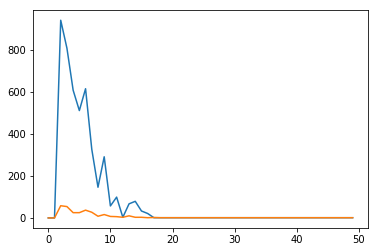

In [11]:
plt.plot(np.array(train_errors))
plt.plot(np.array(valid_errors))
plt.show()

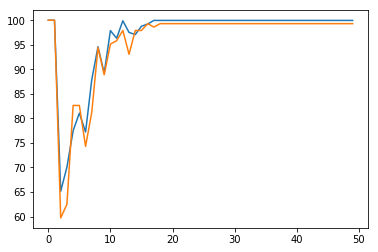

In [12]:
plt.plot(100*(Ntrain-np.array(train_errors))/Ntrain)
plt.plot(100*(Nvalidation-np.array(valid_errors))/Nvalidation)
plt.show()